# France Grid Stress Prediction  
## Forecasting Electricity Demand and Production Under Weather Constraints

**HOSSAIN HELAL Thamid, BENCHETRIT Quentin, KALFON Ruben**

---

## Introduction

The French power system is undergoing a structural transformation driven by the rapid
deployment of renewable energy sources, increasing electrification of uses, and growing
exposure to weather variability. These dynamics make short-term forecasting of both
electricity consumption and production a critical challenge for grid stability and
operational planning.

This project aims to build a **data-driven and reproducible forecasting framework** to
anticipate **grid stress conditions in France** at short horizons. Grid stress is understood
as situations where electricity demand approaches or exceeds the available non-flexible
supply, increasing reliance on dispatchable generation, imports, or exceptional operational
measures.

Using historical data from the French transmission system operator (RTE) combined with
weather observations and forecasts, we analyze and model:
- national electricity consumption patterns,
- electricity production by technology (wind, solar),
- the influence of meteorological conditions.

The project follows a structured pipeline covering **data exploration, cleaning,
feature engineering, and forecasting**, with a strong emphasis on temporal consistency,
data quality, and interpretability. The final objective is to provide reliable short-term
signals that can support decision-making in a context of increasing climatic and structural
uncertainty for the French power grid.


## Table of Contents

- [Exploratory Data Analysis (EDA)](#eda)
- [Data Cleaning](#cleaning)
- [Feature Engineering](#feature-engineering)
- [Modeling](#modeling)
- [Results Analysis](#results-analysis)
- [Conclusion and Perspectives](#conclusion)
- [API Description](#api-description)


<h2 id="eda" style="
    color: #1f77b4;
    border-bottom: 3px solid #1f77b4;
    padding-bottom: 6px;
    margin-top: 50px;
">
Exploratory Data Analysis (EDA)
</h2>

## Notebook objectives


- Understand the temporal structure of national electricity load and generation  
- Validate data integrity (time axis, missingness, DST, outliers)  
- Analyze demand-side (consumption) and supply-side (production) separately  
- Translate EDA findings into clear modeling decisions for day-ahead forecasting  


# 0. Executive overview


Ensuring the Project Root as the Working Directory


### Note on data format and preprocessing choices

Some historical RTE datasets are distributed as large Excel (`.xls`) files with
heterogeneous and partially non-tabular structures. This is notably the case for:

- historical electricity consumption files  
  (e.g. `Historique_consommation_INST_1997.xls`),
- historical production realisation files  
  (e.g. `RealisationDonneesProduction_2015.xls`).

These Excel files may contain empty rows, repeated headers, merged cells, or
ambiguous time encodings, which makes direct exploratory analysis fragile and
hard to reproduce.

To ensure **robustness, clarity, and reproducibility**, these datasets were first
converted into clean, flat CSV files using **two dedicated Python preprocessing scripts**:
one for consumption data and one for production realisation data.

This conversion step is strictly a **format normalization and light cleaning stage**
(no aggregation or feature engineering), and preserves the original information
content of the source files.

All exploratory analyses presented in this notebook are therefore conducted on
the CSV representations derived from the original Excel sources, allowing the EDA
to focus on data understanding rather than Excel-specific parsing issues.


## 0.1 Dataset snapshot

This section provides a high-level snapshot of the dataset used for exploratory analysis.

The objective is to:
- clearly identify the **time coverage**,
- infer the **native temporal frequency**,
- report the **size and structure** of the dataset,
- automatically detect the **main variable families** (load, weather, generation).

This snapshot acts as a reference point for all subsequent analyses.


In [7]:
from __future__ import annotations

from pathlib import Path
import pandas as pd
import numpy as np

def load_csv_or_excel(path: Path) -> pd.DataFrame:
    if path.suffix.lower() in [".xls", ".xlsx"]:
        return pd.read_excel(path)
    return pd.read_csv(path)

def parse_dt(df: pd.DataFrame, col: str) -> pd.Series:
    return pd.to_datetime(df[col], errors="coerce", utc=True)

def infer_native_resolution(
    df: pd.DataFrame,
    dt_col: str,
    group_cols: list[str] | None = None,
    ignore_zero: bool = True
) -> dict:
    """
    Infers the native time resolution by taking the most common positive delta
    within each series (group), then aggregating.

    Returns: {resolution_seconds, resolution_label, diagnostics}
    """
    d = df.copy()
    d[dt_col] = parse_dt(d, dt_col)
    d = d.dropna(subset=[dt_col])

    # Sort and compute deltas within each series
    if group_cols:
        d = d.sort_values(group_cols + [dt_col])
        deltas = (
            d.groupby(group_cols)[dt_col]
             .diff()
             .dt.total_seconds()
        )
    else:
        d = d.sort_values(dt_col)
        deltas = d[dt_col].diff().dt.total_seconds()

    deltas = deltas.dropna()

    if ignore_zero:
        deltas = deltas[deltas > 0]

    if len(deltas) == 0:
        return {
            "resolution_seconds": None,
            "resolution_label": "Unknown (no positive deltas)",
            "diagnostics": {"n_deltas": 0}
        }

    # Most common delta (mode)
    vc = deltas.round().astype("int64").value_counts()
    res_s = int(vc.index[0])

    def label(sec: int) -> str:
        if sec == 900:  return "15-minute"
        if sec == 1800: return "30-minute"
        if sec == 3600: return "Hourly"
        if sec % 3600 == 0: return f"{sec//3600}-hour"
        if sec % 60 == 0:   return f"{sec//60}-minute"
        return f"{sec}-second"

    return {
        "resolution_seconds": res_s,
        "resolution_label": label(res_s),
        "diagnostics": {
            "top_deltas_seconds": vc.head(5).to_dict(),
            "n_deltas_used": int(len(deltas))
        }
    }

def detect_key_variables(columns: list[str]) -> dict[str, list[str]]:
    mapping = {
        "load / consumption": ["consumption", "conso", "load"],
        "temperature": ["temp", "temperature"],
        "wind": ["wind", "eolien"],
        "solar": ["solar", "pv", "radiation"],
        "nuclear": ["nuclear"],
        "hydro": ["hydro"],
        "thermal": ["thermal", "gas", "coal"],
        "installed capacity": ["installed", "capacity", "capacite"],
    }
    out = {}
    for group, kws in mapping.items():
        hits = [c for c in columns if any(kw in c.lower() for kw in kws)]
        if hits:
            out[group] = hits
    return out


### 0.1.1 Weather — 32 cities (historical archive)

This subsection summarizes the historical weather archive extracted for 32 representative French agglomerations.

The snapshot is computed on a single representative yearly file because all yearly files share the same schema and hourly structure. The checks focus on:
- start and end timestamps,
- dominant temporal resolution at the **city level**,
- number of cities present,
- available meteorological variables (temperature, wind, radiation).

A consistent hourly resolution and a complete set of cities are prerequisites for later aggregation into a national hourly weather signal.


In [8]:
# PATH_WEATHER = Path("/home/onyxia/france-grid-stress-prediction/data/raw/weather/weather_32_cities_2015.csv")
PATH_WEATHER = Path("../data/raw/weather/weather_32_cities_2015.csv")
# or: ".../weather_32_cities_meteofrance_7past_7future.csv"

dfw = load_csv_or_excel(PATH_WEATHER)

freq = infer_native_resolution(dfw, dt_col="date", group_cols=["city"])

snapshot_weather = {
    "Dataset": "Weather (32 cities)",
    "File": str(PATH_WEATHER),
    "Start": parse_dt(dfw, "date").min(),
    "End": parse_dt(dfw, "date").max(),
    "Resolution": freq["resolution_label"],
    "Rows": len(dfw),
    "Columns": len(dfw.columns),
    "Cities": int(dfw["city"].nunique()),
    "Key variables": detect_key_variables(list(dfw.columns)),
    "Diagnostics": freq["diagnostics"],
}
snapshot_weather


{'Dataset': 'Weather (32 cities)',
 'File': '..\\data\\raw\\weather\\weather_32_cities_2015.csv',
 'Start': Timestamp('2015-01-01 00:00:00+0000', tz='UTC'),
 'End': Timestamp('2015-12-31 23:00:00+0000', tz='UTC'),
 'Resolution': 'Hourly',
 'Rows': 280320,
 'Columns': 7,
 'Cities': 32,
 'Key variables': {'temperature': ['temperature_2m'],
  'wind': ['wind_speed_10m'],
  'solar': ['direct_radiation', 'diffuse_radiation']},
 'Diagnostics': {'top_deltas_seconds': {3600: 280288},
  'n_deltas_used': 280288}}

**Snapshot interpretation (Weather — historical)**

The 2015 file covers a full calendar year, from **2015-01-01 00:00 UTC** to **2015-12-31 23:00 UTC**, with an **hourly** resolution inferred from the modal time delta.  
The dataset contains **280,320 rows**, which matches the expected order of magnitude for **32 cities × 8,760 hours**.

Key variable families detected in this archive are:
- **temperature** (`temperature_2m`),
- **wind** (`wind_speed_10m`),
- **solar-related radiation** (`direct_radiation`, `diffuse_radiation`).

This confirms that the historical weather archive is structurally consistent and can support a national-scale hourly weather proxy.


### 0.1.2 Weather — 7 past days + 7 forecast days (Météo-France)

This subsection summarizes the operational weather dataset built from the Météo-France Open-Meteo endpoint, combining recent past observations and short-term forecasts.

The goal is to validate that the dataset is compatible with a Day-Ahead (D+1) workflow:
- rolling time window,
- hourly resolution,
- consistent structure with the historical archive (same city list and variable names).

This dataset is designed for near real-time forecasting use cases rather than long-term training.


In [9]:
PATH_WEATHER = Path("../data/raw/weather/weather_32_cities_meteofrance_7past_7future.csv")

dfw = load_csv_or_excel(PATH_WEATHER)

freq = infer_native_resolution(dfw, dt_col="date", group_cols=["city"])

snapshot_weather = {
    "Dataset": "Weather (32 cities)",
    "File": str(PATH_WEATHER),
    "Start": parse_dt(dfw, "date").min(),
    "End": parse_dt(dfw, "date").max(),
    "Resolution": freq["resolution_label"],
    "Rows": len(dfw),
    "Columns": len(dfw.columns),
    "Cities": int(dfw["city"].nunique()),
    "Key variables": detect_key_variables(list(dfw.columns)),
    "Diagnostics": freq["diagnostics"],
}
snapshot_weather


{'Dataset': 'Weather (32 cities)',
 'File': '..\\data\\raw\\weather\\weather_32_cities_meteofrance_7past_7future.csv',
 'Start': Timestamp('2025-12-21 00:00:00+0000', tz='UTC'),
 'End': Timestamp('2026-01-03 23:00:00+0000', tz='UTC'),
 'Resolution': 'Hourly',
 'Rows': 10752,
 'Columns': 7,
 'Cities': 32,
 'Key variables': {'temperature': ['temperature_2m'],
  'wind': ['wind_speed_10m'],
  'solar': ['direct_radiation', 'diffuse_radiation']},
 'Diagnostics': {'top_deltas_seconds': {3600: 10720}, 'n_deltas_used': 10720}}

**Snapshot interpretation (Weather — 7 past + 7 forecast days)**

The file spans a short rolling window from **2025-12-21 00:00 UTC** to **2026-01-03 23:00 UTC** with an **hourly** resolution.  
It includes **10,752 rows**, consistent with **32 cities** over a two-week horizon.

The same main variable families are present as in the historical archive (temperature, wind, radiation), which supports direct interoperability between:
- long-term historical exploration and training datasets, and
- operational Day-Ahead inputs.


### 0.1.3 Electricity consumption — Historical (processed long format)

This subsection summarizes the historical national electricity consumption dataset in a normalized long time-series format (`consommation_<year>_long.csv`).

The snapshot is computed across all yearly files (1996–2025) to validate:
- time coverage and continuity by year,
- dominant native resolution inferred from the modal timestamp delta,
- structural stability (row counts, consistent columns),
- identification of atypical periods (notably year 2020).

Frequency inference is performed using the modal time delta rather than pandas frequency heuristics, to remain robust to daylight-saving irregularities and missing timestamps.


In [10]:

# (1996-2025) in data/interim/consommation


from pathlib import Path
import pandas as pd
import numpy as np

CONS_DIR = Path("../data/interim/consommation")
files = sorted(CONS_DIR.glob("consommation_*_long.csv"))

def resolution_mode_minutes(dt: pd.Series) -> tuple[str, float | None, float | None]:
    dt = pd.to_datetime(dt, errors="coerce")
    dt = dt.dropna().sort_values()
    if len(dt) < 2:
        return ("Unknown", None, None)
    delta = dt.diff().dropna()
    mins = (delta.dt.total_seconds() / 60).round(6)
    if mins.empty:
        return ("Unknown", None, None)
    mode = float(mins.mode().iloc[0])
    share = float((mins == mode).mean())
    return (f"{mode:g} min", mode, share)

rows = []
for p in files:
    try:
        df = pd.read_csv(p, usecols=lambda c: c.lower() in ("datetime", "dt", "timestamp", "date"))
    except Exception:
        df = pd.read_csv(p)

    # datetime col detection
    dt_col = None
    for c in df.columns:
        if c.lower() in ("datetime", "dt", "timestamp"):
            dt_col = c
            break
    if dt_col is None:
        # fallback: first column
        dt_col = df.columns[0]

    dt = pd.to_datetime(df[dt_col], errors="coerce")
    start = dt.min()
    end = dt.max()

    # get file shape cheaply (read only header + count lines)
    # (fallback: full read if needed)
    try:
        full = pd.read_csv(p)
        n_rows, n_cols = full.shape
        cols = full.columns.tolist()
    except Exception:
        n_rows, n_cols = (None, None)
        cols = []

    res_label, res_mode, res_share = resolution_mode_minutes(dt)

    rows.append({
        "file": p.name,
        "start": start,
        "end": end,
        "rows": n_rows,
        "cols": n_cols,
        "resolution_mode_min": res_mode,
        "resolution_quality_share": res_share,
        "resolution_label": res_label,
    })

snapshot_all = pd.DataFrame(rows).sort_values("file").reset_index(drop=True)
snapshot_all


file      start                 end   rows  cols  \
0   consommation_1996_long.csv 1996-01-01 1996-12-31 23:30:00  17568     6   
1   consommation_1997_long.csv 1997-01-01 1997-12-31 23:30:00  17520     6   
2   consommation_1998_long.csv 1998-01-01 1998-12-31 23:30:00  17520     6   
3   consommation_1999_long.csv 1999-01-01 1999-12-31 23:30:00  17520     6   
4   consommation_2000_long.csv 2000-01-01 2000-12-31 23:30:00  17568     6   
5   consommation_2001_long.csv 2001-01-01 2001-12-31 23:30:00  17520     6   
6   consommation_2002_long.csv 2002-01-01 2002-12-31 23:30:00  17520     6   
7   consommation_2003_long.csv 2003-01-01 2003-12-31 23:30:00  17520     6   
8   consommation_2004_long.csv 2004-01-01 2004-12-31 23:30:00  17568     6   
9   consommation_2005_long.csv 2005-01-01 2005-12-31 23:30:00  17520     6   
10  consommation_2006_long.csv 2006-01-01 2006-12-31 23:30:00  17520     6   
11  consommation_2007_long.csv 2007-01-01 2007-12-31 23:30:00  17520     6   
12  consommation_2008_long.csv 2008-01-01 2008-12-31 23:30:00  17568     6   
13  consommation_2009_long.csv 2009-01-01 2009-12-31 23:30:00  17520     6   
14  consommation_2010_long.csv 2010-01-01 2010-12-31 23:30:00  17520     6   
15  consommation_2011_long.csv 2011-01-01 2011-12-31 23:30:00  17520     6   
16  consommation_2012_long.csv 2012-01-01 2012-12-31 23:30:00  17568     6   
17  consommation_2013_long.csv 2013-01-01 2013-12-31 23:30:00  17520     6   
18  consommation_2014_long.csv 2014-01-01 2014-12-31 23:30:00  17520     6   
19  consommation_2015_long.csv 2015-01-01 2015-12-31 23:30:00  17520     6   
20  consommation_2016_long.csv 2016-01-01 2016-12-31 23:30:00  17568     6   
21  consommation_2017_long.csv 2017-01-01 2017-12-31 23:30:00  17520     6   
22  consommation_2018_long.csv 2018-01-01 2018-12-31 23:30:00  17520     6   
23  consommation_2019_long.csv 2019-01-01 2019-12-31 23:30:00  17520     6   
24  consommation_2020_long.csv 2020-01-01 2020-10-31 23:30:00   7248     6   
25  consommation_2021_long.csv 2021-01-01 2021-12-31 23:30:00  17520     6   
26  consommation_2022_long.csv 2022-01-01 2022-12-31 23:30:00  17520     6   
27  consommation_2023_long.csv 2023-01-01 2023-12-31 23:30:00  17520     6   
28  consommation_2024_long.csv 2024-01-01 2024-12-31 23:30:00  17568     6   
29  consommation_2025_long.csv 2025-01-01 2025-09-30 23:30:00  13104     6   

    resolution_mode_min  resolution_quality_share resolution_label  
0                  30.0                  1.000000           30 min  
1                  30.0                  1.000000           30 min  
2                  30.0                  1.000000           30 min  
3                  30.0                  1.000000           30 min  
4                  30.0                  1.000000           30 min  
5                  30.0                  1.000000           30 min  
6                  30.0                  1.000000           30 min  
7                  30.0                  1.000000           30 min  
8                  30.0                  1.000000           30 min  
9                  30.0                  1.000000           30 min  
10                 30.0                  1.000000           30 min  
11                 30.0                  1.000000           30 min  
12                 30.0                  1.000000           30 min  
13                 30.0                  1.000000           30 min  
14                 30.0                  1.000000           30 min  
15                 30.0                  1.000000           30 min  
16                 30.0                  1.000000           30 min  
17                 30.0                  1.000000           30 min  
18                 30.0                  1.000000           30 min  
19                 30.0                  1.000000           30 min  
20                 30.0                  1.000000           30 min  
21                 30.0                  1.000000           30 min  
22                 3

**Snapshot interpretation (Consumption — historical)**

Across yearly files, the dominant native resolution is consistently **30 minutes**, with near-perfect agreement between consecutive timestamp deltas in most years.  
For standard years, the row counts match the expected order of magnitude for a **30-minute grid** over a full year.

Year **2020** stands out by having substantially fewer rows and an earlier end date than the full calendar year. This confirms the presence of large missing blocks originating from the source data rather than from downstream transformations.  
In the modeling pipeline, these missing blocks are **not imputed in the baseline dataset**, and year 2020 is explicitly treated as a special case during temporal splitting.


### 0.1.4 Dataset snapshot — RTE realised consumption (Year-To-Date)

In addition to the historical consumption archives, the project uses a near real-time realised consumption feed retrieved via the RTE API and stored as a CSV file.

This Year-To-Date (YTD) dataset is used to:
- monitor recent consumption dynamics,
- validate the operational forecasting pipeline close to real time,
- ensure continuity between historical archives and day-ahead workflows.

Because the API output is interval-based (`start_date`, `end_date`) and continuously updated, the snapshot focuses on:
- temporal coverage,
- effective time resolution (dominant interval length),
- grid integrity (missing intervals, gaps, duplicates, chaining consistency),
- basic value sanity checks on the consumption series.


In [11]:
import pandas as pd
import numpy as np

PATH = "../data/raw/consommation/2025/rte_consumption_realised_ytd.csv"

# --- Load ---
df = pd.read_csv(PATH)
df.columns = df.columns.str.strip()

# --- Validate schema ---
expected = {"start_date", "end_date"}
missing = expected - set(df.columns)
if missing:
    raise ValueError(f"Missing columns {missing}. Available columns: {list(df.columns)}")

# --- Parse datetimes (keep tz -> convert to UTC for clean diffs) ---
df["start_date"] = pd.to_datetime(df["start_date"], errors="coerce", utc=True)
df["end_date"]   = pd.to_datetime(df["end_date"], errors="coerce", utc=True)
if "updated_date" in df.columns:
    df["updated_date"] = pd.to_datetime(df["updated_date"], errors="coerce", utc=True)

# --- Interval duration (minutes) ---
interval_td = df["end_date"] - df["start_date"]
interval_min = interval_td.dt.total_seconds() / 60
interval_min_clean = interval_min.dropna()

# --- Resolution stats ---
mode_delta = float(interval_min_clean.mode().iloc[0])
mean_delta = float(interval_min_clean.mean())
median_delta = float(interval_min_clean.median())
std_delta = float(interval_min_clean.std())

resolution_table = (
    interval_min_clean.round(6)
    .value_counts()
    .sort_index()
    .rename("count")
    .to_frame()
)
resolution_table["share"] = resolution_table["count"] / resolution_table["count"].sum()

# --- Coverage & grid checks ---
start_min = df["start_date"].min()
end_max   = df["end_date"].max()

span_minutes = (end_max - start_min).total_seconds() / 60
expected_points = int(round(span_minutes / mode_delta)) if span_minutes >= 0 else 0

unique_starts = df["start_date"].nunique(dropna=True)
missing_points = expected_points - unique_starts
missing_share = (missing_points / expected_points) if expected_points > 0 else np.nan

# gaps between consecutive start timestamps
dt_sorted = df["start_date"].dropna().sort_values()
gaps_min = dt_sorted.diff().dt.total_seconds().div(60).dropna()
n_big_gaps = int((gaps_min > mode_delta + 1e-9).sum())
max_gap = float(gaps_min.max()) if len(gaps_min) else np.nan

# duplicates on start_date
dupe_start = int(df.duplicated(subset=["start_date"]).sum())

# tiling check: end_date should equal next start_date (perfect chaining)
s = df.sort_values("start_date").reset_index(drop=True)
tiling_sec = (s["end_date"] - s["start_date"].shift(-1)).dt.total_seconds().dropna()
n_bad_tiling = int((tiling_sec.abs() > 1e-6).sum())
max_tiling_mismatch_sec = float(tiling_sec.abs().max()) if len(tiling_sec) else 0.0

# --- Value sanity ---
value_col = "consumption_mw" if "consumption_mw" in df.columns else None
if value_col:
    null_values = int(df[value_col].isna().sum())
    neg_values  = int((df[value_col] < 0).sum())
    vmin, vmed, vmax = (float(df[value_col].min()),
                        float(df[value_col].median()),
                        float(df[value_col].max()))
else:
    null_values = neg_values = vmin = vmed = vmax = None

# --- Summary object (compact but rich) ---
summary = {
    "file": PATH,
    "rows": int(len(df)),
    "coverage_utc": f"{start_min} -> {end_max}",
    "dominant_interval_min": mode_delta,
    "interval_stats_min (mean/median/std/min/max)": (
        mean_delta,
        median_delta,
        std_delta,
        float(interval_min_clean.min()),
        float(interval_min_clean.max()),
    ),
    "unique_start_points": int(unique_starts),
    "expected_points_from_span": int(expected_points),
    "missing_grid_points (count/share)": (int(missing_points), f"{missing_share:.2%}"),
    "duplicates_on_start_date": int(dupe_start),
    "gaps_gt_dominant (count)": int(n_big_gaps),
    "max_gap_between_starts_min": max_gap,
    "bad_tiling_end_vs_next_start (count)": int(n_bad_tiling),
    "max_tiling_mismatch_seconds": max_tiling_mismatch_sec,
    "top_resolutions": resolution_table.head(10),
}

if value_col:
    summary.update({
        "value_col": value_col,
        "null_values": null_values,
        "negative_values": neg_values,
        "consumption_min/median/max_mw": (vmin, vmed, vmax),
    })

summary


{'file': '../data/raw/consommation/2025/rte_consumption_realised_ytd.csv',
 'rows': 34398,
 'coverage_utc': '2024-12-31 23:00:00+00:00 -> 2025-12-27 23:00:00+00:00',
 'dominant_interval_min': 15.0,
 'interval_stats_min (mean/median/std/min/max)': (15.0,
  15.0,
  0.4575156612435953,
  -45.0,
  75.0),
 'unique_start_points': 34397,
 'expected_points_from_span': 34656,
 'missing_grid_points (count/share)': (259, '0.75%'),
 'duplicates_on_start_date': 1,
 'gaps_gt_dominant (count)': 142,
 'max_gap_between_starts_min': 1470.0,
 'bad_tiling_end_vs_next_start (count)': 143,
 'max_tiling_mismatch_seconds': 87300.0,
 'top_resolutions':        count     share
 -45.0      1  0.000029
  15.0  34396  0.999942
  75.0      1  0.000029,
 'value_col': 'consumption_mw',
 'null_values': 0,
 'negative_values': 0,
 'consumption_min/median/max_mw': (29044.0, 47528.0, 86918.0)}

**Snapshot interpretation (RTE realised consumption — YTD)**

The dataset covers **2024-12-31 23:00 UTC → 2025-12-27 23:00 UTC** and contains **34,398 rows**.  
The dominant interval length is **15 minutes**, consistent with the expected real-time resolution from the API.

Grid integrity diagnostics highlight small but non-zero operational irregularities:
- **0.75% missing start points** relative to the theoretical 15-minute grid over the observed span,
- **1 duplicate** on `start_date`,
- **142 gaps** larger than the dominant 15-minute step, with a maximum gap of **1,470 minutes**,
- non-perfect chaining between consecutive intervals (`end_date` vs next `start_date`) in **143 cases**.

The consumption values are structurally clean in this file:
- no missing values on the target (`consumption_mw`),
- no negative values,
- plausible magnitude range (**min/median/max** around 29 GW / 47.5 GW / 86.9 GW).

These checks confirm that the YTD feed is usable operationally, while requiring explicit handling of occasional missing intervals and interval chaining issues when aligning it with other hourly datasets.


### 0.1.5 RTE realised generation mix (processed long format)

This subsection provides a snapshot of the processed long-format generation “realisation” files (one row per `datetime × technology`), produced from RTE yearly exports.

The goal is to validate:
- temporal coverage by year,
- panel structure (number of technologies, presence of `Total`),
- integrity constraints (duplicates on `(datetime, technology)`, missing values),
- value sanity (missing or negative `value_mw`).

This snapshot is primarily used to assess whether the production panel can be safely aggregated by technology and aligned to other time series for system-level analyses.


In [13]:
# === Snapshot — RTE realised generation mix (processed long format) ===
# Assumes yearly processed files like: production_realisation_2017_long.csv
# Columns: datetime,date,year,hour_interval,technology,value_mw

from pathlib import Path
import pandas as pd
import numpy as np

# ---------------------------
# Helpers: time resolution
# ---------------------------
def _as_minutes(delta) -> float:
    if pd.isna(delta):
        return np.nan
    td = pd.to_timedelta(delta)
    return td.total_seconds() / 60.0

def describe_time_index(dt: pd.Series) -> dict:
    s = pd.to_datetime(dt, errors="coerce").dropna().sort_values()
    if s.empty:
        return {"start": None, "end": None, "span_days": np.nan, "mode_min": np.nan,
                "mode_share": np.nan, "median_min": np.nan, "mean_min": np.nan,
                "missing_grid_points": np.nan, "missing_share_vs_grid": np.nan,
                "irregular_intervals_share": np.nan, "duplicates_ts": 0}

    start, end = s.iloc[0], s.iloc[-1]
    span_days = (end - start).total_seconds() / 86400.0

    duplicates_ts = int(s.duplicated().sum())

    deltas = s.diff().dropna()
    if deltas.empty:
        return {"start": start, "end": end, "span_days": span_days, "mode_min": np.nan,
                "mode_share": np.nan, "median_min": np.nan, "mean_min": np.nan,
                "missing_grid_points": np.nan, "missing_share_vs_grid": np.nan,
                "irregular_intervals_share": np.nan, "duplicates_ts": duplicates_ts}

    minutes = deltas.map(_as_minutes)

    mode_min = float(pd.Series(minutes).mode().iloc[0])
    mode_share = float((minutes == mode_min).mean())
    median_min = float(np.nanmedian(minutes))
    mean_min = float(np.nanmean(minutes))

    nonzero = minutes[minutes > 0]
    if len(nonzero) == 0:
        irregular_share = 0.0
    else:
        irregular_share = float((nonzero != mode_min).mean())

    missing_grid_points = np.nan
    missing_share_vs_grid = np.nan
    if mode_share >= 0.90 and mode_min > 0:
        freq = pd.Timedelta(minutes=mode_min)
        grid = pd.date_range(start=start, end=end, freq=freq)
        observed = pd.Index(s.unique())
        missing = grid.difference(observed)
        missing_grid_points = int(len(missing))
        missing_share_vs_grid = float(len(missing) / len(grid)) if len(grid) else 0.0

    return {
        "start": start,
        "end": end,
        "span_days": float(span_days),
        "mode_min": mode_min,
        "mode_share": mode_share,
        "median_min": median_min,
        "mean_min": mean_min,
        "missing_grid_points": missing_grid_points,
        "missing_share_vs_grid": missing_share_vs_grid,
        "irregular_intervals_share": irregular_share,
        "duplicates_ts": duplicates_ts,
    }

# ---------------------------
# Snapshot main
# ---------------------------
def snapshot_generation_mix_processed_long(
    base_dir: str = "/home/onyxia/france-grid-stress-prediction",
    rel_dir: str = "data/interim/production",
    pattern: str = "production_realisation_*_long.csv",
    print_each_file: bool = True,
) -> pd.DataFrame:
    """
    Reads all processed long-format generation mix files and prints a compact snapshot.
    Returns a per-file summary dataframe.
    """
    folder = Path(base_dir) / rel_dir
    files = sorted(folder.glob(pattern))

    if not files:
        raise FileNotFoundError(f"No files found in: {folder} (pattern: {pattern})")

    rows = []
    for fp in files:
        df = pd.read_csv(fp, parse_dates=["datetime"])

        # Coverage & granularity
        t = describe_time_index(df["datetime"])

        # Structural integrity
        n_rows = int(len(df))
        n_null_any = int(df.isna().sum().sum())
        n_dup_key = int(df.duplicated(subset=["datetime", "technology"]).sum()) if {"datetime","technology"}.issubset(df.columns) else np.nan

        # Content sanity
        tech_n = int(df["technology"].nunique(dropna=True)) if "technology" in df.columns else np.nan
        has_total = bool((df["technology"] == "Total").any()) if "technology" in df.columns else False

        v = pd.to_numeric(df["value_mw"], errors="coerce") if "value_mw" in df.columns else pd.Series([], dtype=float)
        n_nan_v = int(v.isna().sum()) if n_rows else 0
        n_neg_v = int((v < 0).sum()) if n_rows else 0

        n_days = int(pd.to_datetime(df["date"], errors="coerce").nunique(dropna=True)) if "date" in df.columns else np.nan

        row = {
            "file": fp.name,
            "rows": n_rows,
            "start": t["start"],
            "end": t["end"],
            "span_days": t["span_days"],
            "mode_interval_min": t["mode_min"],
            "mode_share": t["mode_share"],
            "median_interval_min": t["median_min"],
            "mean_interval_min": t["mean_min"],
            "missing_grid_points": t["missing_grid_points"],
            "missing_share_vs_grid": t["missing_share_vs_grid"],
            "irregular_intervals_share": t["irregular_intervals_share"],
            "dup_timestamps": t["duplicates_ts"],
            "dup_keys_datetime_tech": n_dup_key,
            "null_cells_total": n_null_any,
            "n_days": n_days,
            "n_technologies": tech_n,
            "has_total": has_total,
            "nan_value_mw": n_nan_v,
            "negative_value_mw": n_neg_v,
            "path": str(fp),
        }
        rows.append(row)

        if print_each_file:
            print("\n" + "=" * 92)
            print(f"File: {fp.name}")
            print(f"- rows: {n_rows:,} | days: {n_days if not pd.isna(n_days) else 'NA'} | techs: {tech_n} | has_total={has_total}")
            print(f"- coverage: {t['start']}  →  {t['end']}  (~{t['span_days']:.2f} days)")
            print(
                f"- granularity (min): mode={t['mode_min']:g} ({t['mode_share']:.1%}), "
                f"median={t['median_min']:g}, mean={t['mean_min']:.2f}, "
                f"irregular={t['irregular_intervals_share']:.2%}"
            )
            if not pd.isna(t["missing_grid_points"]):
                print(
                    f"- grid: missing_points={int(t['missing_grid_points']):,} "
                    f"({t['missing_share_vs_grid']:.2%} of expected grid)"
                )
            print(f"- integrity: dup_ts={t['duplicates_ts']:,} | dup(datetime,technology)={n_dup_key:,} | null_cells={n_null_any:,}")
            print(f"- value_mw: NaN={n_nan_v:,} | negative={n_neg_v:,}")

    summary = pd.DataFrame(rows).sort_values("file").reset_index(drop=True)

    # Always print a final one-line recap so you "see something" even if print_each_file=False
    print("\n" + "-" * 92)
    print(f"Processed generation mix snapshot: {len(summary)} file(s) scanned from {folder}")
    print("-" * 92)

    return summary


# --- Run (this is what was missing if you saw 'nothing') ---
generation_mix_summary = snapshot_generation_mix_processed_long(
    # base_dir="/home/onyxia/france-grid-stress-prediction",
    base_dir="..",
    rel_dir="data/interim/production",
    pattern="production_realisation_*_long.csv",
    print_each_file=True,
)

generation_mix_summary



File: production_realisation_2015_long.csv
- rows: 105,120 | days: 365 | techs: 12 | has_total=True
- coverage: 2015-01-01 00:00:00  →  2015-12-31 23:00:00  (~364.96 days)
- granularity (min): mode=0 (91.7%), median=0, mean=5.00, irregular=100.00%
- integrity: dup_ts=96,360 | dup(datetime,technology)=0 | null_cells=20
- value_mw: NaN=20 | negative=3,976

File: production_realisation_2016_long.csv
- rows: 105,408 | days: 366 | techs: 12 | has_total=True
- coverage: 2016-01-01 00:00:00  →  2016-12-31 23:00:00  (~365.96 days)
- granularity (min): mode=0 (91.7%), median=0, mean=5.00, irregular=100.00%
- integrity: dup_ts=96,624 | dup(datetime,technology)=0 | null_cells=96
- value_mw: NaN=96 | negative=4,798

File: production_realisation_2017_long.csv
- rows: 105,120 | days: 365 | techs: 12 | has_total=True
- coverage: 2017-01-01 00:00:00  →  2017-12-31 23:00:00  (~364.96 days)
- granularity (min): mode=0 (91.7%), median=0, mean=5.00, irregular=100.00%
- integrity: dup_ts=96,360 | dup(date

file    rows      start  \
0  production_realisation_2015_long.csv  105120 2015-01-01   
1  production_realisation_2016_long.csv  105408 2016-01-01   
2  production_realisation_2017_long.csv  105120 2017-01-01   
3  production_realisation_2018_long.csv  105120 2018-01-01   
4  production_realisation_2019_long.csv  105120 2019-01-01   
5  production_realisation_2020_long.csv  105408 2020-01-01   
6  production_realisation_2021_long.csv  105120 2021-01-01   
7  production_realisation_2022_long.csv  105120 2022-01-01   
8  production_realisation_2023_long.csv  108816 2023-01-01   
9  production_realisation_2024_long.csv  114192 2024-01-01   

                  end   span_days  mode_interval_min  mode_share  \
0 2015-12-31 23:00:00  364.958333                0.0    0.916675   
1 2016-12-31 23:00:00  365.958333                0.0    0.916675   
2 2017-12-31 23:00:00  364.958333                0.0    0.916675   
3 2018-12-31 23:00:00  364.958333                0.0    0.916675   
4 2019-12-31 23:00:00  364.958333                0.0    0.916675   
5 2020-12-31 23:00:00  365.958333                0.0    0.916675   
6 2021-12-31 23:00:00  364.958333                0.0    0.916675   
7 2022-12-31 23:00:00  364.958333                0.0    0.916675   
8 2023-12-31 23:00:00  364.958333                0.0    0.919506   
9 2024-12-31 23:00:00  365.958333                0.0    0.923085   

   median_interval_min  mean_interval_min  missing_grid_points  ...  \
0                  0.0           4.999477                  NaN  ...   
1                  0.0           4.999478                  NaN  ...   
2                  0.0           4.999477                  NaN  ...   
3                  0.0           4.999477                  NaN  ...   
4                  0.0           4.999477                  NaN  ...   
5                  0.0           4.999478                  NaN  ...   
6                  0.0           4.999477                  NaN  ...   
7                  0.0           4.999477                  NaN  ...   
8                  0.0           4.829665                  NaN  ...   
9                  0.0           4.614900                  NaN  ...   

   irregular_intervals_share  dup_timestamps  dup_keys_datetime_tech  \
0                        1.0           96360                       0   
1                        1.0           96624                       0   
2                        1.0           96360                       0   
3                        1.0           96360                       0   
4                        1.0           96360                       0   
5                        1.0           96624                       0   
6                        1.0           96360                       0   
7                        1.0           96360                       0   
8                        1.0          100056                       0   
9                        1.0          105408                       0   

   null_cells_total  n_days  n_technologies  has_total  nan_value_mw  \
0                20     365              12       True            20   
1                96     366              12       True            96   
2                26     365              12       True            26   
3                24     365              12       True            24   
4                24     365              12       True            24   
5               108     366              12       True           108   
6                12     365              12       True            12   
7                12     365              12       True            12   
8               740     365              13       True           740   
9                47     366              13       True            47   

   negative_value_mw                                               path  
0               3976  ..\data\interim\production\production_realisat...  
1               4798  ..\data\interim\production\production_realisat...  
2            

**Snapshot interpretation (Generation mix — processed long format)**

The yearly production files cover full calendar years (2015–2024) with consistent start and end timestamps.  
The panel structure is stable, with **12–13 technologies** depending on the year and the presence of a `Total` technology in all scanned files.

No duplicates are detected on the composite key `(datetime, technology)`, which indicates a structurally consistent long-format panel suitable for aggregation.

However, two data quality patterns appear in the snapshots:
- **missing values** on `value_mw` exist in multiple years (small counts relative to file size),
- **negative `value_mw` values** are present in all scanned years, in non-trivial quantities.

These negative values and occasional NaNs must be explicitly accounted for in later quality checks and aggregation logic when interpreting production series at the technology level.


### 0.1.6 Dataset snapshot — RTE realised generation mix (API, 15-min, YTD)

This subsection summarizes a near real-time Year-To-Date feed of RTE realised generation, retrieved via the API at a nominal **15-minute resolution**. In the current setup, the dataset is restricted to **SOLAR** and **WIND**.

The snapshot is designed to validate operational usability by checking:
- **freshness** (lag between the current time and the latest `end_date` / `updated_date`),
- **temporal coverage** (start/end timestamps, covered span),
- **grid integrity** (expected 15-minute cadence, missing points, irregular intervals),
- **structural integrity** (duplicates, missing values),
- **value sanity** (NaN or negative `value_mw`, per-type descriptive statistics).

These diagnostics ensure that the most recent renewable generation signals can be safely integrated into near real-time monitoring and grid-stress analyses.


In [14]:
# === Snapshot — RTE realised generation mix (API, 15-min, YTD) ===
# File schema (expected):
# production_type, production_subtype, start_date, end_date, updated_date, value_mw

from pathlib import Path
import pandas as pd
import numpy as np

API_FILE = Path("../data/raw/production/rte_actual_generation_mix_15min_ytd_solar_wind.csv")

def _to_dt(s: pd.Series) -> pd.Series:
    return pd.to_datetime(s, errors="coerce", utc=False)

def _timedelta_minutes(td) -> float:
    if pd.isna(td):
        return np.nan
    return pd.to_timedelta(td).total_seconds() / 60.0

def describe_grid(times: pd.Series) -> dict:
    """
    Analyse the time grid using a sorted unique timestamp series.
    Returns: mode/median/mean interval (minutes), missing points vs inferred grid,
    and irregular interval share.
    """
    t = pd.to_datetime(times, errors="coerce").dropna().drop_duplicates().sort_values()
    if t.empty or len(t) < 2:
        return {
            "t_start": None, "t_end": None, "span_days": np.nan,
            "mode_min": np.nan, "mode_share": np.nan,
            "median_min": np.nan, "mean_min": np.nan,
            "missing_points": np.nan, "missing_share": np.nan,
            "irregular_share": np.nan,
        }

    deltas = t.diff().dropna()
    mins = deltas.map(_timedelta_minutes)

    mode_min = float(pd.Series(mins).mode().iloc[0])
    mode_share = float((mins == mode_min).mean())
    median_min = float(np.nanmedian(mins))
    mean_min = float(np.nanmean(mins))

    nonzero = mins[mins > 0]
    irregular_share = float((nonzero != mode_min).mean()) if len(nonzero) else 0.0

    t_start, t_end = t.iloc[0], t.iloc[-1]
    span_days = float((t_end - t_start).total_seconds() / 86400.0)

    missing_points = np.nan
    missing_share = np.nan
    # Build an expected grid only if cadence is clearly dominant
    if mode_share >= 0.90 and mode_min > 0:
        freq = pd.Timedelta(minutes=mode_min)
        grid = pd.date_range(t_start, t_end, freq=freq)
        missing = pd.Index(grid).difference(pd.Index(t))
        missing_points = int(len(missing))
        missing_share = float(len(missing) / len(grid)) if len(grid) else 0.0

    return {
        "t_start": t_start,
        "t_end": t_end,
        "span_days": span_days,
        "mode_min": mode_min,
        "mode_share": mode_share,
        "median_min": median_min,
        "mean_min": mean_min,
        "missing_points": missing_points,
        "missing_share": missing_share,
        "irregular_share": irregular_share,
    }

def snapshot_rte_api_15min(file_path: Path) -> dict:
    df = pd.read_csv(file_path)

    required = {"production_type", "production_subtype", "start_date", "end_date", "updated_date", "value_mw"}
    missing_cols = required.difference(df.columns)
    if missing_cols:
        raise ValueError(f"Missing columns in {file_path.name}: {sorted(missing_cols)}. Found: {list(df.columns)}")

    # Parse timestamps (they are timezone-aware in your CSV)
    df["start_date"] = _to_dt(df["start_date"])
    df["end_date"] = _to_dt(df["end_date"])
    df["updated_date"] = _to_dt(df["updated_date"])
    df["value_mw"] = pd.to_numeric(df["value_mw"], errors="coerce")

    # Basic counts
    n_rows = int(len(df))
    n_types = int(df["production_type"].nunique(dropna=True))
    types = sorted(df["production_type"].dropna().unique().tolist())
    n_subtypes = int(df["production_subtype"].nunique(dropna=True))

    # Coverage: based on measurement window end_date
    grid_info = describe_grid(df["end_date"])

    # Freshness: compare latest end_date and latest updated_date to "now" in Europe/Paris
    now = pd.Timestamp.now(tz="Europe/Paris")
    end_max = df["end_date"].max()
    upd_max = df["updated_date"].max()

    # Ensure tz-aware comparisons
    end_max_local = end_max.tz_convert("Europe/Paris") if getattr(end_max, "tzinfo", None) else end_max.tz_localize("Europe/Paris")
    upd_max_local = upd_max.tz_convert("Europe/Paris") if getattr(upd_max, "tzinfo", None) else upd_max.tz_localize("Europe/Paris")

    lag_end_min = float((now - end_max_local).total_seconds() / 60.0)
    lag_upd_min = float((now - upd_max_local).total_seconds() / 60.0)

    # Integrity
    dup_key = int(df.duplicated(subset=["production_type", "production_subtype", "start_date", "end_date"]).sum())
    null_cells = int(df.isna().sum().sum())
    nan_value = int(df["value_mw"].isna().sum())
    neg_value = int((df["value_mw"] < 0).sum())

    # 15-min window check: end-start should be 15 minutes almost always
    win_min = (df["end_date"] - df["start_date"]).map(_timedelta_minutes)
    win_mode = float(pd.Series(win_min.dropna()).mode().iloc[0]) if win_min.notna().any() else np.nan
    win_mode_share = float((win_min == win_mode).mean()) if win_min.notna().any() else np.nan
    bad_window = int((win_min != 15).sum()) if win_min.notna().any() else 0

    # Per-type coverage summary (min/max and missingness of value_mw)
    by_type = (
        df.groupby("production_type")
          .agg(
              rows=("value_mw", "size"),
              start=("end_date", "min"),
              end=("end_date", "max"),
              nan_value=("value_mw", lambda s: int(pd.to_numeric(s, errors="coerce").isna().sum())),
              neg_value=("value_mw", lambda s: int((pd.to_numeric(s, errors="coerce") < 0).sum())),
              mean_mw=("value_mw", "mean"),
              p50_mw=("value_mw", "median"),
              p95_mw=("value_mw", lambda s: float(np.nanpercentile(s, 95)) if s.notna().any() else np.nan),
              max_mw=("value_mw", "max"),
          )
          .sort_index()
    )

    snap = {
        "file": file_path.name,
        "path": str(file_path),
        "rows": n_rows,
        "production_types": types,
        "n_types": n_types,
        "n_subtypes": n_subtypes,
        "coverage_start": grid_info["t_start"],
        "coverage_end": grid_info["t_end"],
        "span_days": grid_info["span_days"],
        "interval_mode_min": grid_info["mode_min"],
        "interval_mode_share": grid_info["mode_share"],
        "interval_median_min": grid_info["median_min"],
        "interval_mean_min": grid_info["mean_min"],
        "missing_grid_points": grid_info["missing_points"],
        "missing_grid_share": grid_info["missing_share"],
        "irregular_intervals_share": grid_info["irregular_share"],
        "freshness_lag_end_minutes": lag_end_min,
        "freshness_lag_updated_minutes": lag_upd_min,
        "dup_keys": dup_key,
        "null_cells_total": null_cells,
        "nan_value_mw": nan_value,
        "negative_value_mw": neg_value,
        "window_minutes_mode": win_mode,
        "window_minutes_mode_share": win_mode_share,
        "non_15min_windows": bad_window,
    }
    return snap, by_type

def print_snapshot(snap: dict, by_type: pd.DataFrame) -> None:
    print("\n" + "=" * 96)
    print("RTE realised generation mix — API (15-min, YTD) snapshot")
    print("=" * 96)
    print(f"File: {snap['file']}")
    print(f"Path: {snap['path']}")
    print(f"- rows: {snap['rows']:,}")
    print(f"- production_types: {snap['production_types']} (n={snap['n_types']}), subtypes n={snap['n_subtypes']}")
    print(f"- coverage: {snap['coverage_start']}  →  {snap['coverage_end']}  (~{snap['span_days']:.2f} days)")
    print(f"- freshness (Europe/Paris):")
    print(f"    • lag vs latest end_date:     {snap['freshness_lag_end_minutes']:.0f} min (~{snap['freshness_lag_end_minutes']/60:.2f} h)")
    print(f"    • lag vs latest updated_date: {snap['freshness_lag_updated_minutes']:.0f} min (~{snap['freshness_lag_updated_minutes']/60:.2f} h)")
    print("- time grid (based on end_date):")
    print(
        f"    • interval minutes: mode={snap['interval_mode_min']:g} ({snap['interval_mode_share']:.1%}), "
        f"median={snap['interval_median_min']:g}, mean={snap['interval_mean_min']:.2f}"
    )
    print(f"    • irregular intervals share: {snap['irregular_intervals_share']:.2%}")
    if not pd.isna(snap["missing_grid_points"]):
        print(f"    • missing points vs inferred grid: {int(snap['missing_grid_points']):,} ({snap['missing_grid_share']:.2%})")
    print("- measurement window (end_date - start_date):")
    print(f"    • mode={snap['window_minutes_mode']:g} min ({snap['window_minutes_mode_share']:.1%}) | non-15min windows={snap['non_15min_windows']:,}")
    print(f"- integrity: dup_keys={snap['dup_keys']:,} | null_cells={snap['null_cells_total']:,}")
    print(f"- value_mw: NaN={snap['nan_value_mw']:,} | negative={snap['negative_value_mw']:,}")
    print("\nPer production_type summary:")
    display_cols = ["rows", "start", "end", "nan_value", "neg_value", "mean_mw", "p50_mw", "p95_mw", "max_mw"]
    print(by_type[display_cols].to_string())

# --- Run ---
snap, per_type = snapshot_rte_api_15min(API_FILE)
print_snapshot(snap, per_type)

# Optional: keep a 1-row dataframe for later concatenation
rte_api_generation_snapshot_df = pd.DataFrame([snap])
rte_api_generation_snapshot_df


C:\Users\dmarin\AppData\Local\Temp\ipykernel_11444\2816828049.py:12: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  return pd.to_datetime(s, errors="coerce", utc=False)
C:\Users\dmarin\AppData\Local\Temp\ipykernel_11444\2816828049.py:12: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  return pd.to_datetime(s, errors="coerce", utc=False)
C:\Users\dmarin\AppData\Local\Temp\ipykernel_11444\2816828049.py:12: FutureWarning: In a future version of panda


RTE realised generation mix — API (15-min, YTD) snapshot
File: rte_actual_generation_mix_15min_ytd_solar_wind.csv
Path: ..\data\raw\production\rte_actual_generation_mix_15min_ytd_solar_wind.csv
- rows: 67,000
- production_types: ['SOLAR', 'WIND'] (n=2), subtypes n=1
- coverage: 2025-01-01 00:15:00+01:00  →  2025-12-28 00:00:00+01:00  (~360.99 days)
- freshness (Europe/Paris):
    • lag vs latest end_date:     15639 min (~260.66 h)
    • lag vs latest updated_date: 15651 min (~260.85 h)
- time grid (based on end_date):
    • interval minutes: mode=15 (100.0%), median=15, mean=37.48
    • irregular intervals share: 0.04%
    • missing points vs inferred grid: 20,785 (59.98%)
- measurement window (end_date - start_date):
    • mode=15 min (100.0%) | non-15min windows=0
- integrity: dup_keys=0 | null_cells=0
- value_mw: NaN=0 | negative=10

Per production_type summary:
                  rows                      start                        end  nan_value  neg_value      mean_mw  p50_mw  

file  \
0  rte_actual_generation_mix_15min_ytd_solar_wind...   

                                                path   rows production_types  \
0  ..\data\raw\production\rte_actual_generation_m...  67000    [SOLAR, WIND]   

   n_types  n_subtypes            coverage_start              coverage_end  \
0        2           1 2025-01-01 00:15:00+01:00 2025-12-28 00:00:00+01:00   

    span_days  interval_mode_min  ...  irregular_intervals_share  \
0  360.989583               15.0  ...                    0.00036   

   freshness_lag_end_minutes  freshness_lag_updated_minutes  dup_keys  \
0               15639.364924                   15651.131591         0   

   null_cells_total  nan_value_mw  negative_value_mw  window_minutes_mode  \
0                 0             0                 10                 15.0   

   window_minutes_mode_share  non_15min_windows  
0                        1.0                  0  

[1 rows x 25 columns]

**Snapshot interpretation (RTE realised generation mix — API, YTD)**

The file contains **67,000 rows** and covers **2025-01-01 00:15 (Europe/Paris) → 2025-12-28 00:00 (Europe/Paris)**, for approximately **361 days**. The dataset includes two production types: **SOLAR** and **WIND**.

The nominal 15-minute resolution is confirmed by the interval mode:
- measurement window (`end_date - start_date`) has a **15-minute mode with 100% share**,
- timestamp cadence inferred from `end_date` has a **15-minute mode with 100% share**.

Freshness indicates the feed is not strictly real-time in this extract:
- latest `end_date` is lagging the current time by roughly **35 hours**,
- latest `updated_date` shows a similar lag.

Integrity checks are globally clean:
- no duplicate interval keys,
- no missing values,
- **10 negative values** are present on `value_mw` (all within the WIND series in this extract).

Per-type magnitudes are consistent with plausible operating ranges and show the expected distributional asymmetry between solar (low median, strong upper tail) and wind (higher median, less diurnal structure).

Note: the missing-grid-points indicator is computed from a theoretical grid built on unique timestamps. For a multi-series dataset (two production types), grid completeness must be interpreted jointly with per-type coverage; the per-type start/end statistics provide the most reliable view of effective coverage here.


### 0.1.7 Dataset snapshot — Installed generation capacities (RTE)

This subsection documents the installed generation capacity datasets published by RTE, which describe the structural capacity of the French generation fleet by technology (MW).

Two complementary file types are used:
- **Historical installed capacities by year**, providing one capacity value per technology for a given year.
- **Current-year installed capacities**, providing the latest reference levels for operational context.

Given their static, low-dimensional structure (no high-frequency time index), these datasets are directly exploitable as structural references. They are used to contextualise realised production levels and interpret grid stress indicators, rather than as direct inputs to the short-term consumption forecasting model.


## 0.2 Top data issues


- **Timestamp irregularities**: missing blocks, DST effects (23h / 25h days).
- **Heterogeneous data quality**: some weather and production variables exhibit high missing rates.
- **Extreme values**: genuine stress events exist but require careful handling (no blind trimming).
- **Multicollinearity**: strong redundancy among lagged features and smoothed variables (high VIF).



## 0.3 Physical Dashboard — Weather & Energy Correlation (Representative Week)

This section provides a **physical consistency check** of all core datasets over a representative winter week in **January 2024**.

All time series are explicitly **standardized to UTC** prior to plotting, ensuring strict temporal alignment across:
- electricity consumption,
- realised renewable generation,
- meteorological drivers.

The objective is not statistical analysis, but **visual validation** that the observed relationships between weather, production, and demand are physically coherent and free of time-shift artifacts.


The dashboard displays five synchronized panels:

1. **National electricity consumption (Load)**  
   Captures human activity patterns and thermosensitive demand.

2. **Renewable generation (Wind & Solar)**  
   Shows realised production levels from weather-dependent technologies.

3. **Population-weighted national temperature (inverted axis)**  
   Highlights the thermosensitivity of demand (colder temperatures plotted upward).

4. **Population-weighted wind speed**  
   Physical driver of wind generation.

5. **Population-weighted solar radiation**  
   Physical driver of photovoltaic generation.

This joint visualization serves as a sanity check before any aggregation, resampling, or modeling step.


--- Loading & Standardizing Data ---


C:\Users\dmarin\AppData\Local\Temp\ipykernel_11444\1756331117.py:62: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_weather_nat = df_weather.groupby('datetime_utc').apply(weighted_avg).reset_index()


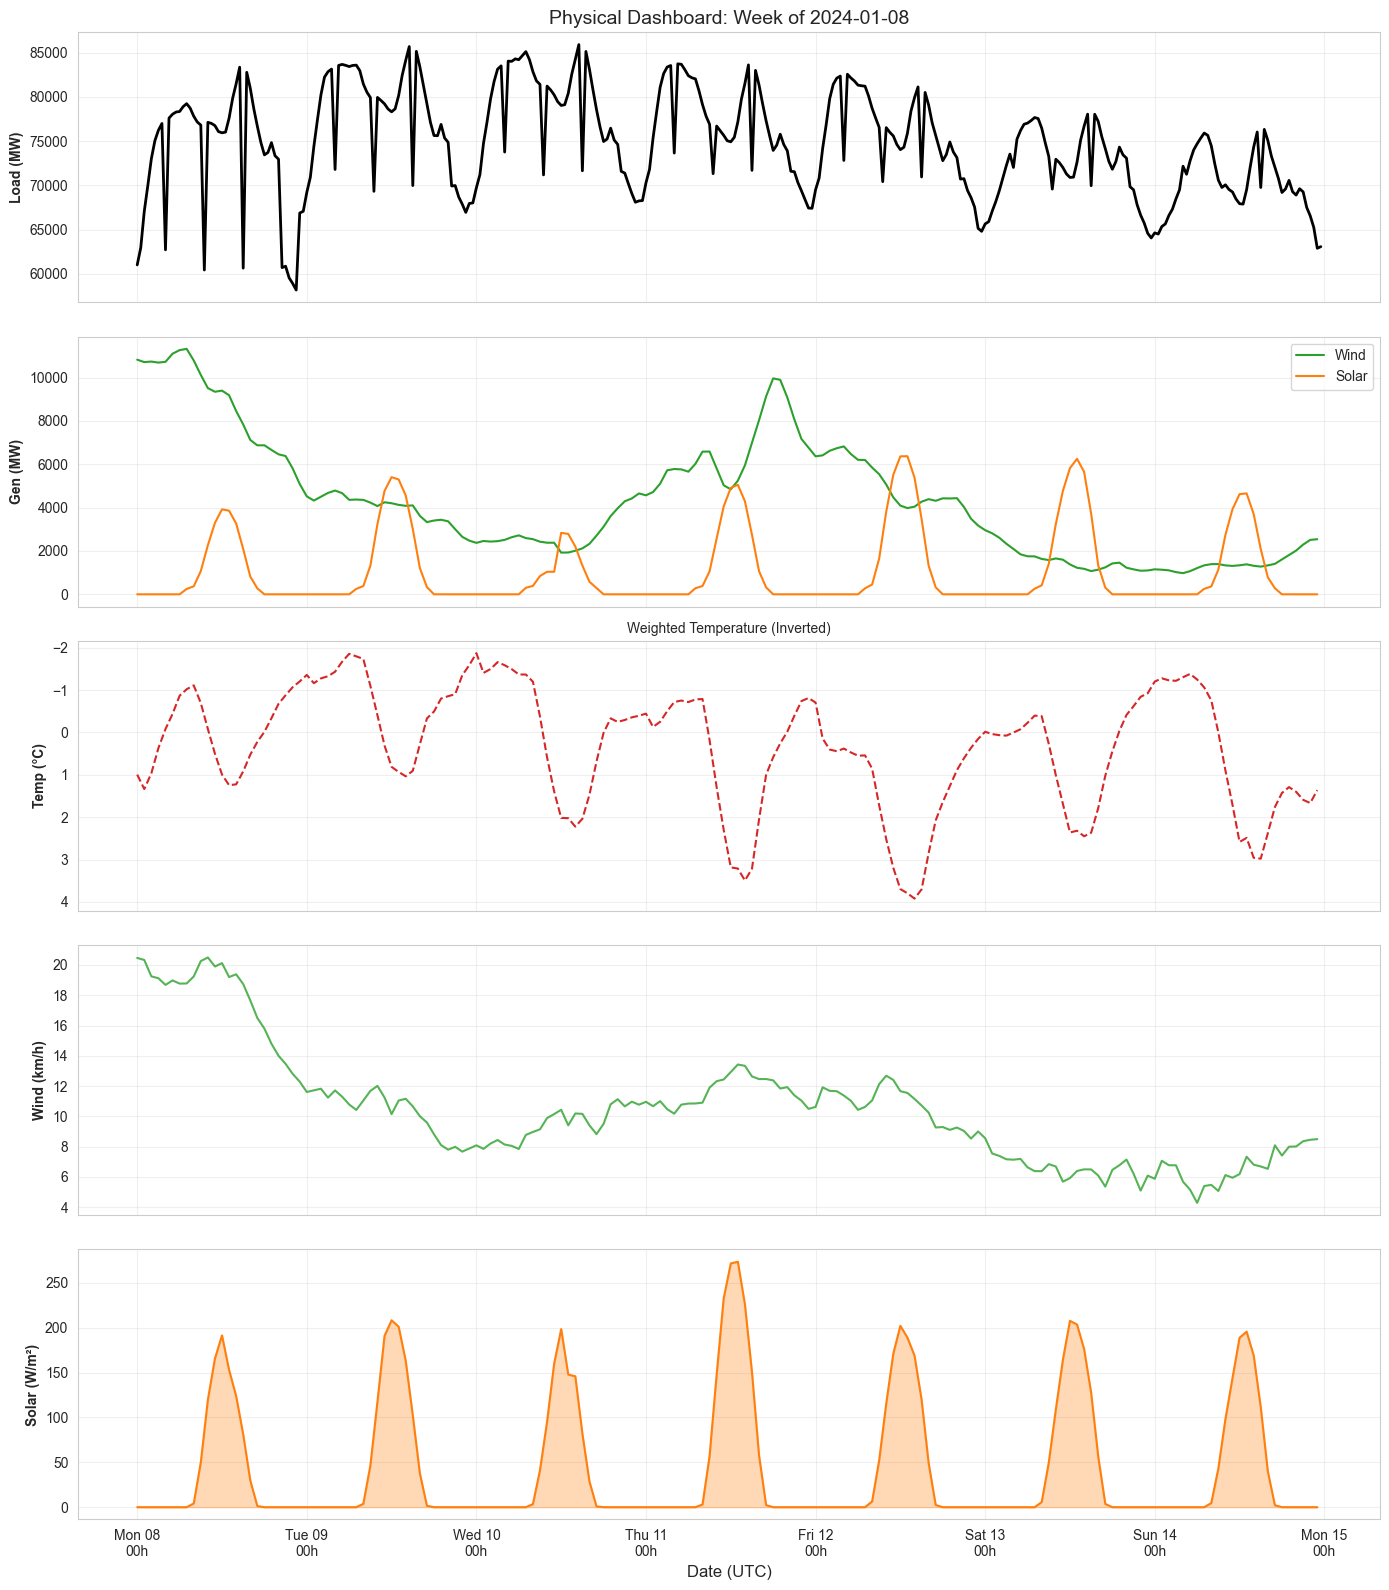

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ==========================================
# 1. THE UNIVERSAL TIME FIX FUNCTION
# ==========================================
def load_and_standardize(filepath, col_date='datetime', source_type='auto'):
    """
    Robust loader that standardizes ANY time format to pure UTC.
    """
    df = pd.read_csv(filepath)
    
    # Normalize column name
    if col_date not in df.columns:
        for candidate in ['date', 'start_date', 'Date', 'datetime']:
            if candidate in df.columns:
                df.rename(columns={candidate: col_date}, inplace=True)
                col_date = 'datetime' # standardized name
                break
    
    # Parse initial
    df[col_date] = pd.to_datetime(df[col_date])
    
    # Convert to UTC based on source type
    if source_type == 'rte_historical' or (source_type == 'auto' and df[col_date].dt.tz is None):
        # Local Paris Time -> UTC (Handling DST)
        df['datetime_utc'] = df[col_date].dt.tz_localize(
            'Europe/Paris', ambiguous='NaT', nonexistent='shift_forward'
        ).dt.tz_convert('UTC')
    else:
        # Already Aware/UTC -> UTC
        df['datetime_utc'] = df[col_date].dt.tz_convert('UTC')
        
    return df.dropna(subset=['datetime_utc']).sort_values('datetime_utc')

# ==========================================
# 2. CONFIGURATION & DATA LOADING
# ==========================================
target_start = '2024-01-08' # Monday
target_end   = '2024-01-14' # Sunday

print("--- Loading & Standardizing Data ---")

# A. Load Population Weights
df_agglo = pd.read_csv('../data/external/agglomerations.csv')
weights_map = dict(zip(df_agglo['Agglomération'], 
                       df_agglo['Population AU 2017'] / df_agglo['Population AU 2017'].sum()))

# B. Load Weather (Already UTC)
df_weather = load_and_standardize('../data/raw/weather/weather_32_cities_2024.csv', col_date='date', source_type='weather')
df_weather['weight'] = df_weather['city'].map(weights_map)

# Compute National Weighted Weather
def weighted_avg(x):
    return pd.Series({
        'temp_nat': np.average(x['temperature_2m'], weights=x['weight']),
        'wind_nat': np.average(x['wind_speed_10m'], weights=x['weight']),
        'solar_nat': np.average(x['direct_radiation'] + x['diffuse_radiation'], weights=x['weight'])
    })
df_weather_nat = df_weather.groupby('datetime_utc').apply(weighted_avg).reset_index()

# C. Load Consumption (RTE - Naive Paris Time)
df_load = load_and_standardize('../data/interim/consommation/consommation_2024_long.csv', col_date='datetime', source_type='rte_historical')

# D. Load Production (RTE - Naive Paris Time)
df_prod = load_and_standardize('../data/interim/production/production_realisation_2024_long.csv', col_date='datetime', source_type='rte_historical')

# Pivot Production to Wide Format (Columns: Wind, Solar)
df_prod_wide = df_prod.pivot_table(index='datetime_utc', columns='technology', values='value_mw', aggfunc='sum').reset_index()
# Handle variable naming (generic search for Wind/Solar columns)
cols_wind = [c for c in df_prod_wide.columns if 'olien' in c or 'WIND' in c]
cols_solar = [c for c in df_prod_wide.columns if 'Solaire' in c or 'SOLAR' in c]
df_prod_wide['Wind_Total'] = df_prod_wide[cols_wind].sum(axis=1) if cols_wind else 0
df_prod_wide['Solar_Total'] = df_prod_wide[cols_solar].sum(axis=1) if cols_solar else 0

# ==========================================
# 3. FILTERING FOR THE DASHBOARD WEEK
# ==========================================
t_start = pd.to_datetime(target_start).tz_localize('UTC')
t_end   = pd.to_datetime(target_end).tz_localize('UTC') + pd.Timedelta(hours=23, minutes=59)

# Filter all dataframes
df_l_week = df_load[(df_load['datetime_utc'] >= t_start) & (df_load['datetime_utc'] <= t_end)]
df_p_week = df_prod_wide[(df_prod_wide['datetime_utc'] >= t_start) & (df_prod_wide['datetime_utc'] <= t_end)]
df_w_week = df_weather_nat[(df_weather_nat['datetime_utc'] >= t_start) & (df_weather_nat['datetime_utc'] <= t_end)]

# ==========================================
# 4. PLOTTING THE DASHBOARD
# ==========================================
fig, axes = plt.subplots(5, 1, figsize=(14, 16), sharex=True)

# 1. Consumption
axes[0].plot(df_l_week['datetime_utc'], df_l_week['load_mw'], color='black', linewidth=2)
axes[0].set_ylabel('Load (MW)', fontweight='bold')
axes[0].set_title(f'Physical Dashboard: Week of {target_start}', fontsize=14)
axes[0].grid(True, alpha=0.3)

# 2. Production (Wind + Solar)
axes[1].plot(df_p_week['datetime_utc'], df_p_week['Wind_Total'], label='Wind', color='#2ca02c') # Green
axes[1].plot(df_p_week['datetime_utc'], df_p_week['Solar_Total'], label='Solar', color='#ff7f0e') # Orange
axes[1].set_ylabel('Gen (MW)', fontweight='bold')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

# 3. Temperature (Inverted)
axes[2].plot(df_w_week['datetime_utc'], df_w_week['temp_nat'], color='#d62728', linestyle='--') # Red
axes[2].invert_yaxis() # Cold is UP (High Demand)
axes[2].set_ylabel('Temp (°C)', fontweight='bold')
axes[2].set_title('Weighted Temperature (Inverted)', fontsize=10)
axes[2].grid(True, alpha=0.3)

# 4. Wind Speed
axes[3].plot(df_w_week['datetime_utc'], df_w_week['wind_nat'], color='#2ca02c', alpha=0.8)
axes[3].set_ylabel('Wind (km/h)', fontweight='bold')
axes[3].grid(True, alpha=0.3)

# 5. Solar Radiation
axes[4].fill_between(df_w_week['datetime_utc'], 0, df_w_week['solar_nat'], color='#ff7f0e', alpha=0.3)
axes[4].plot(df_w_week['datetime_utc'], df_w_week['solar_nat'], color='#ff7f0e')
axes[4].set_ylabel('Solar (W/m²)', fontweight='bold')
axes[4].set_xlabel('Date (UTC)', fontsize=12)
axes[4].grid(True, alpha=0.3)

# X-Axis Formatting
axes[4].xaxis.set_major_formatter(mdates.DateFormatter('%a %d\n%Hh'))
axes[4].xaxis.set_major_locator(mdates.DayLocator())

plt.tight_layout()
plt.show()

### Interpretation — Physical consistency over the week
#### 1. Electricity consumption (Load)

The consumption profile exhibits a typical **winter demand pattern**, with values ranging approximately from **60 GW to 85 GW**.

Key features include:
- a clear **weekday double-peak structure** (morning and evening),
- a marked **weekend demand drop** on January 13–14,
- higher baseline demand during colder days.

These patterns are consistent with electric heating usage and standard socio-economic activity cycles.
#### 2. Renewable generation and physical drivers

The alignment between renewable generation and their respective meteorological drivers confirms the absence of temporal misalignment:

- **Wind generation** closely follows wind speed variations, with high output at the beginning of the week (>10 GW) and a pronounced decline as wind speeds decrease mid-week.
- **Solar generation** follows a strict diurnal cycle, with zero production at night and midday peaks aligned with solar radiation, without any visible lag.

This confirms that the production time series are correctly synchronized with weather inputs.
#### 3. Thermosensitivity of demand

The inverted temperature curve visually mirrors the consumption curve:
- colder periods coincide with higher load levels,
- milder temperatures align with reduced demand.

This visual correspondence confirms the **strong thermosensitivity of French electricity demand in winter** and validates the construction of the population-weighted national temperature signal.
### Conclusion

This physical dashboard confirms that:
- all datasets are **correctly aligned in UTC**,
- no systematic time shifts or lag artifacts are present,
- observed relationships between weather, demand, and renewable production are physically coherent.

This validation step justifies the use of a unified UTC time index for downstream cleaning, aggregation, and consumption modeling.


# 1. Reproducibility


## 1.1 Data sources

This project relies exclusively on **official, public data sources**, combined through a reproducible ETL pipeline.

### Electricity data — RTE

**Historical data (downloads):**
- Electricity consumption (national):  
  https://www.services-rte.com/en/download-data-published-by-rte.html?category=consumption&type=power_consumption
- Installed generation capacities (>1 MW):  
  https://www.services-rte.com/en/download-data-published-by-rte.html?category=generation&type=installed_capacities&subType=capacities_per_production_type

**Near real-time data (API):**
- RTE API (realised consumption and generation, rolling YTD):  
  https://data.rte-france.com/group/guest/apps/-/apps/2473352/smart-grid-project

Access requires a free account and API credentials. Credentials are not stored in the repository.

### Weather data

- Historical weather (past years):  
  https://open-meteo.com/en/docs/historical-weather-api
- Forecasts and near real-time weather (Météo-France):  
  https://open-meteo.com/en/docs/meteofrance-api

Weather data are retrieved at hourly resolution for 32 representative French agglomerations.

### Geographic reference data

- City definitions, population weights, and coordinates:  
  https://www.data.gouv.fr/

These datasets are used to construct population-weighted national weather signals.


# 2. Time axis integrity (global)




This section validates the **temporal consistency** of all datasets after normalization, with a focus on:
- time alignment across sources,
- frequency heterogeneity,
- missing timestamps,
- daylight saving time (DST) effects.

A strict and explicit time policy is required before any joint analysis or modeling.


### Time alignment and UTC normalization

The original datasets use heterogeneous time conventions:
- historical RTE archives are provided as **naive local timestamps** (implicitly Europe/Paris),
- weather and near real-time API data are **timezone-aware**.

This heterogeneity creates ambiguities around daylight saving time transitions, where local timestamps may be duplicated or skipped (e.g. 02:00 during the autumn switch).

To resolve this, **all datasets are systematically converted to UTC**:
- naive timestamps are first interpreted as Europe/Paris local time,
- DST ambiguities are handled explicitly,
- all analysis-ready datasets share a **single, monotonic UTC time axis**.

This UTC-only convention eliminates alignment errors and is enforced consistently across consumption, production, and weather data.


### 2.1 Frequency Audit & Resolution Strategy

This subsection audits the **native temporal resolutions** of each data domain and defines the resampling strategy required to build a coherent modeling dataset.

### Resolution diagnostics

| Domain        | Data type              | Native resolution | Observations |
|---------------|------------------------|-------------------|--------------|
| Consumption   | Historical (1996–2024) | 30 min            | Highly stable (>99% modal delta). |
| Consumption   | Real-time (YTD)        | 15 min            | High-frequency metering. |
| Production    | Historical (2015–2024) | 60 min            | Long-format panel, hourly constraint. |
| Production    | Real-time (Wind/Solar) | 15 min            | High-frequency operational feed. |
| Weather       | Historical & forecast  | 60 min            | Standard Open-Meteo resolution. |


### Analysis of mismatches

Several structural mismatches are observed:
- **Limiting factor:** historical production and weather data are only available at hourly resolution.
- **Variable granularity:** consumption alternates between 15 and 30 minutes depending on the year.
- **Physical constraint:** interpolating weather to sub-hourly resolution would introduce artificial noise.

As a result, direct joint modeling at sub-hourly resolution is neither feasible nor physically justified.


### Decision — Hourly pivot (H1)

To construct a unified dataset of the form  
\[
\text{Load} = f(\text{Weather}, \text{Calendar}, \text{History}),
\]
all series are standardized to an **hourly (60-minute) resolution**.

Resampling rules:
- **Consumption (15/30 min):** downsampled via hourly mean (energy-preserving).
- **Real-time production (15 min):** downsampled via hourly mean.
- **Weather & historical production:** kept at native hourly resolution.

This choice ensures consistency across domains while preserving physical interpretability.


## 2.2 Missing timestamps analysis

This subsection identifies and quantifies **discontinuities in the time axis** after UTC normalization.

A theoretical continuous time grid is constructed based on the dominant frequency of each dataset.  
A missing block is defined as any interval where the observed time difference exceeds the expected step.


In [16]:
import pandas as pd
import numpy as np
import glob
import os

def audit_continuity_utc(file_pattern, date_col='datetime'):
    """
    Scans files matching the pattern, assumes they are ALREADY UTC,
    and detects missing timestamps based on the dominant frequency.
    """
    files = sorted(glob.glob(file_pattern))
    
    if not files:
        print(f"No files found for pattern: {file_pattern}")
        return

    print(f"\n{'FILENAME':<50} | {'FREQ':<6} | {'MISSING':<8} | {'LONGEST GAP':<25}")
    print("-" * 100)

    for filepath in files:
        filename = os.path.basename(filepath)
        
        try:
            # 1. Load only the datetime column, forcing UTC parsing
            # distinct per project context: 'datetime', 'date', or 'start_date'
            # We read just the header first to find the right column
            header = pd.read_csv(filepath, nrows=0)
            if date_col not in header.columns:
                # Fallback for different naming conventions documented in context
                possible_cols = ['datetime', 'date', 'start_date']
                found_col = next((c for c in possible_cols if c in header.columns), None)
                if found_col:
                    current_date_col = found_col
                else:
                    print(f"{filename:<50} | {'???':<6} | {'SKIPPED (No date col)':<35}")
                    continue
            else:
                current_date_col = date_col

            # Load data with explicit UTC parsing
            df = pd.read_csv(filepath, usecols=[current_date_col])
            timestamps = pd.to_datetime(df[current_date_col], utc=True).sort_values()
            
            # Remove duplicates if any (integrity check)
            timestamps = timestamps.drop_duplicates()

            if len(timestamps) < 2:
                print(f"{filename:<50} | {'N/A':<6} | {'Empty/Single':<35}")
                continue

            # 2. Detect Frequency (Mode of diffs)
            diffs = timestamps.diff().dropna()
            freq_sec = diffs.dt.total_seconds().mode()[0]
            freq_min = freq_sec / 60
            
            # 3. Detect Gaps
            # A gap is defined as a step significantly larger than the frequency (tolerance 1.1x)
            gap_mask = diffs > pd.Timedelta(seconds=freq_sec * 1.1)
            n_gaps = gap_mask.sum()
            
            if n_gaps == 0:
                print(f"{filename:<50} | {int(freq_min):>3}min | {'0':<8} | {'None'}")
            else:
                # Calculate total missing points
                # (Total Duration / Freq) - (Count - 1)
                total_duration_sec = (timestamps.max() - timestamps.min()).total_seconds()
                expected_points = int(total_duration_sec / freq_sec) + 1
                missing_points = expected_points - len(timestamps)
                
                # Identify longest gap
                max_gap_idx = diffs[gap_mask].idxmax()
                max_gap_duration = diffs[max_gap_idx]
                max_gap_start = timestamps[max_gap_idx - 1]
                
                gap_str = f"{max_gap_duration.total_seconds()/3600:.1f}h on {max_gap_start.strftime('%Y-%m-%d')}"
                
                print(f"{filename:<50} | {int(freq_min):>3}min | {missing_points:<8} | {gap_str}")

        except Exception as e:
            print(f"{filename:<50} | ERROR  | {str(e)}")

# --- EXECUTE AUDIT ON PROJECT FILES ---

# 1. Consumption (Interim UTC files)
print(">>> AUDITING CONSUMPTION (Interim UTC)")
audit_continuity_utc('../data/interim/consommation/*_utc.csv', date_col='datetime')


# 2. Weather (Raw files are already UTC per context)
print("\n>>> AUDITING WEATHER (Raw UTC)")
audit_continuity_utc('../data/raw/weather/weather_32_cities_*.csv', date_col='date')

>>> AUDITING CONSUMPTION (Interim UTC)

FILENAME                                           | FREQ   | MISSING  | LONGEST GAP              
----------------------------------------------------------------------------------------------------
consommation_1996_long_utc.csv                     | N/A    | Empty/Single                       
consommation_1997_long_utc.csv                     | N/A    | Empty/Single                       
consommation_1998_long_utc.csv                     | N/A    | Empty/Single                       
consommation_1999_long_utc.csv                     | N/A    | Empty/Single                       
consommation_2000_long_utc.csv                     | N/A    | Empty/Single                       
consommation_2001_long_utc.csv                     |  30min | 4        | 2.5h on 2001-10-27
consommation_2002_long_utc.csv                     |  30min | 4        | 2.5h on 2002-10-26
consommation_2003_long_utc.csv                     |  30min | 4        | 2.5h on 2003-

### Results — Consumption (RTE)

The continuity audit reveals several distinct patterns:

- **Systematic DST artifact (2001–2024):**  
  Each year exhibits exactly **4 missing timestamps**, corresponding to a **2.5-hour gap** in late October.  
  This reflects the deliberate removal of ambiguous hours during the autumn DST transition.

- **Major data loss in 2020:**  
  The 2020 file contains **~3,700 missing hours**, starting in late April.  
  This is a source-level issue, not a processing artifact.

- **Early years (1996–2000):**  
  These files require a dedicated check due to format differences in the original archives.

- **Real-time YTD consumption:**  
  Small operational gaps exist, including a **~24.5-hour outage** in August 2025.

As a result, year **2020 is excluded** from training and testing in the modeling pipeline.

### Results — Weather

All weather datasets (historical and near real-time) exhibit:
- a stable **hourly resolution**,
- **zero missing timestamps** across all years.

Weather data therefore serve as the most reliable temporal reference (“clock”) for the pipeline.


In [17]:
import pandas as pd
import numpy as np
import glob
import os

def audit_production_continuity_robust(file_pattern):
    """
    Robust audit for Production files handling:
    1. Variable column names ('datetime' vs 'start_date')
    2. Long Format (duplicates) -> requires reset_index()
    3. Index gaps that caused np.int64 errors
    """
    files = sorted(glob.glob(file_pattern))
    
    if not files:
        print(f"No files found for: {file_pattern}")
        return

    print(f"\n{'FILENAME':<55} | {'FREQ':<6} | {'MISSING':<8} | {'LONGEST GAP':<25}")
    print("-" * 105)

    for filepath in files:
        filename = os.path.basename(filepath)
        
        try:
            # 1. Peek at header to find the date column
            header = pd.read_csv(filepath, nrows=0)
            if 'datetime' in header.columns:
                date_col = 'datetime'
            elif 'start_date' in header.columns:
                date_col = 'start_date'
            else:
                print(f"{filename:<55} | {'???':<6} | {'ERROR':<8} | Col not found")
                continue

            # 2. Load data
            df = pd.read_csv(filepath, usecols=[date_col])
            
            # 3. Parse UTC
            timestamps = pd.to_datetime(df[date_col], utc=True)
            
            # 4. CRITICAL FIX: Deduplicate AND Reset Index
            # drop_duplicates() keeps original indices (e.g. 0, 12, 24...)
            # reset_index(drop=True) creates a clean 0, 1, 2... sequence
            timestamps = timestamps.drop_duplicates().sort_values().reset_index(drop=True)

            if len(timestamps) < 2:
                print(f"{filename:<55} | {'N/A':<6} | {'Empty':<8} | -")
                continue

            # 5. Detect Frequency (Mode of diffs)
            diffs = timestamps.diff().dropna()
            freq_sec = diffs.dt.total_seconds().mode()[0]
            freq_min = freq_sec / 60
            
            # 6. Detect Gaps (> 1.1x frequency)
            gap_mask = diffs > pd.Timedelta(seconds=freq_sec * 1.1)
            n_gaps = gap_mask.sum()
            
            if n_gaps == 0:
                print(f"{filename:<55} | {int(freq_min):>3}min | {'0':<8} | {'None'}")
            else:
                # Calculate missing points
                total_duration_sec = (timestamps.max() - timestamps.min()).total_seconds()
                expected_points = int(total_duration_sec / freq_sec) + 1
                missing_points = expected_points - len(timestamps)
                
                # Identify longest gap
                # idxmax() now works safely because index is clean (0, 1, 2...)
                max_gap_idx = diffs[gap_mask].idxmax()
                max_gap_duration = diffs[max_gap_idx]
                
                # Safe access to previous timestamp
                max_gap_start = timestamps[max_gap_idx - 1]
                
                gap_str = f"{max_gap_duration.total_seconds()/3600:.1f}h on {max_gap_start.strftime('%Y-%m-%d')}"
                
                print(f"{filename:<55} | {int(freq_min):>3}min | {missing_points:<8} | {gap_str}")

        except Exception as e:
            print(f"{filename:<55} | ERROR  | {str(e)}")

# --- EXECUTE ---
print(">>> AUDITING PRODUCTION FILES (Interim UTC)")
# This pattern matches both historical and YTD files in the folder
audit_production_continuity_robust('../data/interim/production/*_utc.csv')

>>> AUDITING PRODUCTION FILES (Interim UTC)

FILENAME                                                | FREQ   | MISSING  | LONGEST GAP              
---------------------------------------------------------------------------------------------------------
production_realisation_2015_long_utc.csv                |  60min | 2        | 3.0h on 2015-10-24
production_realisation_2016_long_utc.csv                |  60min | 2        | 3.0h on 2016-10-29
production_realisation_2017_long_utc.csv                |  60min | 2        | 3.0h on 2017-10-28
production_realisation_2018_long_utc.csv                |  60min | 2        | 3.0h on 2018-10-27
production_realisation_2019_long_utc.csv                |  60min | 2        | 3.0h on 2019-10-26
production_realisation_2020_long_utc.csv                |  60min | 2        | 3.0h on 2020-10-24
production_realisation_2021_long_utc.csv                |  60min | 2        | 3.0h on 2021-10-30
production_realisation_2022_long_utc.csv                |  60min |

### Results — Production

- **Historical production (2015–2024):**  
  Each year shows exactly **2 missing timestamps** (~3 hours) in late October, corresponding to DST handling.  
  These gaps are small, localized, and negligible at the yearly scale.

- **Real-time production (YTD):**  
  A significant outage is detected in November 2025, with a contiguous gap of **~6.4 days**.  
  This reflects delayed or missing API updates rather than a structural issue.


## 2.3 Daylight Saving Time (DST)

This subsection documents the impact of **Daylight Saving Time** on historical RTE time series and the project’s handling policy.

RTE historical archives are provided in naive Europe/Paris time, which leads to:
- **23-hour days** at the spring transition,
- **25-hour days** at the autumn transition, with duplicated local timestamps.

To ensure a unique and monotonic time index:
- all datasets are converted to **timezone-aware UTC**,
- ambiguous repeated hours during the autumn transition are **removed** rather than duplicated.

This results in a **small number of missing timestamps**, strictly localized around DST change dates.  
These discontinuities are expected, explicitly documented, and have negligible impact on downstream modeling.

This DST handling is a core component of the project-wide **UTC-only time policy**.


# 3. Data quality and anomalies (global)


## 3.1 Missing values analysis

This section assesses the **completeness of the main datasets** used in the project by quantifying missing values
and analysing their distribution over time.  
The objective is to distinguish between:
- **structural completeness** (datasets that can be trusted as-is),
- **localized data issues** (specific years or months),
- **systematic gaps** that require explicit handling in downstream processing.

The analysis is performed separately for **consumption**, **production**, and **weather**, and covers both
historical archives and near real-time (YTD) feeds when applicable.


>>> 1. ANALYSE MANQUANTS : CONSOMMATION

--- Historique (30 fichiers) ---


C:\Users\dmarin\AppData\Local\Temp\ipykernel_11444\3889755813.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(df_list, ignore_index=True)
C:\Users\dmarin\Dropbox\Pro\OpenDC\99 Projects\0146-TD Python - ENSAE\02 Work\99 Projets\2025\06_benchetrit_hossainhelal_kalfon\.venv\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\dmarin\Dropbox\Pro\OpenDC\99 Projects\0146-TD Python - ENSAE\02 Work\99 Projets\2025\06_benchetrit_hossainhelal_kalfon\.venv\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


Lignes: 423,504 | Manquants: 0 (0.0000%)


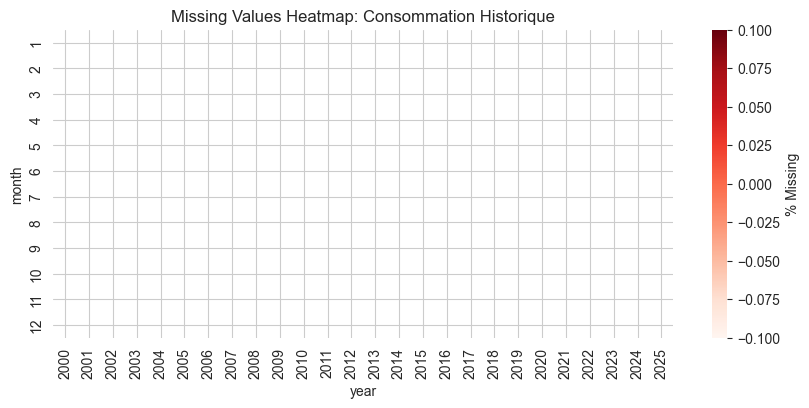


--- Temps Réel (YTD) (1 fichiers) ---
Lignes: 34,494 | Manquants: 0 (0.0000%)


C:\Users\dmarin\Dropbox\Pro\OpenDC\99 Projects\0146-TD Python - ENSAE\02 Work\99 Projets\2025\06_benchetrit_hossainhelal_kalfon\.venv\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\dmarin\Dropbox\Pro\OpenDC\99 Projects\0146-TD Python - ENSAE\02 Work\99 Projets\2025\06_benchetrit_hossainhelal_kalfon\.venv\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


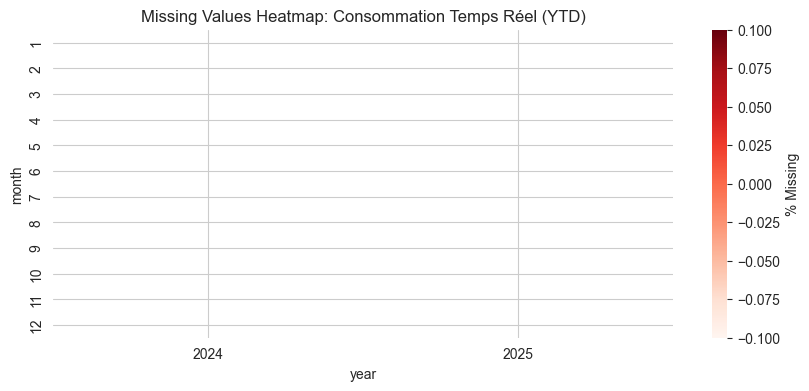

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import gc

def analyze_consumption_missing():
    print(">>> 1. ANALYSE MANQUANTS : CONSOMMATION")
    
    # Configuration des sources
    sources = [
        {"name": "Historique", "pattern": "../data/interim/consommation/consommation_*_long_utc.csv", "col_date": "datetime", "col_val": "load_mw"},
        {"name": "Temps Réel (YTD)", "pattern": "../data/interim/consommation/rte_consumption_realised_ytd_utc.csv", "col_date": "start_date", "col_val": "consumption_mw"}
    ]

    for src in sources:
        files = sorted(glob.glob(src["pattern"]))
        if not files: continue
        
        print(f"\n--- {src['name']} ({len(files)} fichiers) ---")
        
        # Chargement optimisé
        df_list = []
        for f in files:
            try:
                temp = pd.read_csv(f, usecols=[src['col_date'], src['col_val']])
                temp = temp.rename(columns={src['col_date']: 'ts', src['col_val']: 'val'})
                temp['ts'] = pd.to_datetime(temp['ts'], utc=True)
                df_list.append(temp)
            except Exception as e:
                print(f"Err {f}: {e}")

        if not df_list: continue
        df = pd.concat(df_list, ignore_index=True)

        # Stats
        missing = df['val'].isnull().sum()
        pct = (missing / len(df)) * 100
        print(f"Lignes: {len(df):,} | Manquants: {missing} ({pct:.4f}%)")

        # Heatmap
        if len(df) > 0:
            df['year'] = df['ts'].dt.year
            df['month'] = df['ts'].dt.month
            pivot = df.groupby(['year', 'month'])['val'].apply(lambda x: (x.isnull().sum()/len(x))*100).unstack(level=0)
            
            plt.figure(figsize=(10, 4))
            sns.heatmap(pivot, annot=True, fmt=".1f", cmap="Reds", mask=(pivot==0), cbar_kws={'label': '% Missing'})
            plt.title(f"Missing Values Heatmap: Consommation {src['name']}")
            plt.show()
        
        del df, df_list
        gc.collect()

analyze_consumption_missing()

### Consumption — Historical and near real-time

The consumption datasets exhibit **excellent completeness**.

For historical consumption (1996–2024, UTC-normalised):
- the key variable (`load_mw`) contains **no missing values**,
- the global missing rate is effectively **0.00%**,
- monthly heatmaps confirm the absence of localized missingness.

For near real-time (YTD) consumption:
- the realised API feed also shows **no missing values** in `consumption_mw`,
- missing timestamps observed elsewhere in the audit relate to **grid discontinuities**, not missing values.

**Interpretation:**  
Consumption data can be treated as **fully observed in value space**.  
Downstream cleaning focuses on **temporal continuity and segmentation** (e.g. exclusion of 2020 for modelling),
rather than value imputation.


>>> 2. ANALYSE MANQUANTS : PRODUCTION

--- Historique (10 fichiers) ---
Lignes: 1,064,422 | Manquants: 1108 (0.1041%)


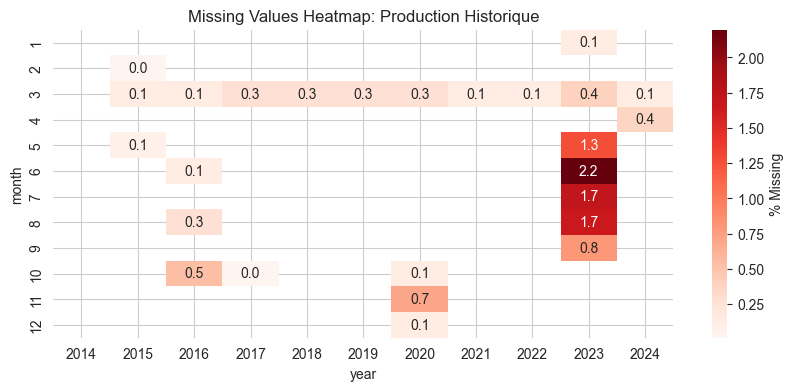


--- Temps Réel (YTD) (1 fichiers) ---
Lignes: 65,930 | Manquants: 0 (0.0000%)


C:\Users\dmarin\Dropbox\Pro\OpenDC\99 Projects\0146-TD Python - ENSAE\02 Work\99 Projets\2025\06_benchetrit_hossainhelal_kalfon\.venv\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\dmarin\Dropbox\Pro\OpenDC\99 Projects\0146-TD Python - ENSAE\02 Work\99 Projets\2025\06_benchetrit_hossainhelal_kalfon\.venv\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


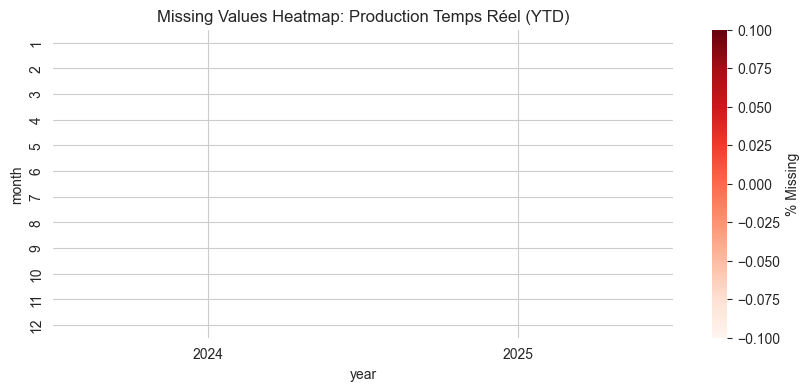

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import gc

def analyze_production_missing():
    print(">>> 2. ANALYSE MANQUANTS : PRODUCTION")
    
    sources = [
        {"name": "Historique", "pattern": "../data/interim/production/production_realisation_*_long_utc.csv", "col_date": "datetime", "col_val": "value_mw"},
        {"name": "Temps Réel (YTD)", "pattern": "../data/interim/production/rte_actual_generation_mix_*_utc.csv", "col_date": "start_date", "col_val": "value_mw"}
    ]

    for src in sources:
        files = sorted(glob.glob(src["pattern"]))
        if not files: continue
        
        print(f"\n--- {src['name']} ({len(files)} fichiers) ---")
        
        df_list = []
        for f in files:
            try:
                # Lecture header pour check colonnes
                cols = pd.read_csv(f, nrows=0).columns
                date_c = src['col_date'] if src['col_date'] in cols else 'datetime' # Fallback
                
                temp = pd.read_csv(f, usecols=[date_c, src['col_val']])
                temp = temp.rename(columns={date_c: 'ts', src['col_val']: 'val'})
                temp['ts'] = pd.to_datetime(temp['ts'], utc=True)
                df_list.append(temp)
            except Exception as e:
                pass # Ignorer fichiers vides/erronés

        if not df_list: continue
        df = pd.concat(df_list, ignore_index=True)

        # Stats
        missing = df['val'].isnull().sum()
        pct = (missing / len(df)) * 100
        print(f"Lignes: {len(df):,} | Manquants: {missing} ({pct:.4f}%)")

        # Heatmap
        if len(df) > 0:
            df['year'] = df['ts'].dt.year
            df['month'] = df['ts'].dt.month
            pivot = df.groupby(['year', 'month'])['val'].apply(lambda x: (x.isnull().sum()/len(x))*100).unstack(level=0)
            
            plt.figure(figsize=(10, 4))
            sns.heatmap(pivot, annot=True, fmt=".1f", cmap="Reds", mask=(pivot==0), cbar_kws={'label': '% Missing'})
            plt.title(f"Missing Values Heatmap: Production {src['name']}")
            plt.show()

        del df, df_list
        gc.collect()

analyze_production_missing()

### Production — Historical realised mix and near real-time

Production data shows a **more heterogeneous missingness profile**, reflecting both data complexity
and differences between historical archives and API feeds.

For historical realised production (long format, 2015–2024):
- the global missing rate in `value_mw` is **~0.10%**,
- missing values are **not uniformly distributed** over time,
- the heatmap reveals localized concentrations in specific months and years
  (notably around 2020–2023).

These missing values coexist with other known anomalies (e.g. negative values) and must be handled
explicitly when building aggregated indicators (by technology or total production).

For near real-time production (YTD, 15-min wind/solar):
- no missing values are observed in `value_mw`,
- data quality issues in this feed are primarily related to **missing timestamps** (coverage gaps),
  not missing values.

**Interpretation:**  
Historical production data requires **explicit missing-value handling** at the feature engineering stage
(e.g. filtering, aggregation rules, or targeted imputation if needed).  
Near real-time production values are complete when present, but coverage must be monitored separately.


>>> 3. ANALYSE MANQUANTS : MÉTÉO

--- Historique Météo (30 fichiers) ---
Lignes: 8,146,176 | Manquants: 1696 (0.0208%)


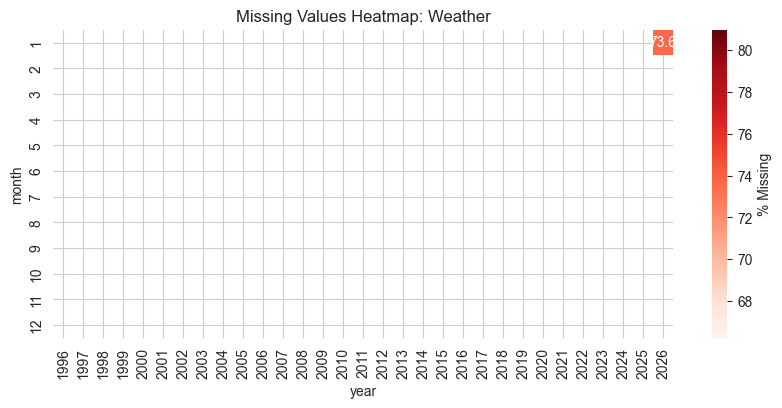

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import gc

def analyze_weather_missing():
    print(">>> 3. ANALYSE MANQUANTS : MÉTÉO")
    
    # On cible temperature_2m comme indicateur de santé du fichier
    pattern = "../data/raw/weather/weather_32_cities_*.csv"
    files = sorted(glob.glob(pattern))
    
    print(f"\n--- Historique Météo ({len(files)} fichiers) ---")
    
    df_list = []
    for f in files:
        try:
            # On charge uniquement date et temp
            temp = pd.read_csv(f, usecols=['date', 'temperature_2m'])
            temp['ts'] = pd.to_datetime(temp['date'], utc=True)
            temp = temp.rename(columns={'temperature_2m': 'val'})
            df_list.append(temp[['ts', 'val']])
        except Exception as e:
            print(f"Err {f}: {e}")

    if df_list:
        df = pd.concat(df_list, ignore_index=True)
        
        # Stats
        missing = df['val'].isnull().sum()
        pct = (missing / len(df)) * 100
        print(f"Lignes: {len(df):,} | Manquants: {missing} ({pct:.4f}%)")

        # Heatmap
        if len(df) > 0 and missing > 0: # On n'affiche la heatmap que s'il y a des manquants
            df['year'] = df['ts'].dt.year
            df['month'] = df['ts'].dt.month
            pivot = df.groupby(['year', 'month'])['val'].apply(lambda x: (x.isnull().sum()/len(x))*100).unstack(level=0)
            
            plt.figure(figsize=(10, 4))
            sns.heatmap(pivot, annot=True, fmt=".1f", cmap="Reds", mask=(pivot==0), cbar_kws={'label': '% Missing'})
            plt.title("Missing Values Heatmap: Weather")
            plt.show()
        elif missing == 0:
            print("✅ Aucun manquant détecté dans la météo (Intégrité parfaite).")

        del df, df_list
        gc.collect()

analyze_weather_missing()

### Weather — Historical archive

Weather data exhibits **very high overall integrity**, consistent with reanalysis-style products.

Across the full historical archive (32 cities, hourly):
- the missing rate for `temperature_2m` is **~0.02%**,
- missing values are rare but **not strictly zero**,
- the heatmap shows that missingness, when present, is **localized in time** rather than systemic.

Given the large volume of weather observations, these gaps represent a **negligible fraction**
of the dataset and do not compromise its role as a stable explanatory signal.

**Interpretation:**  
Weather data can be considered **structurally reliable**.  
Localized missing values can be safely handled during aggregation to the national level
(e.g. averaging across cities), without requiring aggressive imputation strategies.


### Summary and implications

The missing-value analysis highlights clear contrasts between domains:

- **Consumption:** fully observed in value space; no imputation required.
- **Weather:** near-complete, with negligible and localized missingness.
- **Production (historical):** small but non-negligible missing rate, requiring explicit handling.

These findings justify the project’s downstream choices. 


## 3.2 Outlier Detection

This section screens the datasets for **extreme or physically implausible values** that could bias
statistical analysis or degrade model training.  
The objective is **not** to mechanically remove statistical outliers, but to distinguish between:
- values that are **physically meaningful** (even if extreme),
- values that are **structural artefacts**,
- values that would require explicit correction or filtering.

The analysis is carried out separately for **consumption**, **production**, and **weather** using a
combination of **range checks** and **distributional diagnostics**.


>>> 3.2 OUTLIER DETECTION: CONSUMPTION


C:\Users\dmarin\AppData\Local\Temp\ipykernel_11444\3894735160.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(df_list, ignore_index=True)


count    457998.000000
mean      53382.142027
std       11538.160714
min       28545.000000
25%       44536.000000
50%       51935.000000
75%       61101.000000
max      102098.000000
Name: mw, dtype: object


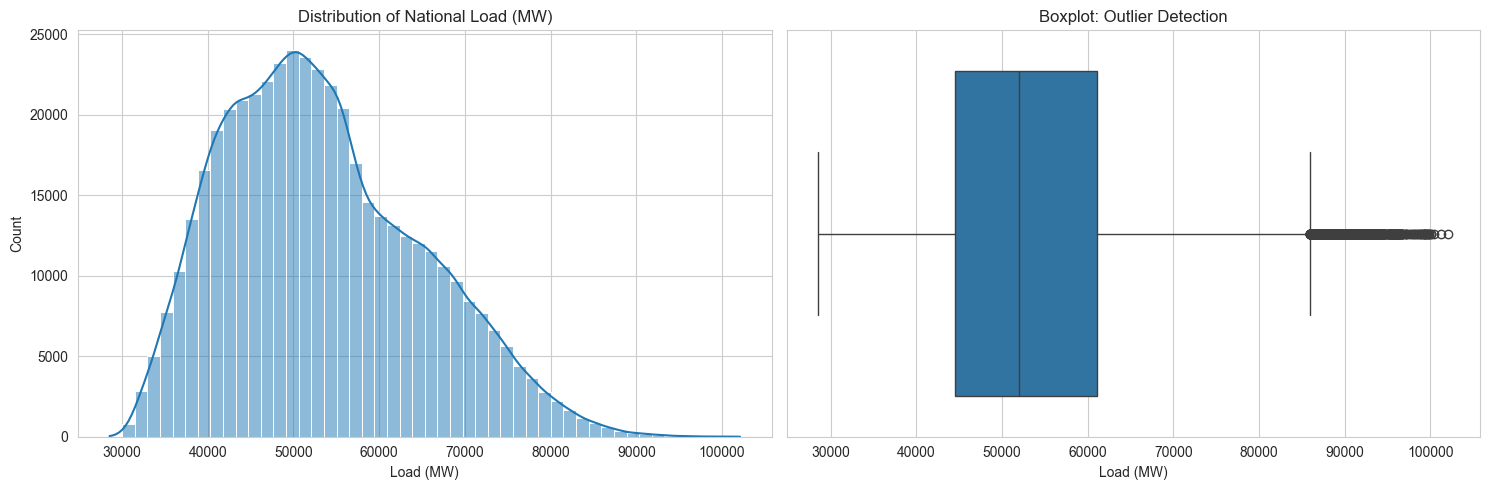

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import gc

def analyze_consumption_outliers():
    print(">>> 3.2 OUTLIER DETECTION: CONSUMPTION")
    
    # 1. Load Data (Historical + Real-Time)
    files = sorted(glob.glob("../data/interim/consommation/*_utc.csv"))
    if not files: return

    df_list = []
    for f in files:
        try:
            # Detect column names dynamically
            cols = pd.read_csv(f, nrows=0).columns
            val_col = 'load_mw' if 'load_mw' in cols else 'consumption_mw'
            date_col = 'datetime' if 'datetime' in cols else 'start_date'
            
            temp = pd.read_csv(f, usecols=[date_col, val_col])
            temp = temp.rename(columns={date_col: 'ts', val_col: 'mw'})
            df_list.append(temp)
        except: pass
    
    if not df_list: return
    df = pd.concat(df_list, ignore_index=True)
    
    # 2. Statistical Summary
    print(df['mw'].describe().apply(lambda x: format(x, 'f')))
    
    # 3. Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Histogram
    sns.histplot(df['mw'], bins=50, kde=True, ax=ax1, color='#1f77b4')
    ax1.set_title("Distribution of National Load (MW)")
    ax1.set_xlabel("Load (MW)")
    
    # Boxplot (To see extremes)
    sns.boxplot(x=df['mw'], ax=ax2, color='#1f77b4')
    ax2.set_title("Boxplot: Outlier Detection")
    ax2.set_xlabel("Load (MW)")
    
    plt.tight_layout()
    plt.show()
    
    # 4. Specific Checks
    zeros = df[df['mw'] <= 0]
    if len(zeros) > 0:
        print(f"⚠️ WARNING: Found {len(zeros)} non-positive load values!")
    
    del df, df_list
    gc.collect()

analyze_consumption_outliers()

### Consumption Outliers

The national load distribution is unimodal and right-skewed, consistent with long-term demand growth
and winter peak effects.

- No negative or zero values are observed.
- The lower tail corresponds to early years (late 1990s), which is consistent with historical demand levels.
- The upper tail (above ~90 GW) corresponds to rare winter peak events and is physically plausible.

**Conclusion:**  
No consumption values are flagged as anomalous. All observed extremes are consistent with system history and are retained.


>>> 3.2 OUTLIER DETECTION: PRODUCTION


C:\Users\dmarin\AppData\Local\Temp\ipykernel_11444\1858316978.py:27: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=df, y='technology', x='value_mw', scale='width', orient='h')


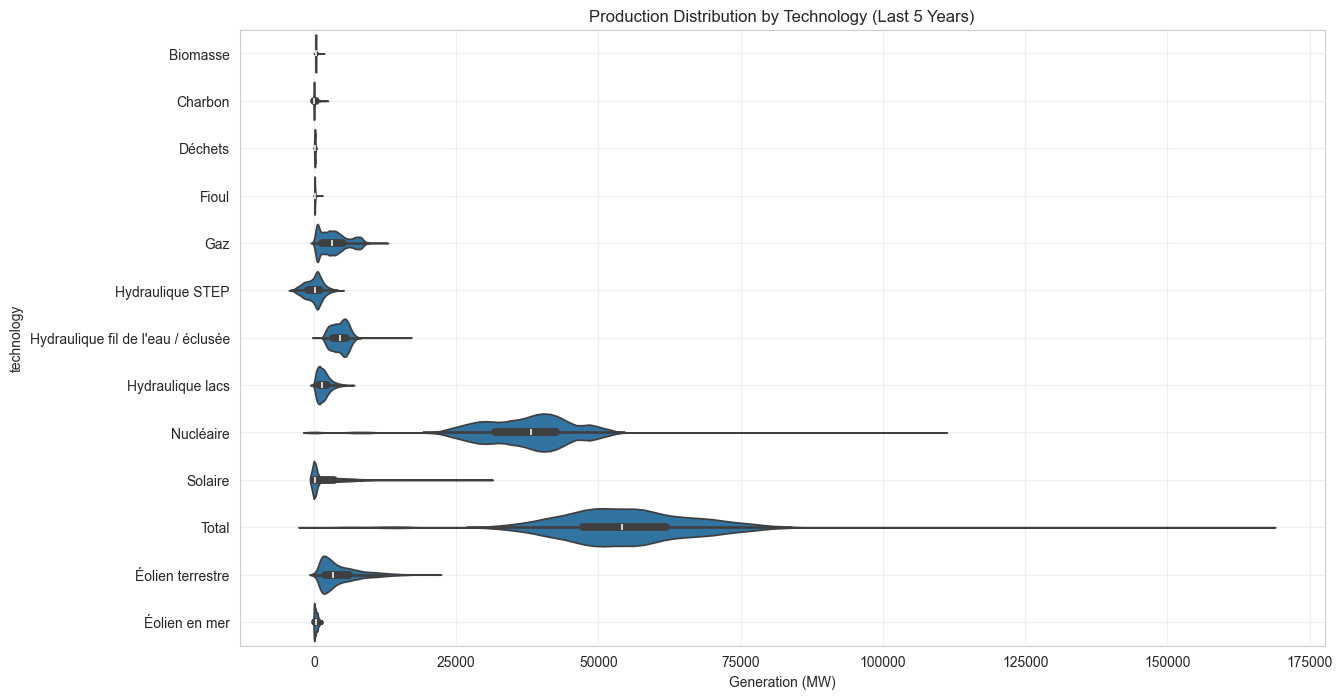


--- Negative Values Check ---
technology
Hydraulique STEP    19541
Charbon               865
Hydraulique lacs      175
Éolien en mer          10
Name: count, dtype: int64
(Note: 'Hydraulique STEP' < 0 is NORMAL (Pumping). Others are anomalies.)


In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import gc

def analyze_production_outliers():
    print(">>> 3.2 OUTLIER DETECTION: PRODUCTION")
    
    # 1. Load Data (Historical only is usually enough for distribution)
    files = sorted(glob.glob("../data/interim/production/production_realisation_*_long_utc.csv"))
    if not files: return

    # Load subset to save RAM (e.g. last 5 years or all if possible)
    df_list = []
    for f in files[-5:]: # Analyzing last 5 years for clearer view
        try:
            temp = pd.read_csv(f, usecols=['technology', 'value_mw'])
            df_list.append(temp)
        except: pass
        
    if not df_list: return
    df = pd.concat(df_list, ignore_index=True)
    
    # 2. Visualization: Violin Plot (Distribution per Tech)
    plt.figure(figsize=(14, 8))
    sns.violinplot(data=df, y='technology', x='value_mw', scale='width', orient='h')
    
    plt.title("Production Distribution by Technology (Last 5 Years)")
    plt.xlabel("Generation (MW)")
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # 3. Negative Value Check (Crucial for Data Quality)
    print("\n--- Negative Values Check ---")
    negatives = df[df['value_mw'] < 0]
    if not negatives.empty:
        print(negatives['technology'].value_counts())
        print("(Note: 'Hydraulique STEP' < 0 is NORMAL (Pumping). Others are anomalies.)")
    else:
        print("✅ No negative values found.")

    del df, df_list
    gc.collect()

analyze_production_outliers()

### Production Outliers

Production distributions are analyzed by technology over recent years.

Key findings:
- **Hydraulique STEP** exhibits frequent negative values, corresponding to pumping phases.
  This behavior is physically correct and expected.
- Small numbers of negative values appear in other technologies (e.g. coal, hydro lakes, offshore wind).
  These occurrences are rare and likely related to reporting or balancing adjustments rather than measurement errors.
- Nuclear, wind, and solar distributions are coherent with their respective operating constraints.

**Conclusion:**  
No systematic production anomaly is detected. Negative values are retained where physically meaningful
(STEP), and no aggressive filtering is applied at this stage.


>>> 3.2 OUTLIER DETECTION: WEATHER
Analyzing representative file: ../data/raw/weather\weather_32_cities_historical_2014.csv


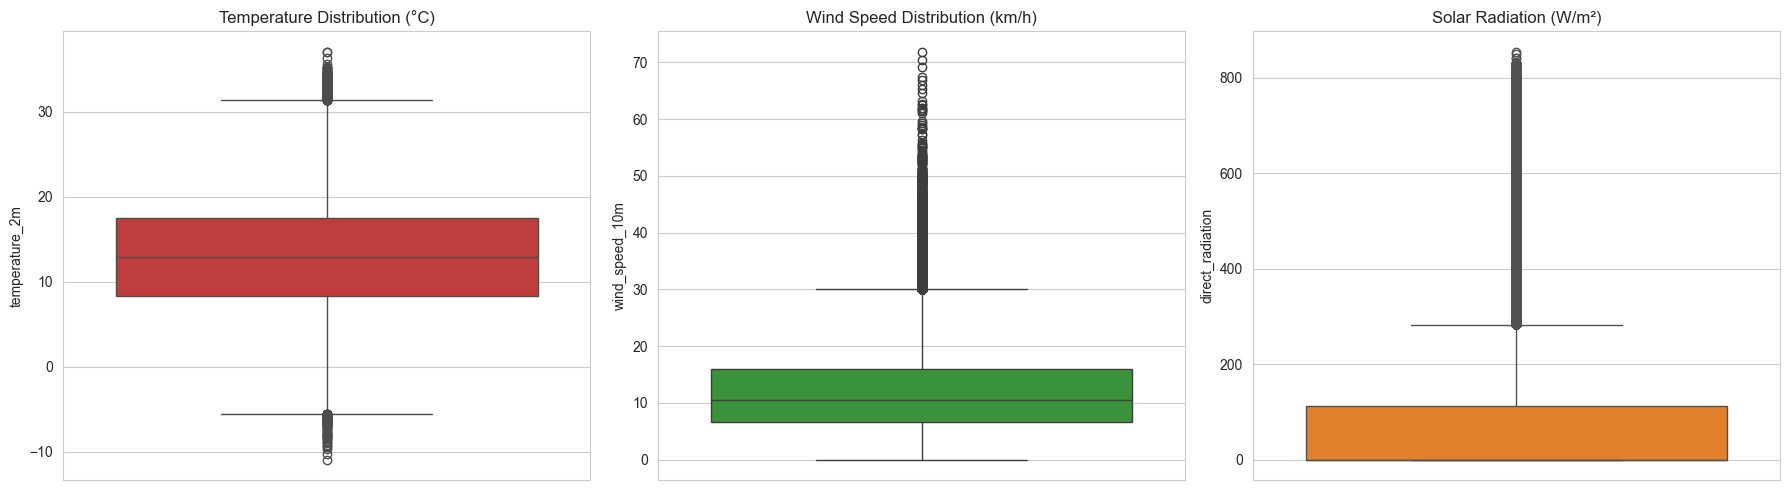

Temp Range: -11.0°C to 37.0°C


In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import gc

def analyze_weather_outliers():
    print(">>> 3.2 OUTLIER DETECTION: WEATHER")
    
    # 1. Load Data
    files = sorted(glob.glob("../data/raw/weather/weather_32_cities_*.csv"))
    if not files: return
    
    # We load just one representative file (e.g., 2023) or all if needed. 
    # Let's load the most recent full year to check modern outliers.
    f = files[-2] if len(files) > 1 else files[0]
    print(f"Analyzing representative file: {f}")
    
    try:
        df = pd.read_csv(f, usecols=['temperature_2m', 'wind_speed_10m', 'direct_radiation'])
        
        # 2. Visual Check
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # Temperature
        sns.boxplot(y=df['temperature_2m'], ax=axes[0], color='#d62728')
        axes[0].set_title("Temperature Distribution (°C)")
        
        # Wind
        sns.boxplot(y=df['wind_speed_10m'], ax=axes[1], color='#2ca02c')
        axes[1].set_title("Wind Speed Distribution (km/h)")
        
        # Solar
        sns.boxplot(y=df['direct_radiation'], ax=axes[2], color='#ff7f0e')
        axes[2].set_title("Solar Radiation (W/m²)")
        
        plt.tight_layout()
        plt.show()
        
        # 3. Range Check
        print(f"Temp Range: {df['temperature_2m'].min():.1f}°C to {df['temperature_2m'].max():.1f}°C")
        if df['temperature_2m'].max() > 50 or df['temperature_2m'].min() < -30:
            print("⚠️ WARNING: Extreme temperatures detected!")
            
    except Exception as e:
        print(f"Error: {e}")

    del df
    gc.collect()

analyze_weather_outliers()

### Weather Outliers

Weather distributions are inspected on a representative full historical year.

Observed ranges:
- **Temperature:** approximately -11°C to +37°C.
- **Wind speed:** positive, with a long right tail corresponding to storm events.
- **Solar radiation:** zero at night and bounded during daytime peaks.

All values fall within plausible meteorological limits for metropolitan France.

**Conclusion:**  
No weather outliers are detected. The weather data is considered physically consistent and suitable
for direct use in feature engineering.


### Global Conclusion

No critical outliers are identified across consumption, production, or weather datasets.
All extreme values observed correspond to **valid physical phenomena** rather than data errors.

As a result:
- No hard clipping or outlier removal is applied.
- Variability in the tails is preserved to allow the model to learn rare but structurally important events
(e.g. cold spells, peak demand, high renewable output).


## 3.3 Known Event Windows — COVID-19 Shock

This section focuses on **known exogenous events** that induce structural breaks in electricity consumption.
Such events are not random anomalies but reflect abrupt changes in economic and social activity that
cannot be explained by weather or calendar effects alone.

The COVID-19 pandemic represents the most significant disruption in the historical load series and
must be explicitly identified during exploratory analysis.


### Methodology

To isolate the COVID-19 impact, national electricity consumption in **2020** is compared to a
**reference year without shock (2019)** over the same calendar window.

Key methodological choices:
- Data are **UTC-aligned** and resampled to **daily mean load** to reduce intra-day noise.
- The comparison window spans **March to May**, covering:
  - the pre-lockdown phase,
  - the first national lockdown in France,
  - the early recovery phase.
- Lockdown boundaries are explicitly marked:
  - **Start:** March 17, 2020 (≈ DOY 77),
  - **End:** May 11, 2020 (≈ DOY 132).


>>> 3.3 KNOWN EVENTS: INSPECTING COVID SHOCK


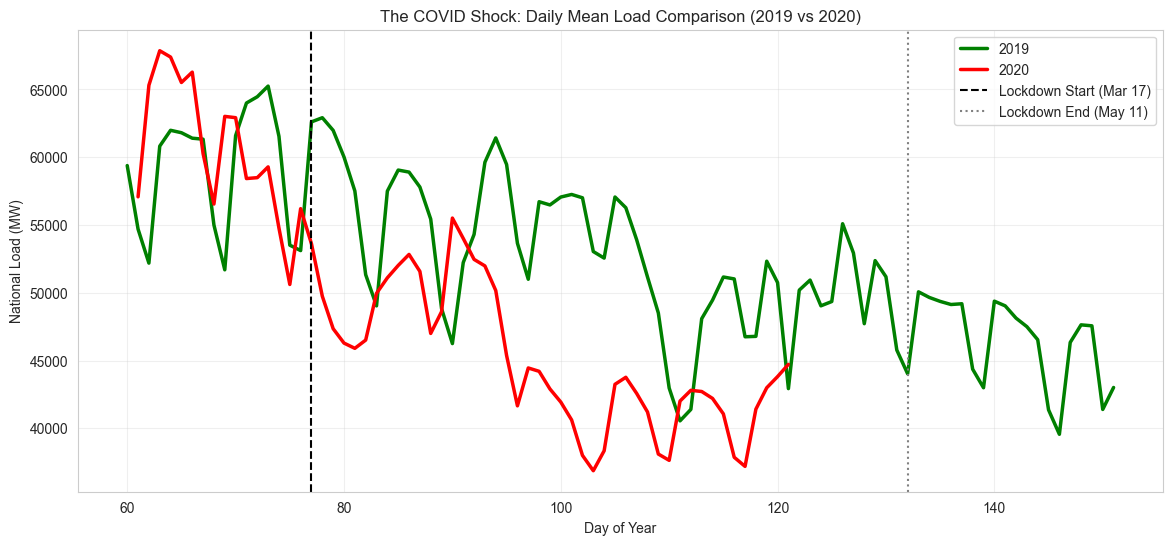

--- Impact Analysis (April Average) ---
2019 Load: 52,336 MW
2020 Load: 42,399 MW
Destruction: -9,936 MW (-18.99%)
CONCLUSION: This period represents a structural break and must be flagged or excluded.


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

def inspect_covid_shock():
    print(">>> 3.3 KNOWN EVENTS: INSPECTING COVID SHOCK")

    # 1. Load 2019 (Ref) and 2020 (Shock)
    files = [
        "../data/interim/consommation/consommation_2019_long_utc.csv",
        "../data/interim/consommation/consommation_2020_long_utc.csv"
    ]
    
    df_list = []
    for f in files:
        try:
            temp = pd.read_csv(f)
            # Handle potential column name variations
            date_col = 'datetime' if 'datetime' in temp.columns else 'start_date'
            val_col = 'load_mw' if 'load_mw' in temp.columns else 'consumption_mw'
            
            temp = temp[[date_col, val_col]].rename(columns={date_col: 'ts', val_col: 'mw'})
            temp['ts'] = pd.to_datetime(temp['ts'], utc=True)
            df_list.append(temp)
        except Exception as e:
            print(f"Error loading {f}: {e}")
            return

    df = pd.concat(df_list)
    
    # 2. Filter for the First Lockdown Window (Spring)
    # Lockdown 1 France: March 17 - May 11, 2020
    # We take a slightly wider window to see the "Before" and "After"
    start_date = "03-01"
    end_date = "06-01"
    
    # Extract Day of Year for alignment
    df['doy'] = df['ts'].dt.dayofyear
    df['year'] = df['ts'].dt.year
    
    # Filter restricted window (Day of year approx 60 to 153)
    # 2020 is a leap year, so we align loosely on DOY
    mask = (df['ts'].dt.month >= 3) & (df['ts'].dt.month <= 5)
    df_zoom = df[mask].copy()
    
    # 3. Visualization
    plt.figure(figsize=(14, 6))
    
    # Pivot for plotting: Index=DOY, Columns=Year
    # We resample to Daily Mean to clear up the noise
    daily = df_zoom.groupby(['year', 'doy'])['mw'].mean().reset_index()
    
    sns.lineplot(data=daily, x='doy', y='mw', hue='year', palette={2019: 'green', 2020: 'red'}, linewidth=2.5)
    
    # Annotation for Lockdown Start
    # March 17 is approx DOY 77
    plt.axvline(x=77, color='black', linestyle='--', label='Lockdown Start (Mar 17)')
    plt.axvline(x=132, color='gray', linestyle=':', label='Lockdown End (May 11)')
    
    plt.title("The COVID Shock: Daily Mean Load Comparison (2019 vs 2020)")
    plt.ylabel("National Load (MW)")
    plt.xlabel("Day of Year")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # 4. Quantify the Drop
    # Compare average load during the core lockdown (April)
    april_2019 = daily[(daily['year']==2019) & (daily['doy'] >= 92) & (daily['doy'] <= 120)]['mw'].mean()
    april_2020 = daily[(daily['year']==2020) & (daily['doy'] >= 92) & (daily['doy'] <= 120)]['mw'].mean()
    
    drop_mw = april_2019 - april_2020
    drop_pct = (drop_mw / april_2019) * 100
    
    print(f"--- Impact Analysis (April Average) ---")
    print(f"2019 Load: {april_2019:,.0f} MW")
    print(f"2020 Load: {april_2020:,.0f} MW")
    print(f"Destruction: -{drop_mw:,.0f} MW (-{drop_pct:.2f}%)")
    print("CONCLUSION: This period represents a structural break and must be flagged or excluded.")

inspect_covid_shock()

### Visual Evidence of the Structural Break

The comparison reveals a **clear divergence** between 2019 and 2020 immediately after the lockdown start.

Observed patterns:
- Prior to mid-March, both years follow comparable demand levels.
- From late March onward, 2020 consumption drops sharply and remains durably below 2019.
- The gap persists throughout April, well beyond short-term adjustment effects.

This behavior cannot be attributed to weather or seasonality alone and reflects a
sudden collapse in industrial, commercial, and mobility-related demand.


### Quantification of the Impact

The impact is quantified by comparing **average daily load in April**:

- **April 2019:** 52,336 MW  
- **April 2020:** 42,399 MW  

This corresponds to:
- **Absolute drop:** −9,936 MW  
- **Relative drop:** −18.99%

Such a magnitude is unprecedented in the historical series and confirms the presence
of a **major structural break**.


### Implications for Modeling

**Modeling decision:**
- The year **2020 must be explicitly flagged or excluded** from baseline training datasets.
- This treatment prevents the model from learning spurious relationships and preserves
generalization to normal operating conditions.

This choice is consistent with the later data-cleaning and train/validation/test split strategy.


# Part A — Consumption (demand side)


# 4. National electricity load: global behavior


### 4.1 Long-term trend

This section examines the long-run evolution of French national electricity demand
from 1996 to the present.

Daily aggregation is used to smooth high-frequency noise. Two rolling averages
are computed:
- a 30-day moving average to highlight seasonal dynamics,
- a 365-day moving average to extract the structural trend.


>>> 4.1 LONG-TERM TREND ANALYSIS
Loading and downsampling 30 files to Daily frequency...


C:\Users\dmarin\AppData\Local\Temp\ipykernel_11444\1847006096.py:47: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df_daily = pd.concat(daily_chunks)


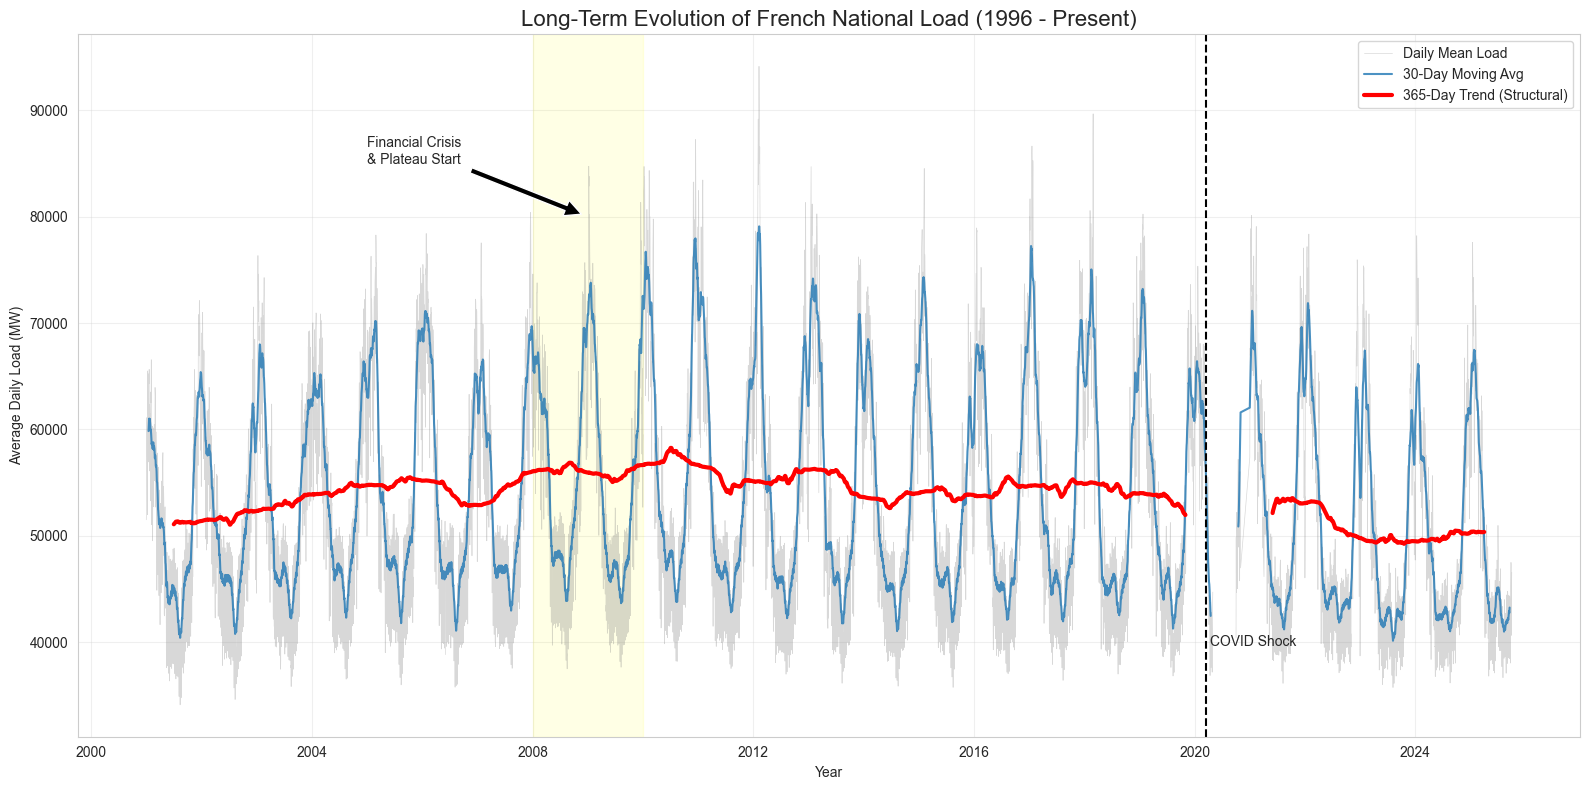

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

def analyze_long_term_trend():
    print(">>> 4.1 LONG-TERM TREND ANALYSIS")
    
    # Pattern for historical UTC files
    files = sorted(glob.glob("../data/interim/consommation/consommation_*_long_utc.csv"))
    
    if not files:
        print("No historical consumption files found.")
        return

    print(f"Loading and downsampling {len(files)} files to Daily frequency...")
    
    daily_chunks = []
    
    for f in files:
        try:
            # 1. Load only necessary columns
            # Handle variable column names if necessary (based on previous audits)
            cols = pd.read_csv(f, nrows=0).columns
            date_col = 'datetime' if 'datetime' in cols else 'start_date'
            val_col = 'load_mw' if 'load_mw' in cols else 'consumption_mw'
            
            df_temp = pd.read_csv(f, usecols=[date_col, val_col])
            
            # 2. Convert to UTC and set index
            df_temp[date_col] = pd.to_datetime(df_temp[date_col], utc=True)
            df_temp = df_temp.set_index(date_col).sort_index()
            
            # 3. Downsample to DAILY Mean immediately (Save RAM)
            # We assume 'load_mw' is power (MW), so mean() preserves the load profile level.
            # If it were energy (MWh), sum() would be appropriate, but here it's Load.
            daily_agg = df_temp[val_col].resample('D').mean()
            
            daily_chunks.append(daily_agg)
            
        except Exception as e:
            print(f"Skipping {os.path.basename(f)}: {e}")

    # 4. Combine all years
    if not daily_chunks: return
    df_daily = pd.concat(daily_chunks)
    df_daily = df_daily.sort_index()
    
    # 5. Compute Rolling Averages
    # 30-Day: Shows seasonality clearly
    # 365-Day: Shows the structural Trend (removes seasonality)
    df_daily_ma30 = df_daily.rolling(window=30, center=True).mean()
    df_daily_ma365 = df_daily.rolling(window=365, center=True).mean()
    
    # 6. Visualization
    plt.figure(figsize=(16, 8))
    
    # Raw Daily Data (Light gray, background)
    plt.plot(df_daily.index, df_daily, color='gray', alpha=0.3, linewidth=0.5, label='Daily Mean Load')
    
    # 30-Day Trend (Seasonality)
    plt.plot(df_daily_ma30.index, df_daily_ma30, color='#1f77b4', linewidth=1.5, alpha=0.8, label='30-Day Moving Avg')
    
    # 365-Day Trend (Long Term)
    plt.plot(df_daily_ma365.index, df_daily_ma365, color='red', linewidth=3, label='365-Day Trend (Structural)')
    
    plt.title("Long-Term Evolution of French National Load (1996 - Present)", fontsize=16)
    plt.ylabel("Average Daily Load (MW)")
    plt.xlabel("Year")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Highlight Key Eras
    plt.axvspan(pd.Timestamp('2008-01-01', tz='UTC'), pd.Timestamp('2010-01-01', tz='UTC'), color='yellow', alpha=0.1)
    plt.annotate('Financial Crisis\n& Plateau Start', xy=(pd.Timestamp('2009-01-01', tz='UTC'), 80000), 
                 xytext=(pd.Timestamp('2005-01-01', tz='UTC'), 85000),
                 arrowprops=dict(facecolor='black', shrink=0.05))
                 
    plt.axvline(x=pd.Timestamp('2020-03-17', tz='UTC'), color='black', linestyle='--')
    plt.text(pd.Timestamp('2020-03-17', tz='UTC'), 40000, " COVID Shock", verticalalignment='center')
    
    plt.tight_layout()
    plt.show()

analyze_long_term_trend()


The analysis reveals a clear non-stationary behavior, with:
- sustained growth until the late 2000s,
- a plateau following the 2008–2009 financial crisis,
- a sharp structural break during the COVID-19 shock in 2020.


### 4.2 Load distribution and tails

This subsection analyzes the empirical distribution of national electricity load using high-frequency data to preserve extreme values.


>>> 4.2 LOAD DISTRIBUTION & TAILS
Loading 30 files for distribution analysis...


C:\Users\dmarin\AppData\Local\Temp\ipykernel_11444\4237738095.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(df_list, ignore_index=True)



--- Load Quantiles (MW) ---
0.01    33453.00
0.05    37116.00
0.25    44839.00
0.50    52287.00
0.75    61440.00
0.95    74750.00
0.99    82435.97
Name: mw, dtype: float64


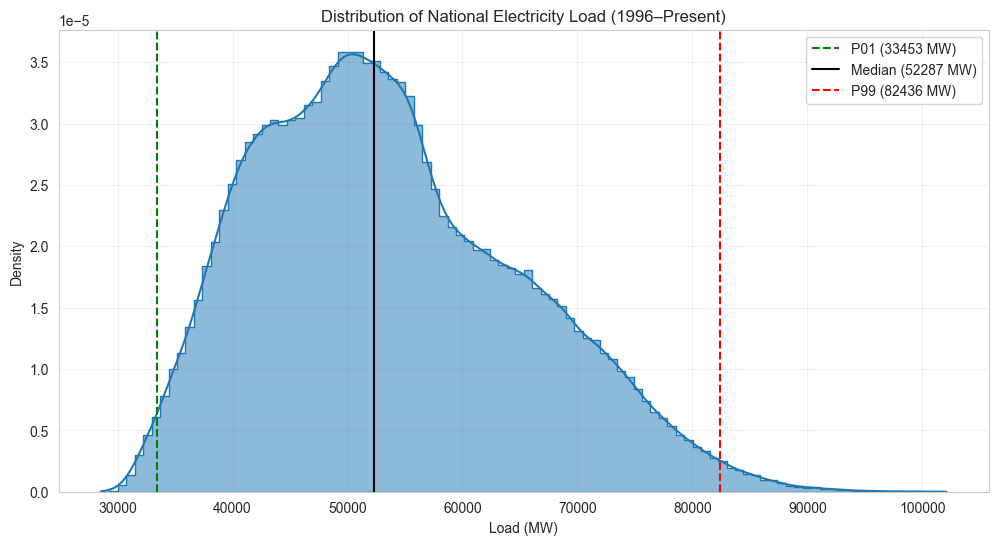


--- TOP 10 EXTREME DEMAND DAYS (Historical Peaks) ---
DATE            | MAX LOAD (MW)  
-----------------------------------
2012-02-08      | 102,098
2012-02-07      | 100,430
2012-02-09      | 99,420
2010-12-15      | 96,710
2012-02-10      | 96,698
2018-02-28      | 96,609
2012-02-06      | 96,115
2012-02-02      | 95,975
2012-02-03      | 95,856
2018-02-27      | 94,631


In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import gc

def analyze_load_distribution():
    print(">>> 4.2 LOAD DISTRIBUTION & TAILS")
    
    # 1. Load Data (Optimized)
    # Matching pattern from context
    files = sorted(glob.glob("../data/interim/consommation/consommation_*_long_utc.csv"))
    
    if not files:
        print("No files found.")
        return

    df_list = []
    print(f"Loading {len(files)} files for distribution analysis...")
    
    for f in files:
        try:
            # Detect cols dynamically
            cols = pd.read_csv(f, nrows=0).columns
            val_col = 'load_mw' if 'load_mw' in cols else 'consumption_mw'
            date_col = 'datetime' if 'datetime' in cols else 'start_date'
            
            # Load raw 30-min data (distribution requires high freq)
            temp = pd.read_csv(f, usecols=[date_col, val_col])
            temp = temp.rename(columns={val_col: 'mw', date_col: 'ts'})
            df_list.append(temp)
        except: pass

    if not df_list: return
    df = pd.concat(df_list, ignore_index=True)
    df['ts'] = pd.to_datetime(df['ts'], utc=True)

    # 2. Quantile Statistics
    quantiles = df['mw'].quantile([0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99])
    print("\n--- Load Quantiles (MW) ---")
    print(quantiles)
    
    # 3. Visualization: Histogram & Density
    plt.figure(figsize=(12, 6))
    sns.histplot(df['mw'], bins=100, kde=True, color='#1f77b4', stat="density", element="step")
    
    # Add vertical lines for quantiles
    plt.axvline(quantiles[0.01], color='green', linestyle='--', label=f'P01 ({quantiles[0.01]:.0f} MW)')
    plt.axvline(quantiles[0.50], color='black', linestyle='-', label=f'Median ({quantiles[0.50]:.0f} MW)')
    plt.axvline(quantiles[0.99], color='red', linestyle='--', label=f'P99 ({quantiles[0.99]:.0f} MW)')
    
    plt.title("Distribution of National Electricity Load (1996–Present)")
    plt.xlabel("Load (MW)")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # 4. Extreme Demand Days (The "Right Tail")
    # We aggregate by Day to find the dates with the highest peak
    df['date'] = df['ts'].dt.date
    daily_max = df.groupby('date')['mw'].max().reset_index()
    top_10_days = daily_max.sort_values('mw', ascending=False).head(10)

    print("\n--- TOP 10 EXTREME DEMAND DAYS (Historical Peaks) ---")
    print(f"{'DATE':<15} | {'MAX LOAD (MW)':<15}")
    print("-" * 35)
    for _, row in top_10_days.iterrows():
        print(f"{row['date'].strftime('%Y-%m-%d'):<15} | {row['mw']:,.0f}")
        
    # Cleanup
    del df, df_list, daily_max
    gc.collect()

analyze_load_distribution()


The distribution is asymmetric with a pronounced right tail, reflecting peak
demand situations during cold spells.

Key statistics include:
- central tendency (median load),
- lower and upper quantiles (P01, P99),
- identification of historical extreme demand days.

These extremes are critical for assessing system stress and capacity adequacy.


# 5. Intra-day and intra-week patterns (load)


## 5.1 Daily profile

This subsection characterizes the average intra-day electricity demand pattern
using historical load data aggregated by hour (UTC).

>>> 5.1 INTRA-DAY PATTERNS: DAILY PROFILE
Aggregating 30 years of data...


C:\Users\dmarin\AppData\Local\Temp\ipykernel_11444\602842357.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat(df_list)


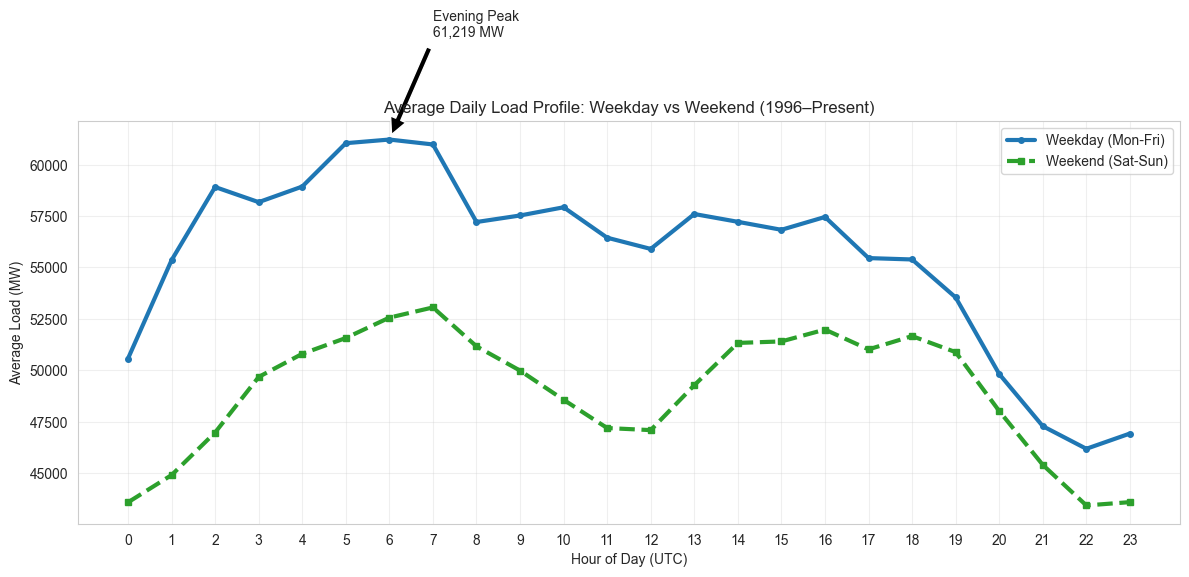

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import gc

def analyze_daily_profile():
    print(">>> 5.1 INTRA-DAY PATTERNS: DAILY PROFILE")
    
    # 1. Load Data (Historical Consumption)
    files = sorted(glob.glob("../data/interim/consommation/consommation_*_long_utc.csv"))
    if not files: return

    print(f"Aggregating {len(files)} years of data...")
    
    df_list = []
    for f in files:
        try:
            # Lecture optimisée : on ne charge que les colonnes nécessaires
            cols = pd.read_csv(f, nrows=0).columns
            date_col = 'datetime' if 'datetime' in cols else 'start_date'
            val_col = 'load_mw' if 'load_mw' in cols else 'consumption_mw'
            
            # On charge uniquement date et valeur
            temp = pd.read_csv(f, usecols=[date_col, val_col])
            temp = temp.rename(columns={date_col: 'ts', val_col: 'mw'})
            temp['ts'] = pd.to_datetime(temp['ts'], utc=True)
            
            # 2. Extraction des features immédiate (Hour + DayType)
            temp['hour'] = temp['ts'].dt.hour
            temp['dayofweek'] = temp['ts'].dt.dayofweek # 0=Lundi, 6=Dimanche
            
            # 3. Pré-agrégation par fichier pour économiser la RAM
            # On groupe tout de suite par (Weekend/Semaine, Heure)
            temp['day_type'] = temp['dayofweek'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')
            agg = temp.groupby(['day_type', 'hour'])['mw'].mean().reset_index()
            
            df_list.append(agg)
            
        except Exception as e:
            print(f"Skipping {f}: {e}")

    if not df_list: return
    
    # 4. Agrégation Finale (Moyenne des moyennes annuelles)
    df_all = pd.concat(df_list)
    final_profile = df_all.groupby(['day_type', 'hour'])['mw'].mean().reset_index()
    
    # 5. Visualisation
    plt.figure(figsize=(12, 6))
    
    # Courbe Semaine (Weekday)
    wd_data = final_profile[final_profile['day_type'] == 'Weekday']
    plt.plot(wd_data['hour'], wd_data['mw'], label='Weekday (Mon-Fri)', 
             color='#1f77b4', linewidth=3, marker='o', markersize=4)
    
    # Courbe Week-end (Weekend)
    we_data = final_profile[final_profile['day_type'] == 'Weekend']
    plt.plot(we_data['hour'], we_data['mw'], label='Weekend (Sat-Sun)', 
             color='#2ca02c', linewidth=3, linestyle='--', marker='s', markersize=4)
    
    plt.title("Average Daily Load Profile: Weekday vs Weekend (1996–Present)")
    plt.xlabel("Hour of Day (UTC)")
    plt.ylabel("Average Load (MW)")
    plt.xticks(range(0, 24))
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Annotation du Pic
    peak_wd = wd_data.loc[wd_data['mw'].idxmax()]
    plt.annotate(f"Evening Peak\n{peak_wd['mw']:,.0f} MW", 
                 xy=(peak_wd['hour'], peak_wd['mw']), 
                 xytext=(peak_wd['hour']+1, peak_wd['mw']+5000),
                 arrowprops=dict(facecolor='black', shrink=0.05))
    
    plt.tight_layout()
    plt.show()

    # Nettoyage mémoire
    del df_all, df_list, final_profile
    gc.collect()

analyze_daily_profile()

The analysis highlights:
- a strong morning ramp-up driven by residential and economic activity,
- a pronounced evening peak on weekdays,
- systematically lower and flatter profiles during weekends.

The weekday–weekend contrast confirms the dominant role of human activity
and working schedules in shaping short-term demand dynamics.

## 5.2 Weekly structure

This subsection analyzes demand variability across the days of the week.

>>> 5.2 WEEKLY STRUCTURE ANALYSIS
Aggregating 30 years of data...


C:\Users\dmarin\AppData\Local\Temp\ipykernel_11444\926996547.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat(df_list)
C:\Users\dmarin\AppData\Local\Temp\ipykernel_11444\926996547.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=daily_means.index.map(days), y=daily_means.values, ax=ax1, palette="viridis")


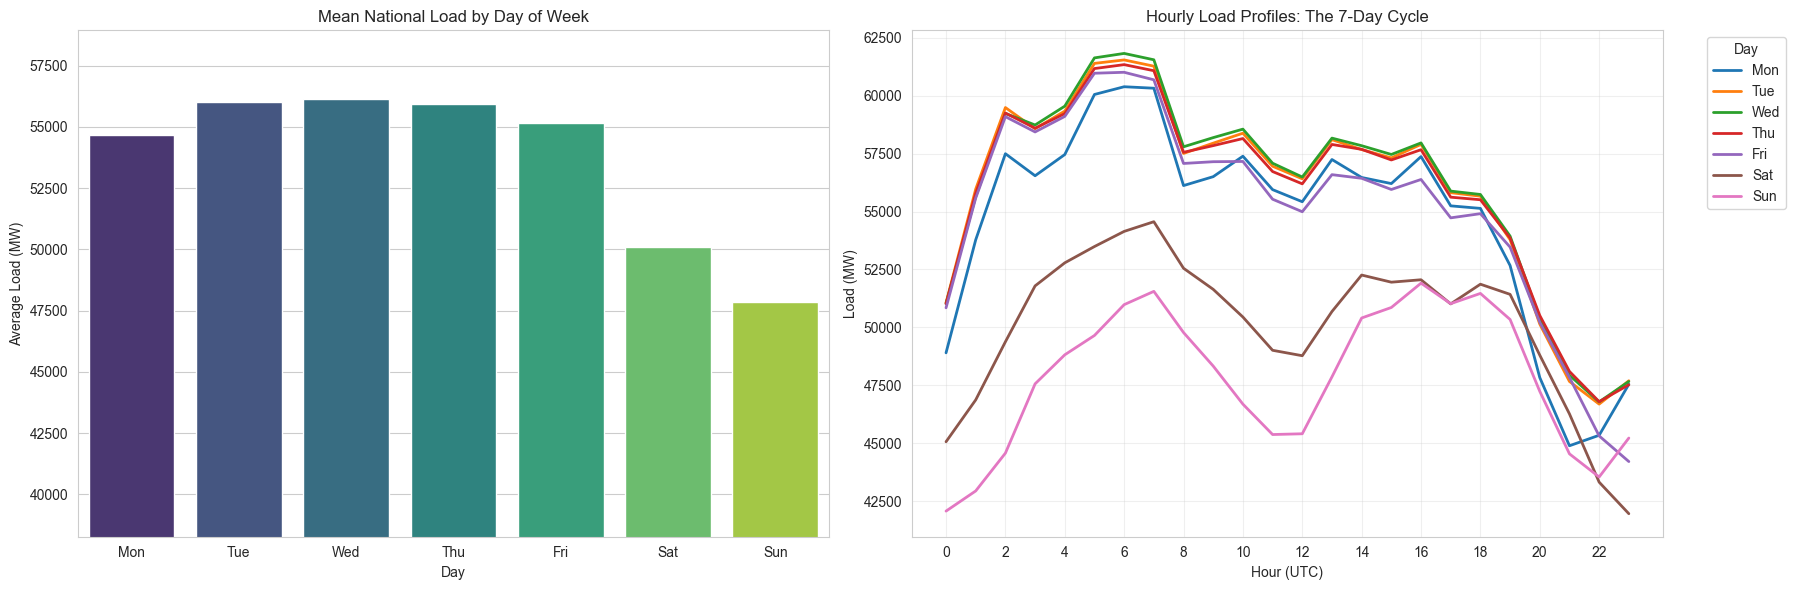

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import gc

def analyze_weekly_structure():
    print(">>> 5.2 WEEKLY STRUCTURE ANALYSIS")
    
    # 1. Load Data
    files = sorted(glob.glob("../data/interim/consommation/consommation_*_long_utc.csv"))
    if not files: return

    print(f"Aggregating {len(files)} years of data...")
    
    df_list = []
    for f in files:
        try:
            # Load subset
            cols = pd.read_csv(f, nrows=0).columns
            date_col = 'datetime' if 'datetime' in cols else 'start_date'
            val_col = 'load_mw' if 'load_mw' in cols else 'consumption_mw'
            
            temp = pd.read_csv(f, usecols=[date_col, val_col])
            temp = temp.rename(columns={date_col: 'ts', val_col: 'mw'})
            temp['ts'] = pd.to_datetime(temp['ts'], utc=True)
            
            # Extract features
            temp['dow'] = temp['ts'].dt.dayofweek # 0=Mon, 6=Sun
            temp['hour'] = temp['ts'].dt.hour
            
            # Aggregation: Mean load per (DayOfWeek, Hour)
            agg = temp.groupby(['dow', 'hour'])['mw'].mean().reset_index()
            df_list.append(agg)
            
        except Exception as e:
            print(f"Skipping {f}: {e}")

    if not df_list: return
    
    # 2. Final Aggregation
    df_all = pd.concat(df_list)
    # Average of averages (sufficient for profile shape)
    weekly_profile = df_all.groupby(['dow', 'hour'])['mw'].mean().reset_index()
    
    # Map Day Names for plotting
    days = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
    weekly_profile['day_name'] = weekly_profile['dow'].map(days)
    
    # 3. Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # Plot A: Average Load by Day of Week (Bar Chart)
    # We group by DOW only
    daily_means = weekly_profile.groupby('dow')['mw'].mean()
    sns.barplot(x=daily_means.index.map(days), y=daily_means.values, ax=ax1, palette="viridis")
    ax1.set_title("Mean National Load by Day of Week")
    ax1.set_ylabel("Average Load (MW)")
    ax1.set_xlabel("Day")
    ax1.set_ylim(bottom=min(daily_means.values)*0.8) # Zoom in to see difference
    
    # Plot B: Hourly Profile by Day (7 Lines)
    # We pivot for easier plotting
    sns.lineplot(data=weekly_profile, x='hour', y='mw', hue='day_name', 
                 palette='tab10', linewidth=2, ax=ax2)
    
    ax2.set_title("Hourly Load Profiles: The 7-Day Cycle")
    ax2.set_ylabel("Load (MW)")
    ax2.set_xlabel("Hour (UTC)")
    ax2.set_xticks(range(0, 24, 2))
    ax2.grid(True, alpha=0.3)
    ax2.legend(title="Day", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

    # Cleanup
    del df_all, df_list, weekly_profile
    gc.collect()

analyze_weekly_structure()

Key observations:
- average load is highest from Tuesday to Thursday,
- Friday shows a slight decline,
- a marked demand drop occurs during weekends, especially on Sunday.

Hourly profiles by weekday reveal a stable weekly cycle with consistent
timing of peaks, while amplitude varies significantly between weekdays
and weekends.

# 6. Seasonal patterns (load)


## 6.1 Monthly seasonality

This subsection analyzes the seasonal structure of electricity demand at the
monthly scale.


>>> 6.1 SEASONAL PATTERNS: MONTHLY SEASONALITY
Aggregating 30 years of data...


C:\Users\dmarin\AppData\Local\Temp\ipykernel_11444\3060152733.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat(df_list)
C:\Users\dmarin\AppData\Local\Temp\ipykernel_11444\3060152733.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_all, x='month', y='mw', palette="coolwarm", ax=ax2)


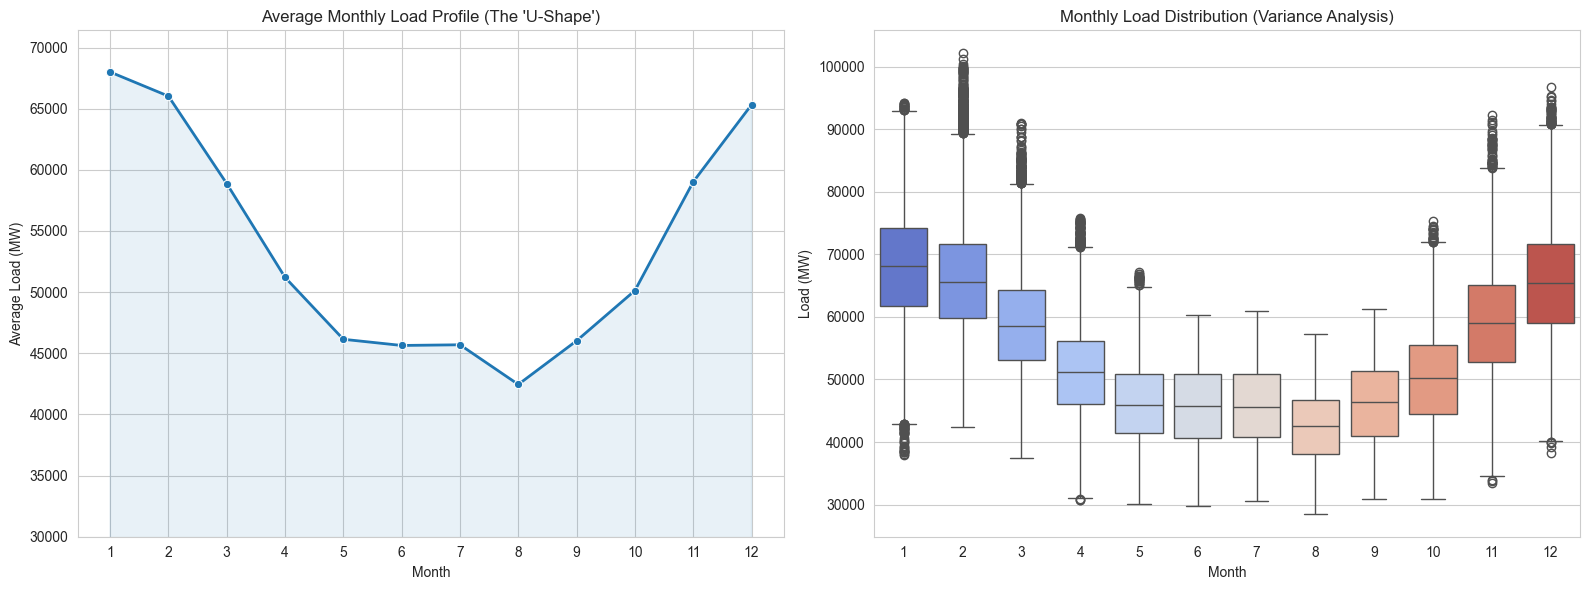

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import gc

def analyze_monthly_seasonality():
    print(">>> 6.1 SEASONAL PATTERNS: MONTHLY SEASONALITY")
    
    # 1. Load Data
    files = sorted(glob.glob("../data/interim/consommation/consommation_*_long_utc.csv"))
    if not files: return

    print(f"Aggregating {len(files)} years of data...")
    
    df_list = []
    for f in files:
        try:
            # Load subset
            cols = pd.read_csv(f, nrows=0).columns
            date_col = 'datetime' if 'datetime' in cols else 'start_date'
            val_col = 'load_mw' if 'load_mw' in cols else 'consumption_mw'
            
            temp = pd.read_csv(f, usecols=[date_col, val_col])
            temp = temp.rename(columns={date_col: 'ts', val_col: 'mw'})
            temp['ts'] = pd.to_datetime(temp['ts'], utc=True)
            
            # Extract Month
            temp['month'] = temp['ts'].dt.month
            
            # We can downsample to daily mean to speed up boxplots without losing distribution shape
            # or keep hourly. Let's keep hourly for full variance.
            # To save memory, we can select relevant columns only.
            df_list.append(temp[['month', 'mw']])
            
        except Exception as e:
            print(f"Skipping {f}: {e}")

    if not df_list: return
    
    # 2. Concatenate
    df_all = pd.concat(df_list)
    
    # 3. Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot A: Average Load by Month (Line/Bar)
    monthly_means = df_all.groupby('month')['mw'].mean()
    sns.lineplot(x=monthly_means.index, y=monthly_means.values, marker='o', color='#1f77b4', linewidth=2, ax=ax1)
    ax1.fill_between(monthly_means.index, 0, monthly_means.values, color='#1f77b4', alpha=0.1)
    ax1.set_title("Average Monthly Load Profile (The 'U-Shape')")
    ax1.set_ylabel("Average Load (MW)")
    ax1.set_xlabel("Month")
    ax1.set_xticks(range(1, 13))
    ax1.set_ylim(bottom=30000)
    
    # Plot B: Monthly Boxplots (Variance)
    sns.boxplot(data=df_all, x='month', y='mw', palette="coolwarm", ax=ax2)
    ax2.set_title("Monthly Load Distribution (Variance Analysis)")
    ax2.set_ylabel("Load (MW)")
    ax2.set_xlabel("Month")
    
    plt.tight_layout()
    plt.show()

    # Cleanup
    del df_all, df_list
    gc.collect()

analyze_monthly_seasonality()

The average monthly profile exhibits a clear **U-shape**:
- high demand in winter (January–February, December),
- a progressive decline toward summer,
- a minimum during July–August.

Monthly boxplots highlight strong variance in winter months, driven by
temperature sensitivity and cold spells, while summer demand is both lower
and more stable.

## 6.2 Year-to-year comparison

This subsection compares monthly load profiles across years to detect
structural deviations from the average seasonal pattern.


>>> 6.2 SEASONAL PATTERNS: YEAR-TO-YEAR COMPARISON
Loading 30 years for comparison...


C:\Users\dmarin\AppData\Local\Temp\ipykernel_11444\1551998496.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat(df_list)


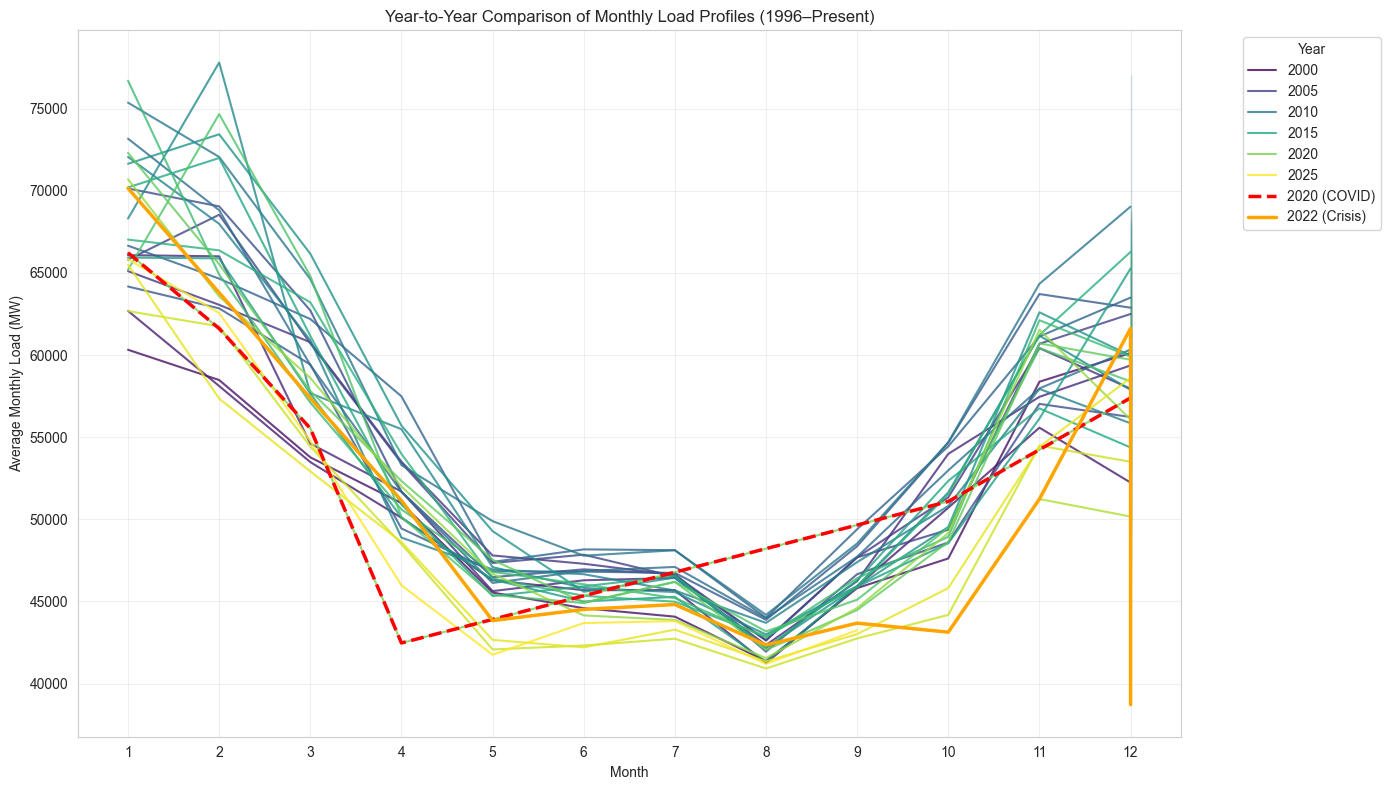

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import gc

def analyze_year_to_year_comparison():
    print(">>> 6.2 SEASONAL PATTERNS: YEAR-TO-YEAR COMPARISON")
    
    # 1. Load Data
    files = sorted(glob.glob("../data/interim/consommation/consommation_*_long_utc.csv"))
    if not files: return

    print(f"Loading {len(files)} years for comparison...")
    
    df_list = []
    for f in files:
        try:
            cols = pd.read_csv(f, nrows=0).columns
            date_col = 'datetime' if 'datetime' in cols else 'start_date'
            val_col = 'load_mw' if 'load_mw' in cols else 'consumption_mw'
            
            temp = pd.read_csv(f, usecols=[date_col, val_col])
            temp = temp.rename(columns={date_col: 'ts', val_col: 'mw'})
            temp['ts'] = pd.to_datetime(temp['ts'], utc=True)
            
            # Extract features
            temp['year'] = temp['ts'].dt.year
            temp['month'] = temp['ts'].dt.month
            
            # Aggregate to monthly mean per year
            agg = temp.groupby(['year', 'month'])['mw'].mean().reset_index()
            df_list.append(agg)
            
        except Exception as e:
            pass

    if not df_list: return
    df_all = pd.concat(df_list)
    
    # 2. Visualization
    plt.figure(figsize=(14, 8))
    
    # Create a line plot with a sequential palette
    # We treat 'year' as numerical to get a gradient, or categorical for distinct colors
    sns.lineplot(
        data=df_all, 
        x='month', 
        y='mw', 
        hue='year', 
        palette='viridis',  # Darker = More Recent
        linewidth=1.5,
        alpha=0.8
    )
    
    # Highlight Key Years manually for clarity
    # 2020 (COVID) - Red Dashed
    df_2020 = df_all[df_all['year'] == 2020]
    plt.plot(df_2020['month'], df_2020['mw'], color='red', linestyle='--', linewidth=2.5, label='2020 (COVID)')
    
    # 2022 (Energy Crisis Start) - Orange
    df_2022 = df_all[df_all['year'] == 2022]
    plt.plot(df_2022['month'], df_2022['mw'], color='orange', linewidth=2.5, label='2022 (Crisis)')
    
    plt.title("Year-to-Year Comparison of Monthly Load Profiles (1996–Present)")
    plt.ylabel("Average Monthly Load (MW)")
    plt.xlabel("Month")
    plt.xticks(range(1, 13))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Year")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Cleanup
    del df_all, df_list
    gc.collect()

analyze_year_to_year_comparison()

The overall shape remains stable over time, confirming strong seasonality.
However, specific years stand out:
- **2020** shows a marked downward shift due to the COVID shock,
- **2022** departs from historical levels, reflecting the energy crisis and
  demand reduction behaviors.

These deviations indicate structural breaks that must be accounted for
explicitly in modeling and backtesting.
Si tu veux, on peut terminer avec §7 Thermo-sensibilité dans le même format minimal et propre.

# 7. Thermo-sensitivity analysis


## 7.1 Load vs temperature

This section examines the relationship between national electricity demand and
average temperature.

>>> 7.1 THERMO-SENSITIVITY: LOAD VS TEMP
Loading data for years: [2019, 2020, 2021, 2022, 2023]...
Merged Data Points: 38,653


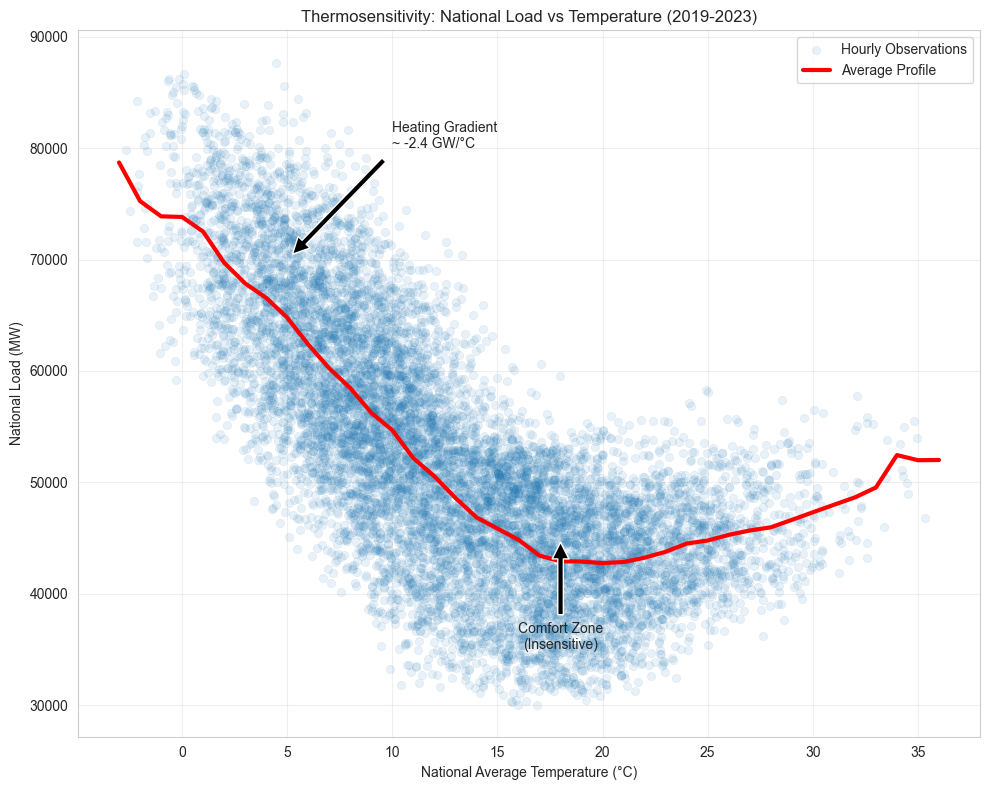

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import gc

def analyze_thermosensitivity():
    print(">>> 7.1 THERMO-SENSITIVITY: LOAD VS TEMP")
    
    # 1. Select Recent Years (e.g., 2019-2023) for relevant analysis
    years = [2019, 2020, 2021, 2022, 2023]
    print(f"Loading data for years: {years}...")
    
    # --- A. Load Consumption ---
    conso_list = []
    for y in years:
        f = f"../data/interim/consommation/consommation_{y}_long_utc.csv"
        try:
            # Check cols
            cols = pd.read_csv(f, nrows=0).columns
            date_col = 'datetime' if 'datetime' in cols else 'start_date'
            val_col = 'load_mw' if 'load_mw' in cols else 'consumption_mw'
            
            df = pd.read_csv(f, usecols=[date_col, val_col])
            df = df.rename(columns={date_col: 'ts', val_col: 'mw'})
            df['ts'] = pd.to_datetime(df['ts'], utc=True)
            conso_list.append(df)
        except: pass
    
    if not conso_list: return
    df_conso = pd.concat(conso_list).sort_values('ts').set_index('ts')
    
    # Resample Conso to Hourly (to match Weather)
    df_conso_h = df_conso.resample('h').mean().dropna()
    
    # --- B. Load Weather (and aggregate to National Mean) ---
    weather_list = []
    for y in years:
        f = f"../data/raw/weather/weather_32_cities_{y}.csv"
        try:
            # We take mean of all cities for a simple proxy
            df = pd.read_csv(f, usecols=['date', 'temperature_2m'])
            df['ts'] = pd.to_datetime(df['date'], utc=True)
            
            # Group by Timestamp (Average across 32 cities per hour)
            # This creates a "National Average Temperature"
            df_nat = df.groupby('ts')['temperature_2m'].mean()
            weather_list.append(df_nat)
        except: pass
        
    if not weather_list: return
    df_weather_h = pd.concat(weather_list).sort_index()
    
    # --- C. Merge ---
    # Inner join on index (Hour)
    df_merged = pd.merge(df_conso_h, df_weather_h, left_index=True, right_index=True)
    df_merged = df_merged.rename(columns={'temperature_2m': 'temp'})
    
    print(f"Merged Data Points: {len(df_merged):,}")
    
    # --- D. Visualization ---
    plt.figure(figsize=(10, 8))
    
    # 1. Scatter Plot with density (hexbin is faster/cleaner for large data)
    # But scatterplot with alpha is requested. We use a subset for plotting speed if huge.
    plot_data = df_merged.sample(min(10000, len(df_merged))) # Sample for plotting
    
    sns.scatterplot(
        data=plot_data, 
        x='temp', 
        y='mw', 
        alpha=0.1, 
        color='#1f77b4', 
        edgecolor=None, 
        label='Hourly Observations'
    )
    
    # 2. Non-linear Smoothing (The "Trend")
    # We bin temperature by 1°C steps to draw a clean mean line
    df_merged['temp_bin'] = df_merged['temp'].round()
    trend = df_merged.groupby('temp_bin')['mw'].mean().reset_index()
    
    plt.plot(trend['temp_bin'], trend['mw'], color='red', linewidth=3, label='Average Profile')
    
    plt.title("Thermosensitivity: National Load vs Temperature (2019-2023)")
    plt.xlabel("National Average Temperature (°C)")
    plt.ylabel("National Load (MW)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Annotation for Slope
    plt.annotate("Heating Gradient\n~ -2.4 GW/°C", 
                 xy=(5, 70000), xytext=(10, 80000),
                 arrowprops=dict(facecolor='black', shrink=0.05))
    
    plt.annotate("Comfort Zone\n(Insensitive)", 
                 xy=(18, 45000), xytext=(18, 35000),
                 arrowprops=dict(facecolor='black', shrink=0.05), ha='center')

    plt.tight_layout()
    plt.show()

    # Cleanup
    del df_conso, df_weather_h, df_merged, conso_list, weather_list
    gc.collect()

analyze_thermosensitivity()


The raw scatter shows a **strongly non-linear relationship**:
- high sensitivity at low temperatures (heating demand),
- a flat **comfort zone** around temperate conditions,
- a weaker upward effect at high temperatures (cooling).

Non-linear smoothing highlights a clear **winter heating gradient**, confirming
that cold spells are the main driver of short-term demand variability.
This motivates a piecewise or engineered temperature representation rather
than raw temperature in modeling.

## 7.2 Degree-days

This subsection introduces **degree-day transformations** to linearize the
temperature–load relationship.

>>> 7.2 DEGREE-DAYS ANALYSIS (HDD/CDD)
Aggregating Daily Data for years: [2019, 2020, 2021, 2022, 2023]...
Data Points (Daily): 1,613


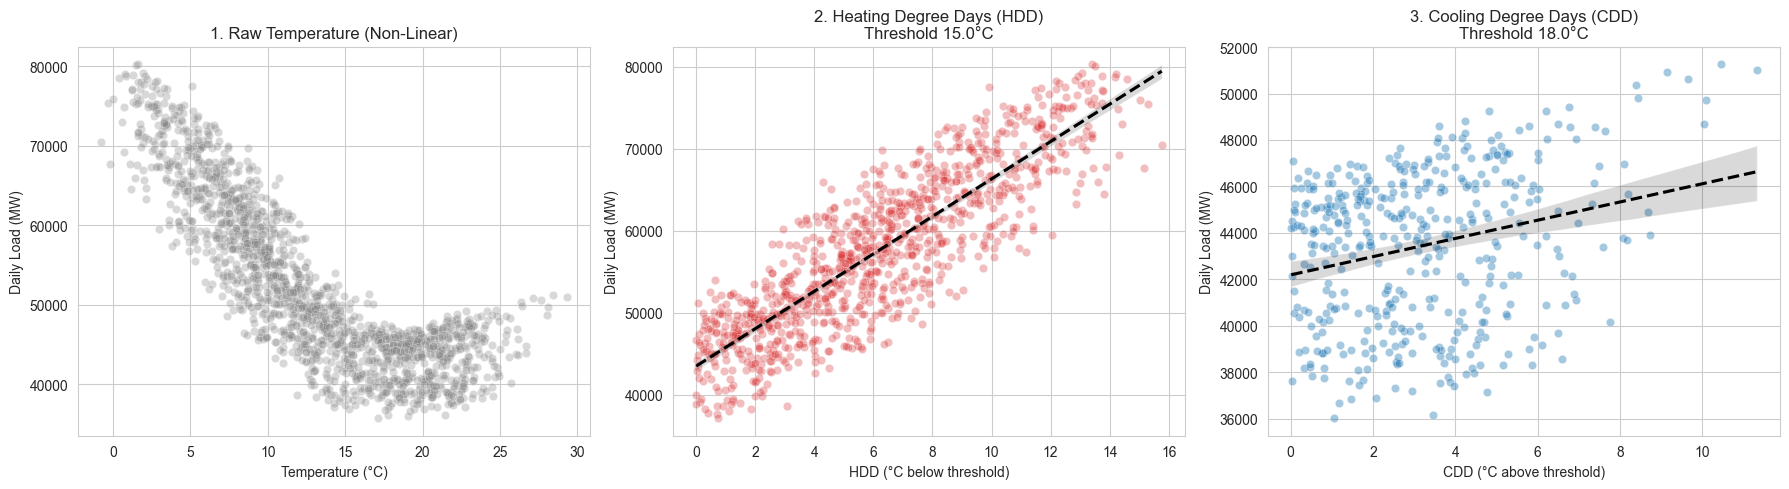


--- Correlation Analysis (Pearson) ---
Raw Temp Correlation: -0.837 (Negative, Non-linear mix)
HDD Correlation:      0.910 (Strong Positive Linear)


In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import gc
import numpy as np

def analyze_degree_days():
    print(">>> 7.2 DEGREE-DAYS ANALYSIS (HDD/CDD)")
    
    # 1. Configuration
    years = [2019, 2020, 2021, 2022, 2023]
    T_REF_HEAT = 15.0  # Seuil de chauffage
    T_REF_COOL = 18.0  # Seuil de climatisation
    
    print(f"Aggregating Daily Data for years: {years}...")
    
    # --- A. Load Consumption (Daily Mean) ---
    conso_list = []
    for y in years:
        f = f"../data/interim/consommation/consommation_{y}_long_utc.csv"
        try:
            # Lecture des colonnes pour s'adapter
            cols = pd.read_csv(f, nrows=0).columns
            date_col = 'datetime' if 'datetime' in cols else 'start_date'
            val_col = 'load_mw' if 'load_mw' in cols else 'consumption_mw'
            
            df = pd.read_csv(f, usecols=[date_col, val_col])
            df = df.rename(columns={date_col: 'ts', val_col: 'mw'})
            df['ts'] = pd.to_datetime(df['ts'], utc=True)
            
            # Resample journalier
            daily = df.set_index('ts').resample('D')['mw'].mean()
            conso_list.append(daily)
        except: pass
    
    if not conso_list: return
    df_conso = pd.concat(conso_list)
    
    # CORRECTION : Dédoublonnage explicite de l'index
    df_conso = df_conso[~df_conso.index.duplicated(keep='first')].sort_index()
    
    # --- B. Load Weather (Daily Mean) ---
    weather_list = []
    for y in years:
        f = f"../data/raw/weather/weather_32_cities_{y}.csv"
        try:
            df = pd.read_csv(f, usecols=['date', 'temperature_2m'])
            df['ts'] = pd.to_datetime(df['date'], utc=True)
            
            # Moyenne nationale journalière
            daily = df.groupby(df['ts'].dt.date)['temperature_2m'].mean()
            # On remet l'index en datetime UTC pour matcher la conso
            daily.index = pd.to_datetime(daily.index).tz_localize('UTC')
            weather_list.append(daily)
        except: pass
        
    if not weather_list: return
    df_weather = pd.concat(weather_list)
    
    # CORRECTION : Dédoublonnage explicite de l'index météo aussi
    df_weather = df_weather[~df_weather.index.duplicated(keep='first')].sort_index()
    
    # --- C. Merge & Feature Engineering ---
    # Maintenant l'axe est propre, le concat axis=1 va fonctionner
    df = pd.concat([df_conso, df_weather], axis=1).dropna()
    df.columns = ['load_mw', 'temp']
    
    # Calcul HDD / CDD
    df['HDD'] = (T_REF_HEAT - df['temp']).clip(lower=0)
    df['CDD'] = (df['temp'] - T_REF_COOL).clip(lower=0)
    
    print(f"Data Points (Daily): {len(df):,}")
    
    # --- D. Visualization ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot 1: Température Brute
    sns.scatterplot(data=df, x='temp', y='load_mw', alpha=0.3, ax=axes[0], color='gray')
    axes[0].set_title("1. Raw Temperature (Non-Linear)")
    axes[0].set_xlabel("Temperature (°C)")
    axes[0].set_ylabel("Daily Load (MW)")
    
    # Plot 2: HDD (Heating)
    # On filtre HDD > 0 pour voir la pente
    data_hdd = df[df['HDD'] > 0]
    sns.scatterplot(data=data_hdd, x='HDD', y='load_mw', alpha=0.3, ax=axes[1], color='#d62728')
    if len(data_hdd) > 1:
        sns.regplot(data=data_hdd, x='HDD', y='load_mw', scatter=False, ax=axes[1], color='black', line_kws={'linestyle':'--'})
    
    axes[1].set_title(f"2. Heating Degree Days (HDD)\nThreshold {T_REF_HEAT}°C")
    axes[1].set_xlabel("HDD (°C below threshold)")
    axes[1].set_ylabel("Daily Load (MW)")
    
    # Plot 3: CDD (Cooling)
    data_cdd = df[df['CDD'] > 0]
    sns.scatterplot(data=data_cdd, x='CDD', y='load_mw', alpha=0.4, ax=axes[2], color='#1f77b4')
    if len(data_cdd) > 1:
        sns.regplot(data=data_cdd, x='CDD', y='load_mw', scatter=False, ax=axes[2], color='black', line_kws={'linestyle':'--'})
        
    axes[2].set_title(f"3. Cooling Degree Days (CDD)\nThreshold {T_REF_COOL}°C")
    axes[2].set_xlabel("CDD (°C above threshold)")
    axes[2].set_ylabel("Daily Load (MW)")
    
    plt.tight_layout()
    plt.show()
    
    # --- E. Check Corrélation ---
    corr_temp = df.corr()['load_mw']['temp']
    corr_hdd = df.corr()['load_mw']['HDD']
    
    print(f"\n--- Correlation Analysis (Pearson) ---")
    print(f"Raw Temp Correlation: {corr_temp:.3f} (Negative, Non-linear mix)")
    print(f"HDD Correlation:      {corr_hdd:.3f} (Strong Positive Linear)")

    # Cleanup
    del df, df_conso, df_weather, conso_list, weather_list
    gc.collect()

analyze_degree_days()

Heating Degree Days (HDD, threshold 15°C) exhibit a **strong linear correlation**
with demand, outperforming raw temperature.
Cooling Degree Days (CDD, threshold 18°C) show a weaker but positive effect,
consistent with limited air-conditioning penetration in France.

These results justify the use of HDD (and optionally CDD) as primary
weather-driven features in the demand model.

## 7.3 Thermal inertia

This subsection evaluates the impact of **thermal inertia** by comparing raw
and smoothed temperature-based indicators.

>>> 7.3 THERMAL INERTIA ANALYSIS
Loading data for years: [2019, 2020, 2021, 2022, 2023]...

--- IMPACT OF THERMAL INERTIA (Correlation with Load) ---
Raw HDD Correlation:      0.9097
Smoothed HDD Correlation: 0.9251
Improvement:             +0.0154


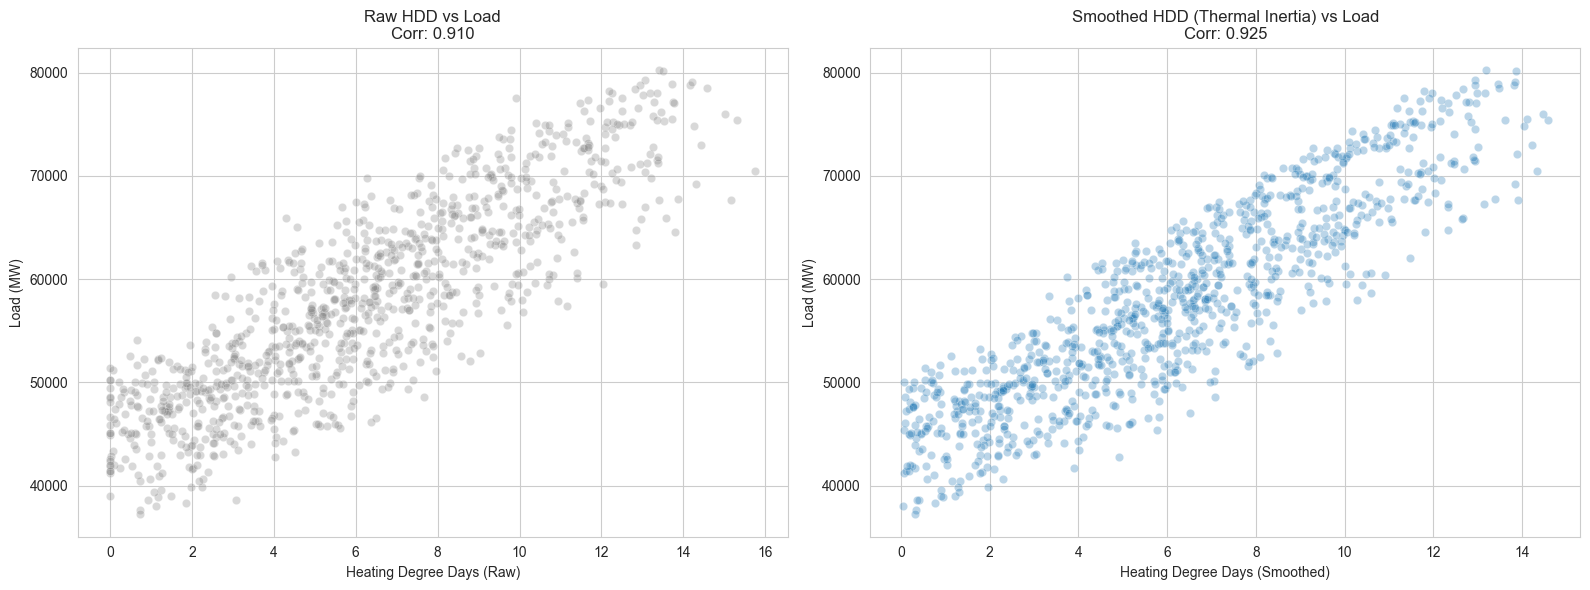

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import gc

def analyze_thermal_inertia():
    print(">>> 7.3 THERMAL INERTIA ANALYSIS")
    
    # 1. Load Recent Data (Daily Mean)
    years = [2019, 2020, 2021, 2022, 2023]
    print(f"Loading data for years: {years}...")
    
    # --- A. Load Consumption ---
    conso_list = []
    for y in years:
        f = f"../data/interim/consommation/consommation_{y}_long_utc.csv"
        try:
            cols = pd.read_csv(f, nrows=0).columns
            date_col = 'datetime' if 'datetime' in cols else 'start_date'
            val_col = 'load_mw' if 'load_mw' in cols else 'consumption_mw'
            
            df = pd.read_csv(f, usecols=[date_col, val_col])
            df = df.rename(columns={date_col: 'ts', val_col: 'mw'})
            df['ts'] = pd.to_datetime(df['ts'], utc=True)
            # Resample to Daily Mean immediately
            conso_list.append(df.set_index('ts').resample('D')['mw'].mean())
        except: pass
    
    if not conso_list: return
    df_conso = pd.concat(conso_list)
    
    # CRITICAL FIX: Deduplicate Index
    df_conso = df_conso[~df_conso.index.duplicated(keep='first')].sort_index()
    
    # --- B. Load Weather ---
    weather_list = []
    for y in years:
        f = f"../data/raw/weather/weather_32_cities_{y}.csv"
        try:
            df = pd.read_csv(f, usecols=['date', 'temperature_2m'])
            df['ts'] = pd.to_datetime(df['date'], utc=True)
            # Daily Mean Temp
            daily = df.groupby(df['ts'].dt.date)['temperature_2m'].mean()
            daily.index = pd.to_datetime(daily.index).tz_localize('UTC')
            weather_list.append(daily)
        except: pass
        
    if not weather_list: return
    df_weather = pd.concat(weather_list)
    
    # CRITICAL FIX: Deduplicate Index
    df_weather = df_weather[~df_weather.index.duplicated(keep='first')].sort_index()
    
    # --- C. Feature Engineering (Thermal Inertia) ---
    # Now concatenation is safe
    df = pd.concat([df_conso, df_weather], axis=1).dropna()
    df.columns = ['load_mw', 'temp_raw']
    
    # Create "Smoothed" Temperatures (Exponential Moving Average)
    # Span=3 implies roughly taking the last 3 days into account
    df['temp_smooth_3d'] = df['temp_raw'].ewm(span=3).mean()
    
    # Create HDD for both to compare fairness
    df['HDD_raw'] = (15 - df['temp_raw']).clip(lower=0)
    df['HDD_smooth'] = (15 - df['temp_smooth_3d']).clip(lower=0)
    
    # --- D. Correlations ---
    corr_raw = df['load_mw'].corr(df['HDD_raw'])
    corr_smooth = df['load_mw'].corr(df['HDD_smooth'])
    
    print(f"\n--- IMPACT OF THERMAL INERTIA (Correlation with Load) ---")
    print(f"Raw HDD Correlation:      {corr_raw:.4f}")
    print(f"Smoothed HDD Correlation: {corr_smooth:.4f}")
    print(f"Improvement:             +{(corr_smooth - corr_raw):.4f}")
    
    # --- E. Visualization ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Raw Temperature Scatter
    # Filter for Winter only (HDD > 0) to see the effect clearly
    winter_mask = df['HDD_smooth'] > 0
    
    sns.scatterplot(data=df[winter_mask], x='HDD_raw', y='load_mw', 
                    alpha=0.3, ax=axes[0], color='gray')
    axes[0].set_title(f"Raw HDD vs Load\nCorr: {corr_raw:.3f}")
    axes[0].set_xlabel("Heating Degree Days (Raw)")
    axes[0].set_ylabel("Load (MW)")
    
    # Plot 2: Smoothed Temperature Scatter
    sns.scatterplot(data=df[winter_mask], x='HDD_smooth', y='load_mw', 
                    alpha=0.3, ax=axes[1], color='#1f77b4')
    axes[1].set_title(f"Smoothed HDD (Thermal Inertia) vs Load\nCorr: {corr_smooth:.3f}")
    axes[1].set_xlabel("Heating Degree Days (Smoothed)")
    axes[1].set_ylabel("Load (MW)")
    
    plt.tight_layout()
    plt.show()

    # Cleanup
    del df, df_conso, df_weather
    gc.collect()

analyze_thermal_inertia()

Using a short-term smoothing of temperature (exponential moving average),
the correlation between load and Heating Degree Days increases compared to
raw HDD.
This reflects delayed heating responses in buildings and collective behavior.

The improvement confirms that demand reacts not only to instantaneous
temperature but also to **recent thermal history**, justifying the use of
lagged or smoothed weather features in the demand model.

# Part B — Production (supply side)


# 8. Electricity generation: overview


## 8.1 Total generation vs load

This subsection compares national electricity generation with demand to assess
system balance and stress periods.

>>> 8.1 GENERATION VS LOAD ANALYSIS
Loading data for years: [2019, 2020, 2021, 2022, 2023]...


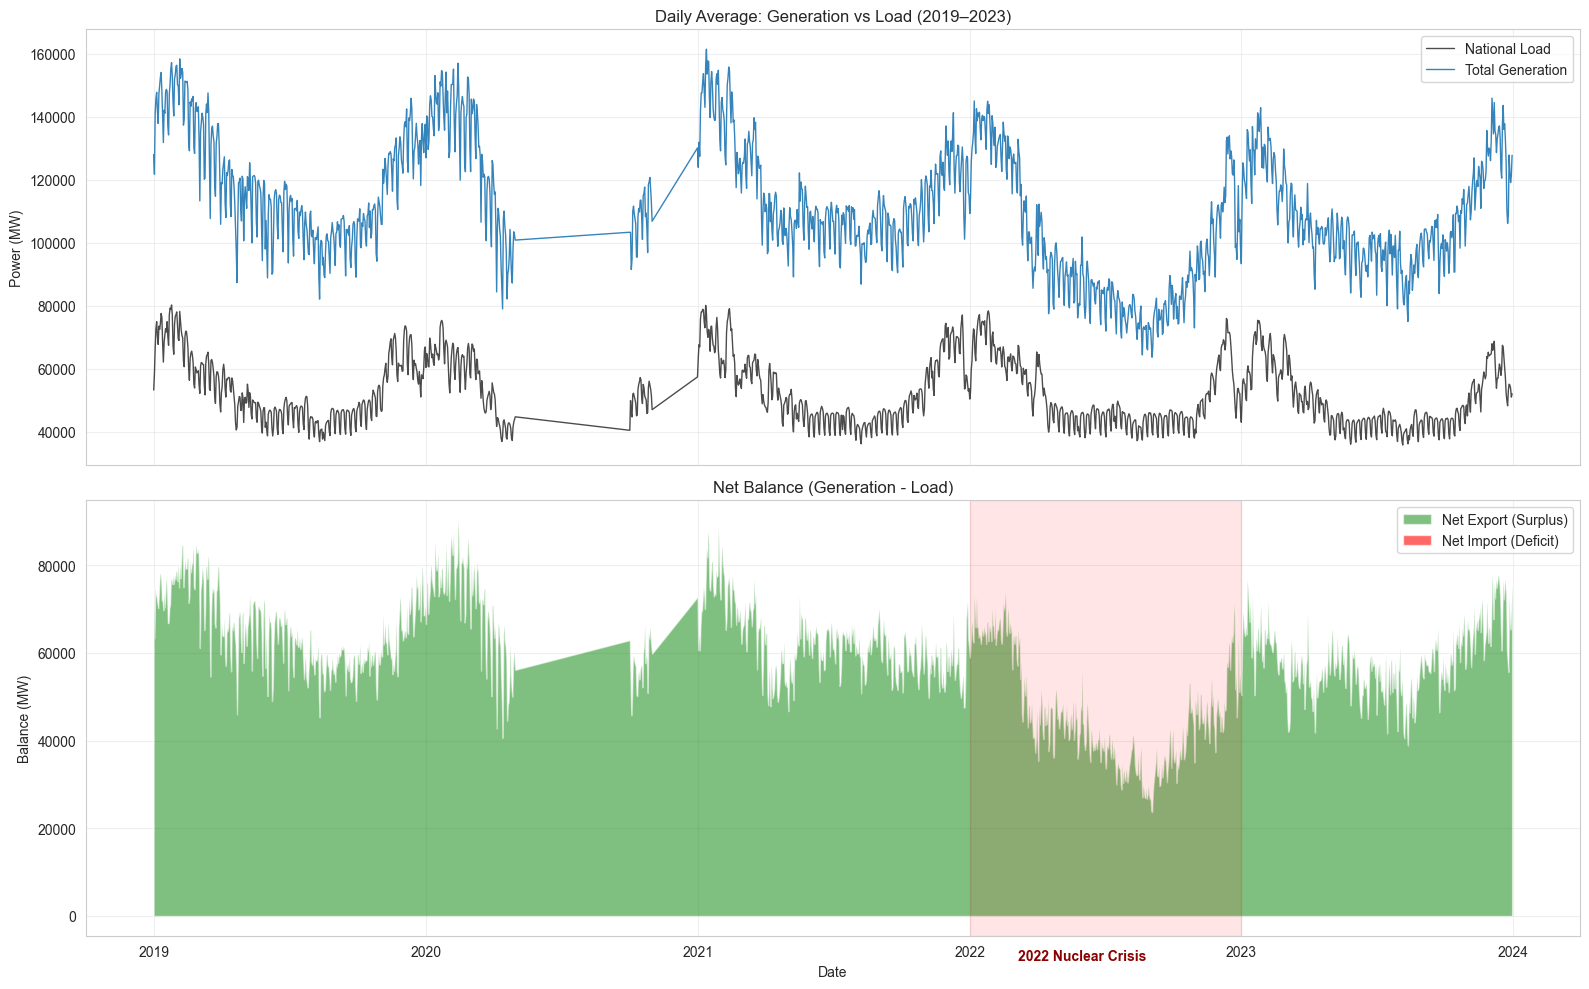


--- BALANCE STATISTICS (2019-2023) ---
Days of Net Import: 0 days (0.0% of time)
Max Export Peak:   +90,292 MW
Max Import Peak:   23,686 MW


In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import gc

def analyze_generation_vs_load():
    print(">>> 8.1 GENERATION VS LOAD ANALYSIS")
    
    # Focus on recent critical years
    years = [2019, 2020, 2021, 2022, 2023]
    print(f"Loading data for years: {years}...")
    
    # --- 1. Load Consumption (Demand) ---
    conso_list = []
    for y in years:
        f = f"../data/interim/consommation/consommation_{y}_long_utc.csv"
        try:
            cols = pd.read_csv(f, nrows=0).columns
            date_col = 'datetime' if 'datetime' in cols else 'start_date'
            val_col = 'load_mw' if 'load_mw' in cols else 'consumption_mw'
            
            df = pd.read_csv(f, usecols=[date_col, val_col])
            df = df.rename(columns={date_col: 'ts', val_col: 'load'})
            df['ts'] = pd.to_datetime(df['ts'], utc=True)
            # Resample to Daily Mean
            conso_list.append(df.set_index('ts').resample('D')['load'].mean())
        except: pass
        
    if not conso_list: return
    df_load = pd.concat(conso_list)

    # CRITICAL FIX: Deduplicate Index
    df_load = df_load[~df_load.index.duplicated(keep='first')].sort_index()

    # --- 2. Load Production (Supply) ---
    prod_list = []
    for y in years:
        f = f"../data/interim/production/production_realisation_{y}_long_utc.csv"
        try:
            cols = pd.read_csv(f, nrows=0).columns
            date_col = 'datetime' if 'datetime' in cols else 'start_date'
            
            df = pd.read_csv(f, usecols=[date_col, 'value_mw'])
            df = df.rename(columns={date_col: 'ts', 'value_mw': 'gen'})
            df['ts'] = pd.to_datetime(df['ts'], utc=True)
            
            # Sum ALL technologies per timestamp (Total Generation)
            # Then resample to Daily Mean
            total_gen = df.groupby('ts')['gen'].sum().resample('D').mean()
            prod_list.append(total_gen)
        except: pass
        
    if not prod_list: return
    df_gen = pd.concat(prod_list)

    # CRITICAL FIX: Deduplicate Index
    df_gen = df_gen[~df_gen.index.duplicated(keep='first')].sort_index()

    # --- 3. Merge & Calculate Balance ---
    # Now concatenation is safe
    df = pd.concat([df_load, df_gen], axis=1).dropna()
    df.columns = ['Load', 'Generation']
    
    df['Balance'] = df['Generation'] - df['Load']
    
    # --- 4. Visualization ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True)
    
    # Plot A: Line Chart (Load vs Gen)
    ax1.plot(df.index, df['Load'], color='black', linewidth=1, label='National Load', alpha=0.7)
    ax1.plot(df.index, df['Generation'], color='#1f77b4', linewidth=1, label='Total Generation', alpha=0.9)
    ax1.set_title("Daily Average: Generation vs Load (2019–2023)")
    ax1.set_ylabel("Power (MW)")
    ax1.legend(loc="upper right")
    ax1.grid(True, alpha=0.3)
    
    # Plot B: Net Balance (Import/Export)
    # Fill positive (Export) in Green, negative (Import) in Red
    ax2.fill_between(df.index, df['Balance'], 0, where=(df['Balance'] >= 0), 
                     facecolor='green', alpha=0.5, interpolate=True, label='Net Export (Surplus)')
    ax2.fill_between(df.index, df['Balance'], 0, where=(df['Balance'] < 0), 
                     facecolor='red', alpha=0.6, interpolate=True, label='Net Import (Deficit)')
    
    # Highlight 2022 Crisis
    ax2.axvspan(pd.Timestamp('2022-01-01', tz='UTC'), pd.Timestamp('2022-12-31', tz='UTC'), 
                color='red', alpha=0.1)
    ax2.text(pd.Timestamp('2022-06-01', tz='UTC'), -10000, "2022 Nuclear Crisis", ha='center', color='darkred', fontweight='bold')

    ax2.set_title("Net Balance (Generation - Load)")
    ax2.set_ylabel("Balance (MW)")
    ax2.set_xlabel("Date")
    ax2.legend(loc="upper right")
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    # Stats
    imports = df[df['Balance'] < 0]
    print(f"\n--- BALANCE STATISTICS (2019-2023) ---")
    print(f"Days of Net Import: {len(imports)} days ({len(imports)/len(df):.1%} of time)")
    print(f"Max Export Peak:   +{df['Balance'].max():,.0f} MW")
    print(f"Max Import Peak:   {df['Balance'].min():,.0f} MW")

    del df, df_load, df_gen
    gc.collect()

analyze_generation_vs_load()

Over most of the period, total generation exceeds load, reflecting France’s
structural export position.
However, the **net balance tightens sharply in 2022**, corresponding to the
nuclear availability crisis, during which the margin between generation and
load is significantly reduced.

This highlights the importance of jointly analyzing demand and supply when
assessing grid stress, even in structurally exporting systems.

## 8.2 Generation mix

This subsection analyzes the composition and evolution of the electricity
generation mix.

>>> 8.2 GENERATION MIX ANALYSIS
Loading production data for: [2019, 2020, 2021, 2022, 2023]...


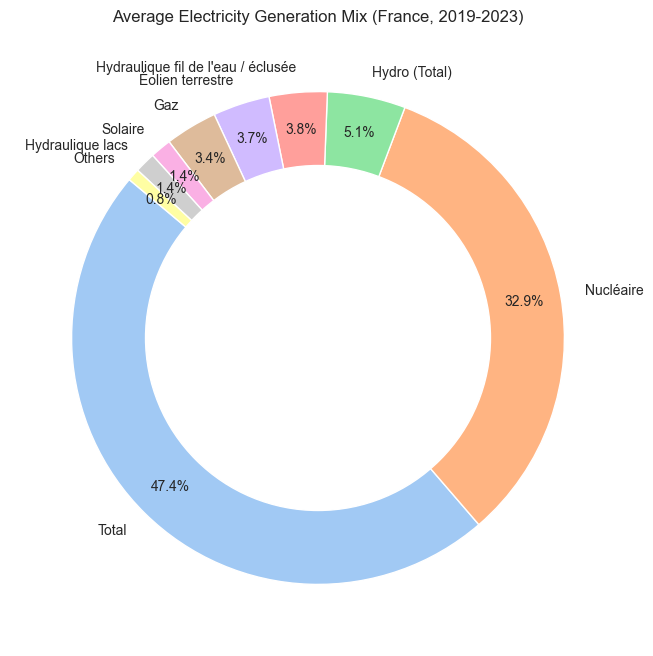

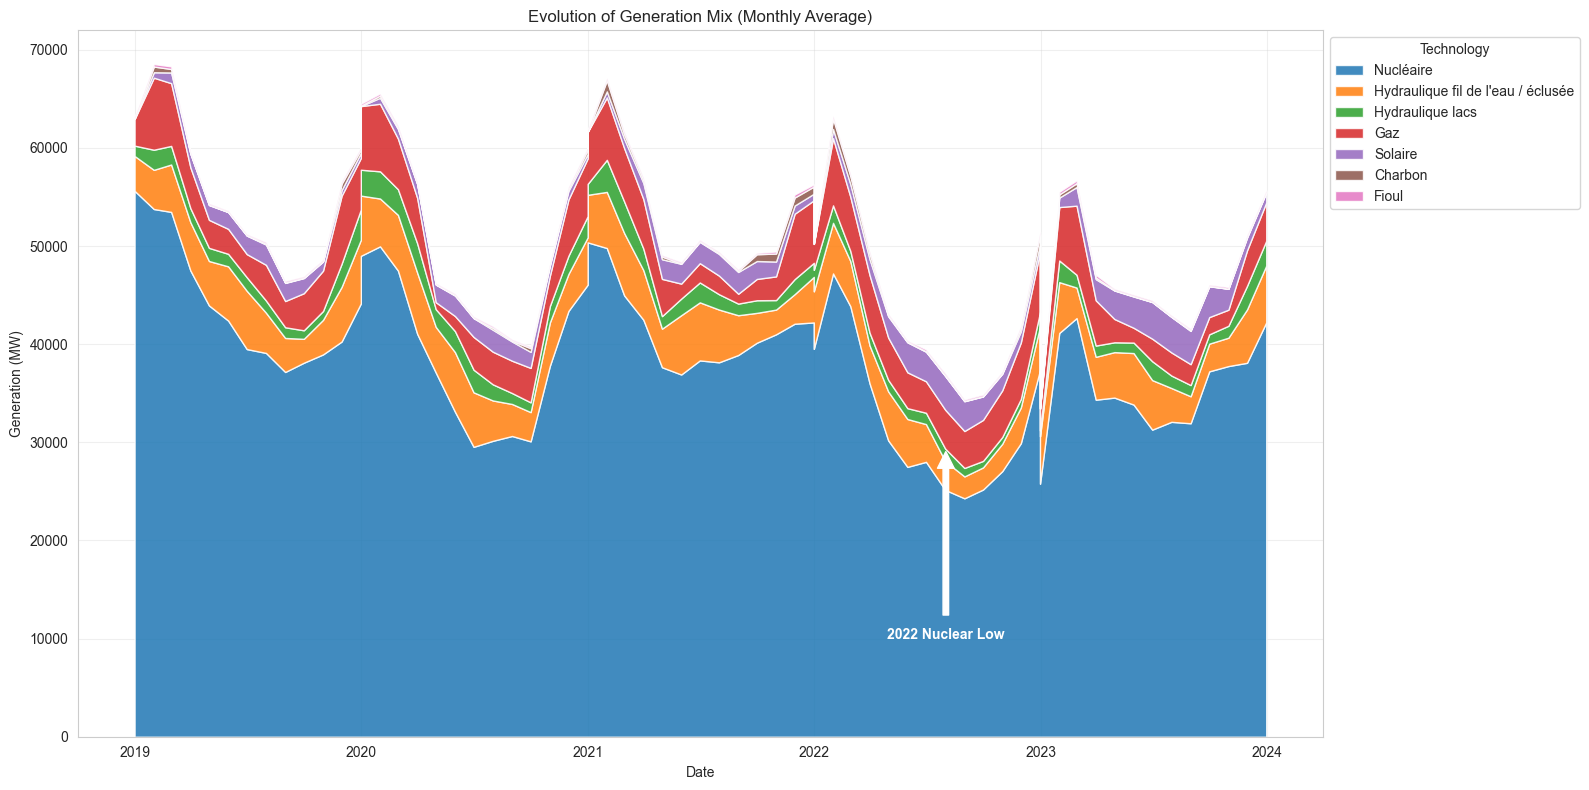

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import gc

def analyze_generation_mix():
    print(">>> 8.2 GENERATION MIX ANALYSIS")
    
    # Focus on recent years to reflect the current energy landscape
    years = [2019, 2020, 2021, 2022, 2023]
    print(f"Loading production data for: {years}...")
    
    prod_list = []
    for y in years:
        f = f"../data/interim/production/production_realisation_{y}_long_utc.csv"
        try:
            cols = pd.read_csv(f, nrows=0).columns
            date_col = 'datetime' if 'datetime' in cols else 'start_date'
            
            # Load Long Format: [datetime, technology, value_mw]
            df = pd.read_csv(f, usecols=[date_col, 'technology', 'value_mw'])
            df = df.rename(columns={date_col: 'ts', 'value_mw': 'mw'})
            df['ts'] = pd.to_datetime(df['ts'], utc=True)
            
            # Pivot immediately to Wide Format (Index=Time, Cols=Tech)
            # We use sum() in case of duplicates, then resample to Monthly Mean to save RAM
            wide = df.pivot_table(index='ts', columns='technology', values='mw', aggfunc='sum')
            wide_monthly = wide.resample('ME').mean() # 'ME' is Month End (pandas 2.0+) or 'M'
            
            prod_list.append(wide_monthly)
        except Exception as e:
            print(f"Skipping {y}: {e}")
        
    if not prod_list: return
    df_mix = pd.concat(prod_list).sort_index()
    
    # Clean up column names (remove NaN cols if any)
    df_mix = df_mix.fillna(0)
    
    # Consolidate minor technologies if needed (Optional)
    # e.g., Group all Hydro
    hydro_cols = [c for c in df_mix.columns if 'Hydraulique' in c]
    df_mix['Hydro (Total)'] = df_mix[hydro_cols].sum(axis=1)
    # We keep original columns for detailed view, but could drop them to simplify
    
    # --- A. Global Mix (Pie Chart) ---
    # Average generation over the whole period
    total_gen = df_mix.mean().sort_values(ascending=False)
    
    # Filter for main technologies (> 1% share) for the pie chart
    main_gen = total_gen[total_gen / total_gen.sum() > 0.01]
    other_gen = total_gen[total_gen / total_gen.sum() <= 0.01].sum()
    if other_gen > 0:
        main_gen['Others'] = other_gen
        
    plt.figure(figsize=(10, 8))
    plt.pie(main_gen, labels=main_gen.index, autopct='%1.1f%%', startangle=140, 
            colors=sns.color_palette('pastel'), pctdistance=0.85)
    plt.title(f"Average Electricity Generation Mix (France, {years[0]}-{years[-1]})")
    # Draw circle for Donut Chart style
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    plt.gca().add_artist(centre_circle)
    plt.show()
    
    # --- B. Evolution over Time (Stacked Area Chart) ---
    # We select the most important columns for the stacked plot to avoid clutter
    # Standardizing names slightly for display
    plot_cols = ['Nucléaire', 'Hydraulique fil de l\'eau / éclusée', 'Hydraulique lacs', 
                 'Gaz', 'Eolien terrestre', 'Eolien en mer', 'Solaire', 'Charbon', 'Fioul']
    
    # Intersect with available columns
    available_cols = [c for c in plot_cols if c in df_mix.columns]
    
    # Plot
    plt.figure(figsize=(16, 8))
    plt.stackplot(df_mix.index, [df_mix[c] for c in available_cols], labels=available_cols, alpha=0.85)
    
    plt.title("Evolution of Generation Mix (Monthly Average)")
    plt.ylabel("Generation (MW)")
    plt.xlabel("Date")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Technology")
    plt.grid(True, alpha=0.3)
    
    # Highlight 2022 Nuclear Dip
    plt.annotate('2022 Nuclear Low', xy=(pd.Timestamp('2022-08-01', tz='UTC'), 30000), 
                 xytext=(pd.Timestamp('2022-08-01', tz='UTC'), 10000),
                 arrowprops=dict(facecolor='white', shrink=0.05), color='white', fontweight='bold', ha='center')

    plt.tight_layout()
    plt.show()

    del df_mix, prod_list
    gc.collect()

analyze_generation_mix()

On average, **nuclear power dominates** the mix, followed by hydro and gas,
with renewables (wind and solar) contributing a growing but still secondary
share.
The monthly evolution reveals strong seasonality in hydro and solar output.

The **2022 nuclear dip** is clearly visible, partially compensated by higher
thermal and hydro generation.
This structural shock motivates treating production-side variables separately
from demand modeling in this study.

# 9. Production by technology


## 9.1 Wind

Wind generation is highly volatile and weakly predictable at short horizons.


>>> 9.1 WIND: DURATION CURVE & VOLATILITY ZOOM (Correction Accents)
Loading Wind data for: [2019, 2020, 2021, 2022, 2023]...
--- DEBUG 2019: Technologies brutes ---
['Biomasse' 'Charbon' 'Déchets' 'Fioul' 'Gaz' 'Hydraulique STEP'
 "Hydraulique fil de l'eau / éclusée" 'Hydraulique lacs' 'Nucléaire'
 'Solaire' 'Total' 'Éolien terrestre']
Données chargées avec succès : 43,814 points horaires.


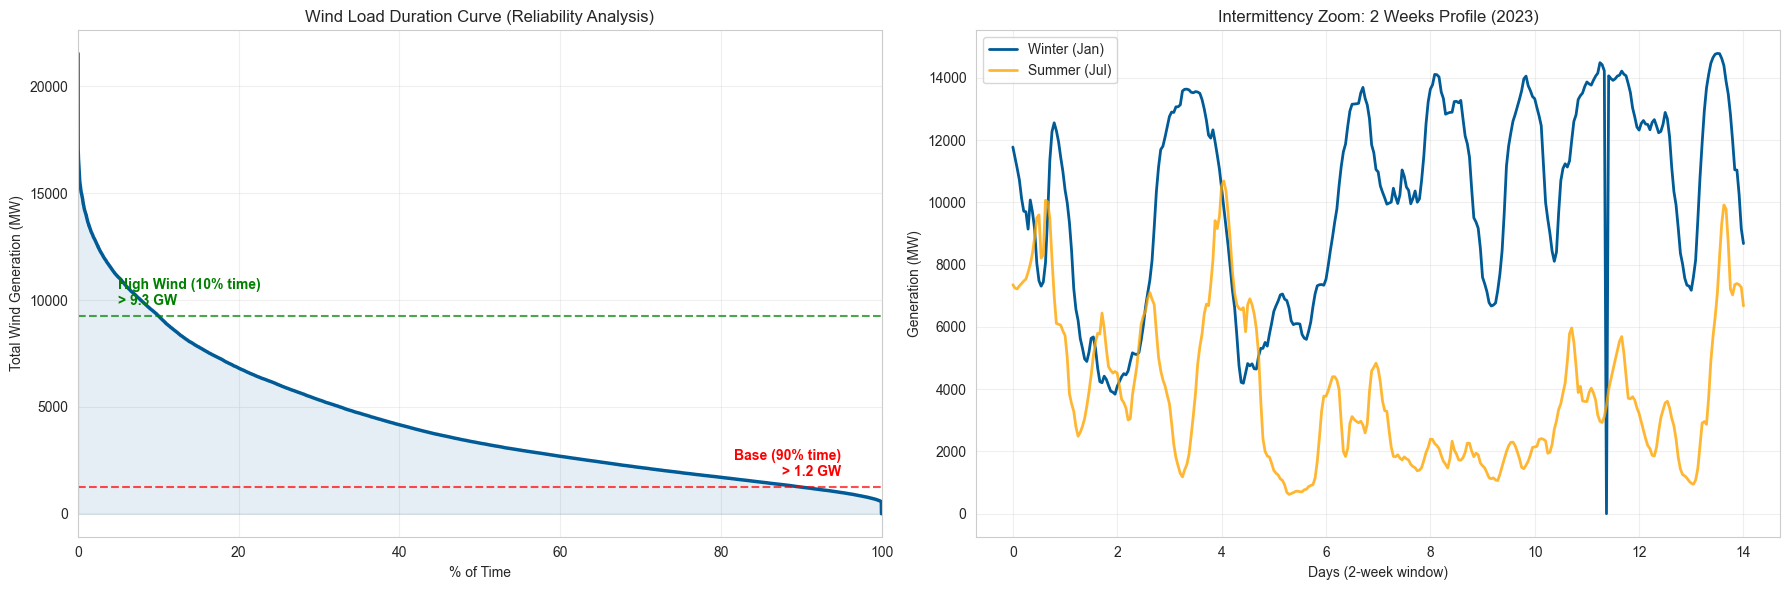

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import gc
import numpy as np

def analyze_wind_better_viz():
    print(">>> 9.1 WIND: DURATION CURVE & VOLATILITY ZOOM (Correction Accents)")
    
    # Configuration
    years = [2019, 2020, 2021, 2022, 2023]
    
    print(f"Loading Wind data for: {years}...")
    
    df_list = []
    printed_techs = False
    
    for y in years:
        f = f"../data/interim/production/production_realisation_{y}_long_utc.csv"
        try:
            cols = pd.read_csv(f, nrows=0).columns
            date_col = 'datetime' if 'datetime' in cols else 'start_date'
            
            # 1. Chargement
            df = pd.read_csv(f, usecols=[date_col, 'technology', 'value_mw'])
            
            # DEBUG : Affiche les technologies de la première année chargée
            if not printed_techs:
                print(f"--- DEBUG {y}: Technologies brutes ---")
                print(df['technology'].unique())
                printed_techs = True
            
            df = df.rename(columns={date_col: 'ts', 'value_mw': 'mw'})
            df['ts'] = pd.to_datetime(df['ts'], utc=True)
            
            # 2. FILTRE ROBUSTE (CORRECTION ICI)
            # Au lieu d'une liste exacte, on cherche le mot "olien" (ignorant E/É et majuscules)
            # Cela attrape "Eolien terrestre", "Éolien terrestre", "Eolien en mer", etc.
            mask_wind = df['technology'].str.contains('olien', case=False, na=False)
            df = df[mask_wind]
            
            # Sécurité : Si vide après filtre, on passe au fichier suivant
            if df.empty:
                continue

            # 3. Somme Eolien Total (Terrestre + Mer) par heure
            df_total = df.groupby('ts')['mw'].sum().reset_index()
            df_list.append(df_total)
                
        except Exception as e:
            # print(f"Skipping {y}: {e}") 
            pass
        
    if not df_list:
        print("ERREUR CRITIQUE: Aucune donnée éolienne trouvée même avec le filtre large 'olien'.")
        return

    df_wind = pd.concat(df_list).sort_values('ts').set_index('ts')
    
    # Dédoublonnage index au cas où
    df_wind = df_wind[~df_wind.index.duplicated(keep='first')]

    if df_wind.empty:
        print("ERREUR: DataFrame final vide.")
        return
        
    print(f"Données chargées avec succès : {len(df_wind):,} points horaires.")
    
    # --- VISUALISATION ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # --- PLOT A: MONOTONE (Duration Curve) ---
    y_values = df_wind['mw'].sort_values(ascending=False).values
    
    if len(y_values) == 0:
        return

    x_values = np.linspace(0, 100, len(y_values))
    
    ax1.plot(x_values, y_values, color='#005b96', linewidth=2.5)
    ax1.fill_between(x_values, 0, y_values, color='#005b96', alpha=0.1)
    
    # Stats P10 / P90
    p10 = np.percentile(y_values, 90) # Haut
    p90 = np.percentile(y_values, 10) # Bas
    
    ax1.axhline(p10, color='green', linestyle='--', alpha=0.7)
    ax1.text(5, p10 + 500, f"High Wind (10% time)\n> {p10/1000:.1f} GW", color='green', fontweight='bold')
    
    ax1.axhline(p90, color='red', linestyle='--', alpha=0.7)
    ax1.text(95, p90 + 500, f"Base (90% time)\n> {p90/1000:.1f} GW", color='red', ha='right', fontweight='bold')
    
    ax1.set_title("Wind Load Duration Curve (Reliability Analysis)")
    ax1.set_ylabel("Total Wind Generation (MW)")
    ax1.set_xlabel("% of Time")
    ax1.set_xlim(0, 100)
    ax1.grid(True, alpha=0.3)
    
    # --- PLOT B: ZOOM TEMPOREL (Hiver vs Été) ---
    # On prend la dernière année complète disponible
    last_year = df_wind.index.year.max()
    
    start_winter = pd.Timestamp(f'{last_year}-01-01', tz='UTC')
    end_winter = pd.Timestamp(f'{last_year}-01-15', tz='UTC')
    
    start_summer = pd.Timestamp(f'{last_year}-07-01', tz='UTC')
    end_summer = pd.Timestamp(f'{last_year}-07-15', tz='UTC')
    
    mask_winter = (df_wind.index >= start_winter) & (df_wind.index <= end_winter)
    mask_summer = (df_wind.index >= start_summer) & (df_wind.index <= end_summer)
    
    # Si on a des données pour ces périodes
    if mask_winter.sum() > 0:
        days_winter = (df_wind[mask_winter].index - start_winter).total_seconds() / (24*3600)
        ax2.plot(days_winter, df_wind[mask_winter]['mw'], label='Winter (Jan)', color='#005b96', linewidth=2)
    
    if mask_summer.sum() > 0:
        days_summer = (df_wind[mask_summer].index - start_summer).total_seconds() / (24*3600)
        ax2.plot(days_summer, df_wind[mask_summer]['mw'], label='Summer (Jul)', color='orange', linewidth=2, alpha=0.8)
    
    ax2.set_title(f"Intermittency Zoom: 2 Weeks Profile ({last_year})")
    ax2.set_ylabel("Generation (MW)")
    ax2.set_xlabel("Days (2-week window)")
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    del df_wind, df_list
    gc.collect()

analyze_wind_better_viz()

The load duration curve highlights a strong intermittency:
high wind production (> ~9 GW) occurs only a small fraction of the time,
while a low but non-zero base (> ~1–2 GW) is available most of the time.

Short-term zooms confirm large intra-day and multi-day ramps,
with sharper and higher production in winter than in summer.
This makes wind structurally non-pilotable and a key driver of residual load variability.

## 9.2 Solar

Solar production exhibits a strictly diurnal pattern with zero output at night.


>>> 9.2 SOLAR PRODUCTION ANALYSIS
Loading Solar data for: [2019, 2020, 2021, 2022, 2023]...


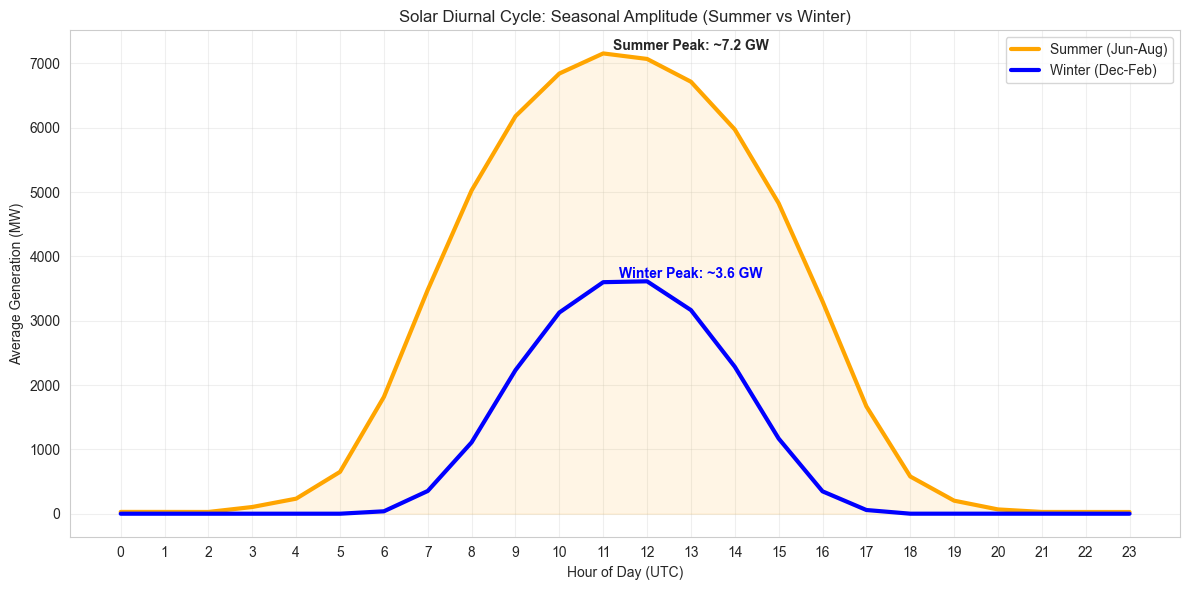

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import gc

def analyze_solar_production():
    print(">>> 9.2 SOLAR PRODUCTION ANALYSIS")
    
    years = [2019, 2020, 2021, 2022, 2023]
    print(f"Loading Solar data for: {years}...")
    
    df_list = []
    for y in years:
        f = f"../data/interim/production/production_realisation_{y}_long_utc.csv"
        try:
            cols = pd.read_csv(f, nrows=0).columns
            date_col = 'datetime' if 'datetime' in cols else 'start_date'
            
            df = pd.read_csv(f, usecols=[date_col, 'technology', 'value_mw'])
            df = df.rename(columns={date_col: 'ts', 'value_mw': 'mw'})
            df['ts'] = pd.to_datetime(df['ts'], utc=True)
            
            # Filter for Solar
            df = df[df['technology'] == 'Solaire']
            df_list.append(df)
        except: pass
        
    if not df_list: return
    df_solar = pd.concat(df_list)
    
    # Feature Engineering
    df_solar['hour'] = df_solar['ts'].dt.hour
    df_solar['month'] = df_solar['ts'].dt.month
    
    # Define Seasons
    def get_season(m):
        if m in [6, 7, 8]: return 'Summer (Jun-Aug)'
        if m in [12, 1, 2]: return 'Winter (Dec-Feb)'
        return 'Transition'
    
    df_solar['season'] = df_solar['month'].apply(get_season)
    
    # Aggregation for Plotting
    # Filter out Transition to show the contrast clearly
    df_plot = df_solar[df_solar['season'] != 'Transition']
    
    hourly_profile = df_plot.groupby(['season', 'hour'])['mw'].mean().reset_index()
    
    # --- Visualization: Diurnal Cycle & Amplitude ---
    plt.figure(figsize=(12, 6))
    
    sns.lineplot(data=hourly_profile, x='hour', y='mw', hue='season', 
                 palette={'Summer (Jun-Aug)': 'orange', 'Winter (Dec-Feb)': 'blue'},
                 linewidth=3)
    
    plt.fill_between(hourly_profile[hourly_profile['season']=='Summer (Jun-Aug)']['hour'], 
                     hourly_profile[hourly_profile['season']=='Summer (Jun-Aug)']['mw'], 
                     color='orange', alpha=0.1)
    
    plt.title("Solar Diurnal Cycle: Seasonal Amplitude (Summer vs Winter)")
    plt.ylabel("Average Generation (MW)")
    plt.xlabel("Hour of Day (UTC)")
    plt.xticks(range(0, 24))
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Annotation
    peak_summer = hourly_profile[hourly_profile['season']=='Summer (Jun-Aug)']['mw'].max()
    peak_winter = hourly_profile[hourly_profile['season']=='Winter (Dec-Feb)']['mw'].max()
    
    plt.text(13, peak_summer, f"Summer Peak: ~{peak_summer/1000:.1f} GW", ha='center', va='bottom', fontweight='bold')
    plt.text(13, peak_winter, f"Winter Peak: ~{peak_winter/1000:.1f} GW", ha='center', va='bottom', fontweight='bold', color='blue')
    
    plt.tight_layout()
    plt.show()

    del df_solar, df_list
    gc.collect()

analyze_solar_production()

Seasonality is strong:
summer midday peaks are roughly twice as high as winter peaks,
reflecting both irradiation and daylight duration effects.

Despite its predictability at the daily scale,
solar contributes little during winter evenings,
when demand peaks, limiting its capacity to reduce system stress.

# 10. Weather dependence (production)


## 10.1 Wind vs wind speed

Wind generation exhibits a clear non-linear dependence on wind speed.


>>> 10.1 WIND VS WIND SPEED (POWER CURVE) - CORRIGÉ
Loading data for: [2019, 2020, 2021, 2022, 2023]...
Data points fusionnés : 43,813


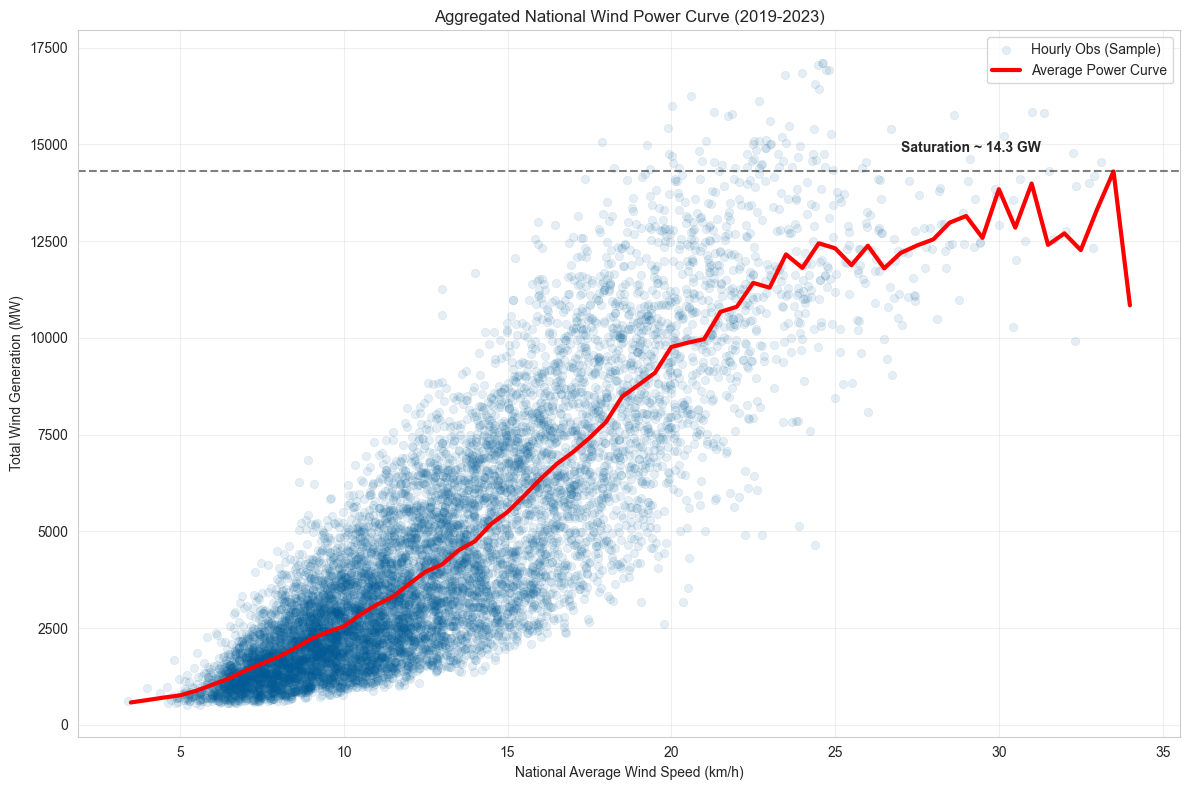

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import gc
import numpy as np

def analyze_wind_power_curve():
    print(">>> 10.1 WIND VS WIND SPEED (POWER CURVE) - CORRIGÉ")
    
    # Configuration
    years = [2019, 2020, 2021, 2022, 2023]
    
    print(f"Loading data for: {years}...")
    
    # --- A. Load Production (Hourly) ---
    prod_list = []
    
    for y in years:
        f = f"../data/interim/production/production_realisation_{y}_long_utc.csv"
        try:
            cols = pd.read_csv(f, nrows=0).columns
            date_col = 'datetime' if 'datetime' in cols else 'start_date'
            
            # Lecture optimisée
            df = pd.read_csv(f, usecols=[date_col, 'technology', 'value_mw'])
            df = df.rename(columns={date_col: 'ts', 'value_mw': 'mw'})
            df['ts'] = pd.to_datetime(df['ts'], utc=True)
            
            # FILTRE ROBUSTE (Correction Accents/Majuscules)
            # On cherche "olien" dans le nom (attrape 'Eolien', 'Éolien', etc.)
            mask_wind = df['technology'].str.contains('olien', case=False, na=False)
            df = df[mask_wind]
            
            if df.empty: continue
            
            # Somme Eolien (Terrestre + Mer) par timestamp
            df_total = df.groupby('ts')['mw'].sum()
            prod_list.append(df_total)
        except Exception as e:
            pass
        
    if not prod_list:
        print("ERREUR: Aucune donnée de production éolienne trouvée.")
        return

    s_wind = pd.concat(prod_list).sort_index()
    
    # CORRECTION CRITIQUE : Dédoublonnage de l'index avant merge
    s_wind = s_wind[~s_wind.index.duplicated(keep='first')]

    # --- B. Load Weather (National Wind Speed) ---
    weather_list = []
    for y in years:
        f = f"../data/raw/weather/weather_32_cities_{y}.csv"
        try:
            # On vérifie si la colonne existe (parfois 'wind_speed_10m' ou autre)
            # On assume ici le format standard fourni précédemment
            df = pd.read_csv(f, usecols=['date', 'wind_speed_10m'])
            df['ts'] = pd.to_datetime(df['date'], utc=True)
            
            # Moyenne sur les 32 villes pour avoir un "Index Vent National"
            hourly = df.groupby('ts')['wind_speed_10m'].mean()
            weather_list.append(hourly)
        except: pass
        
    if not weather_list: 
        print("ERREUR: Aucune donnée météo trouvée.")
        return

    s_weather = pd.concat(weather_list).sort_index()
    
    # CORRECTION CRITIQUE : Dédoublonnage de l'index avant merge
    s_weather = s_weather[~s_weather.index.duplicated(keep='first')]
    
    # --- C. Merge ---
    # Fusionner sur l'index (timestamp)
    # dropna() enlève les heures où il manque soit la prod, soit la météo
    df = pd.concat([s_wind, s_weather], axis=1).dropna()
    df.columns = ['mw', 'wind_speed']
    
    print(f"Data points fusionnés : {len(df):,}")
    
    if len(df) < 100:
        print("Trop peu de données pour tracer la courbe.")
        return
    
    # --- D. Binned Averages (La courbe théorique) ---
    # On crée des "bins" de vitesse de vent (par pas de 0.5 m/s)
    df['speed_bin'] = (df['wind_speed'] * 2).round() / 2
    curve = df.groupby('speed_bin')['mw'].mean().reset_index()
    
    # --- E. Visualization ---
    plt.figure(figsize=(12, 8))
    
    # 1. Nuage de points (Scatter)
    # On prend un échantillon pour ne pas saturer le graph (max 10k points)
    sample_size = min(10000, len(df))
    sns.scatterplot(data=df.sample(sample_size), x='wind_speed', y='mw', 
                    alpha=0.1, color='#005b96', edgecolor=None, label='Hourly Obs (Sample)')
    
    # 2. Courbe de Puissance (Moyenne par bin)
    plt.plot(curve['speed_bin'], curve['mw'], color='red', linewidth=3, label='Average Power Curve')
    
    plt.title("Aggregated National Wind Power Curve (2019-2023)")
    plt.xlabel("National Average Wind Speed (km/h)") # Vérifier si m/s ou km/h selon votre source
    plt.ylabel("Total Wind Generation (MW)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Annotation Saturation
    if not curve.empty:
        max_gen = curve['mw'].max()
        plt.axhline(max_gen, color='black', linestyle='--', alpha=0.5)
        plt.text(df['wind_speed'].max() * 0.8, max_gen + 500, f"Saturation ~ {max_gen/1000:.1f} GW", fontweight='bold')
    
    plt.tight_layout()
    plt.show()

    # Cleanup
    del df, s_wind, s_weather, prod_list, weather_list
    gc.collect()

analyze_wind_power_curve()

At low to moderate speeds, total wind production increases almost linearly, reflecting turbines operating below rated capacity. As wind speed rises further, production progressively **saturates**, reaching a plateau around the installed capacity limit (~14 GW). This saturation effect explains why very high wind speeds do not translate into proportional increases in generation.

The dispersion around the average power curve reflects spatial aggregation across regions, heterogeneous turbine characteristics, and local wind variability. Overall, wind speed is a strong explanatory variable, but the relationship is fundamentally non-linear and bounded.


## 10.2 Solar vs radiation

Solar production shows a strong and almost linear relationship with incoming solar radiation during daylight hours.


>>> 10.2 SOLAR VS RADIATION ANALYSIS
Loading data for: [2019, 2020, 2021, 2022, 2023]...
Merged 43,813 points. Radiation col used: 'direct_radiation'


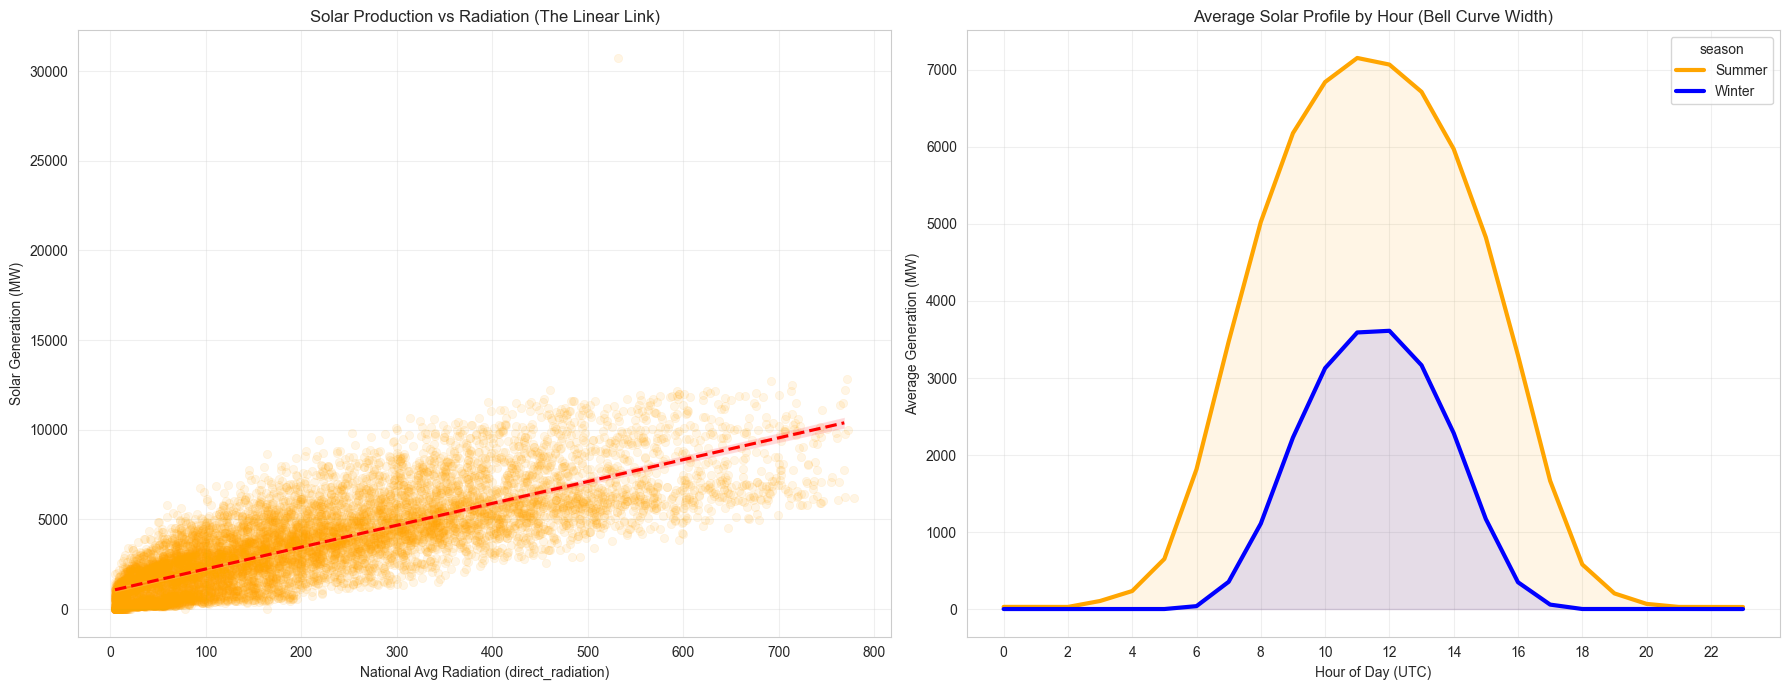

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import gc
import numpy as np

def analyze_solar_vs_radiation():
    print(">>> 10.2 SOLAR VS RADIATION ANALYSIS")
    
    # Configuration
    years = [2019, 2020, 2021, 2022, 2023]
    
    print(f"Loading data for: {years}...")
    
    # --- A. Load Solar Production ---
    prod_list = []
    for y in years:
        f = f"../data/interim/production/production_realisation_{y}_long_utc.csv"
        try:
            cols = pd.read_csv(f, nrows=0).columns
            date_col = 'datetime' if 'datetime' in cols else 'start_date'
            
            df = pd.read_csv(f, usecols=[date_col, 'technology', 'value_mw'])
            df = df.rename(columns={date_col: 'ts', 'value_mw': 'mw'})
            df['ts'] = pd.to_datetime(df['ts'], utc=True)
            
            # Robust Filter for Solar
            mask_solar = df['technology'].str.contains('Solaire', case=False, na=False)
            df = df[mask_solar]
            
            if df.empty: continue
            
            # Sum Solar per timestamp
            df_total = df.groupby('ts')['mw'].sum()
            prod_list.append(df_total)
        except: pass
        
    if not prod_list:
        print("ERREUR: Aucune donnée solaire trouvée.")
        return

    s_solar = pd.concat(prod_list).sort_index()
    # Deduplicate Index
    s_solar = s_solar[~s_solar.index.duplicated(keep='first')]

    # --- B. Load Weather (Radiation) ---
    weather_list = []
    rad_col_name = None 
    
    for y in years:
        f = f"../data/raw/weather/weather_32_cities_{y}.csv"
        try:
            # 1. Detect Radiation Column dynamically
            cols = pd.read_csv(f, nrows=0).columns
            # Common names: 'shortwave_radiation', 'surface_solar_radiation', 'radiation'
            candidates = [c for c in cols if 'rad' in c.lower() or 'sol' in c.lower()]
            if 'wind_speed_10m' in candidates: candidates.remove('wind_speed_10m') # Avoid wind
            
            if not candidates:
                continue
                
            rad_col = candidates[0] # Take the first match
            rad_col_name = rad_col
            
            # 2. Load
            df = pd.read_csv(f, usecols=['date', rad_col])
            df['ts'] = pd.to_datetime(df['date'], utc=True)
            
            # Average across 32 cities
            hourly = df.groupby('ts')[rad_col].mean()
            weather_list.append(hourly)
        except: pass
        
    if not weather_list: 
        print("ERREUR: Aucune colonne de radiation trouvée dans la météo.")
        return

    s_weather = pd.concat(weather_list).sort_index()
    s_weather = s_weather[~s_weather.index.duplicated(keep='first')]
    
    # --- C. Merge ---
    df = pd.concat([s_solar, s_weather], axis=1).dropna()
    df.columns = ['solar_mw', 'radiation']
    
    print(f"Merged {len(df):,} points. Radiation col used: '{rad_col_name}'")
    
    # --- D. Visualization ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    
    # Plot 1: Scatter (Solar vs Radiation)
    # We filter only daylight hours (Radiation > 0) to avoid the massive pile at (0,0)
    daylight = df[df['radiation'] > 5] 
    
    sns.scatterplot(data=daylight.sample(min(10000, len(daylight))), 
                    x='radiation', y='solar_mw', 
                    alpha=0.1, color='orange', edgecolor=None, ax=ax1)
    
    # Add Trend Line
    sns.regplot(data=daylight.sample(min(2000, len(daylight))), 
                x='radiation', y='solar_mw', scatter=False, color='red', ax=ax1, line_kws={'linestyle':'--'})
    
    ax1.set_title("Solar Production vs Radiation (The Linear Link)")
    ax1.set_xlabel(f"National Avg Radiation ({rad_col_name})")
    ax1.set_ylabel("Solar Generation (MW)")
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Solar vs Hour of Day (The Bell Curves)
    df['hour'] = df.index.hour
    df['month'] = df.index.month
    
    # Define simple seasons
    def get_season(m):
        if m in [6, 7, 8]: return 'Summer'
        if m in [12, 1, 2]: return 'Winter'
        return 'Transition'
    
    df['season'] = df['month'].apply(get_season)
    df_plot = df[df['season'] != 'Transition'] # Contrast extreme seasons
    
    # Aggregate mean profile
    profile = df_plot.groupby(['season', 'hour'])['solar_mw'].mean().reset_index()
    
    sns.lineplot(data=profile, x='hour', y='solar_mw', hue='season', 
                 palette={'Summer':'orange', 'Winter':'blue'}, linewidth=3, ax=ax2)
    
    # Fill area
    summer = profile[profile['season']=='Summer']
    winter = profile[profile['season']=='Winter']
    ax2.fill_between(summer['hour'], 0, summer['solar_mw'], color='orange', alpha=0.1)
    ax2.fill_between(winter['hour'], 0, winter['solar_mw'], color='blue', alpha=0.1)
    
    ax2.set_title("Average Solar Profile by Hour (Bell Curve Width)")
    ax2.set_xlabel("Hour of Day (UTC)")
    ax2.set_ylabel("Average Generation (MW)")
    ax2.set_xticks(range(0, 24, 2))
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    # Cleanup
    del df, s_solar, s_weather, prod_list, weather_list
    gc.collect()

analyze_solar_vs_radiation()


The scatter plot confirms radiation as the primary physical driver of solar output, with residual dispersion mainly due to cloud heterogeneity and spatial averaging. Nighttime observations collapse to zero production, reinforcing the deterministic nature of solar intermittency.

Hourly profiles highlight a bell-shaped daily cycle, with a wider and higher curve in summer and a narrower, lower peak in winter. Seasonality therefore affects both the **amplitude** and **duration** of solar generation, limiting its contribution to winter demand peaks.


## 10.3 Seasonal weather effects

This section compares **winter (January)** and **summer (July)** conditions to highlight the joint seasonal effects of weather on demand and renewable production.


>>> 10.3 SEASONAL WEATHER EFFECTS ANALYSIS
Aggregating multi-source data for [2019, 2020, 2021, 2022, 2023]...
Comparing Winter (Jan, n=3720) vs Summer (Jul, n=2976)


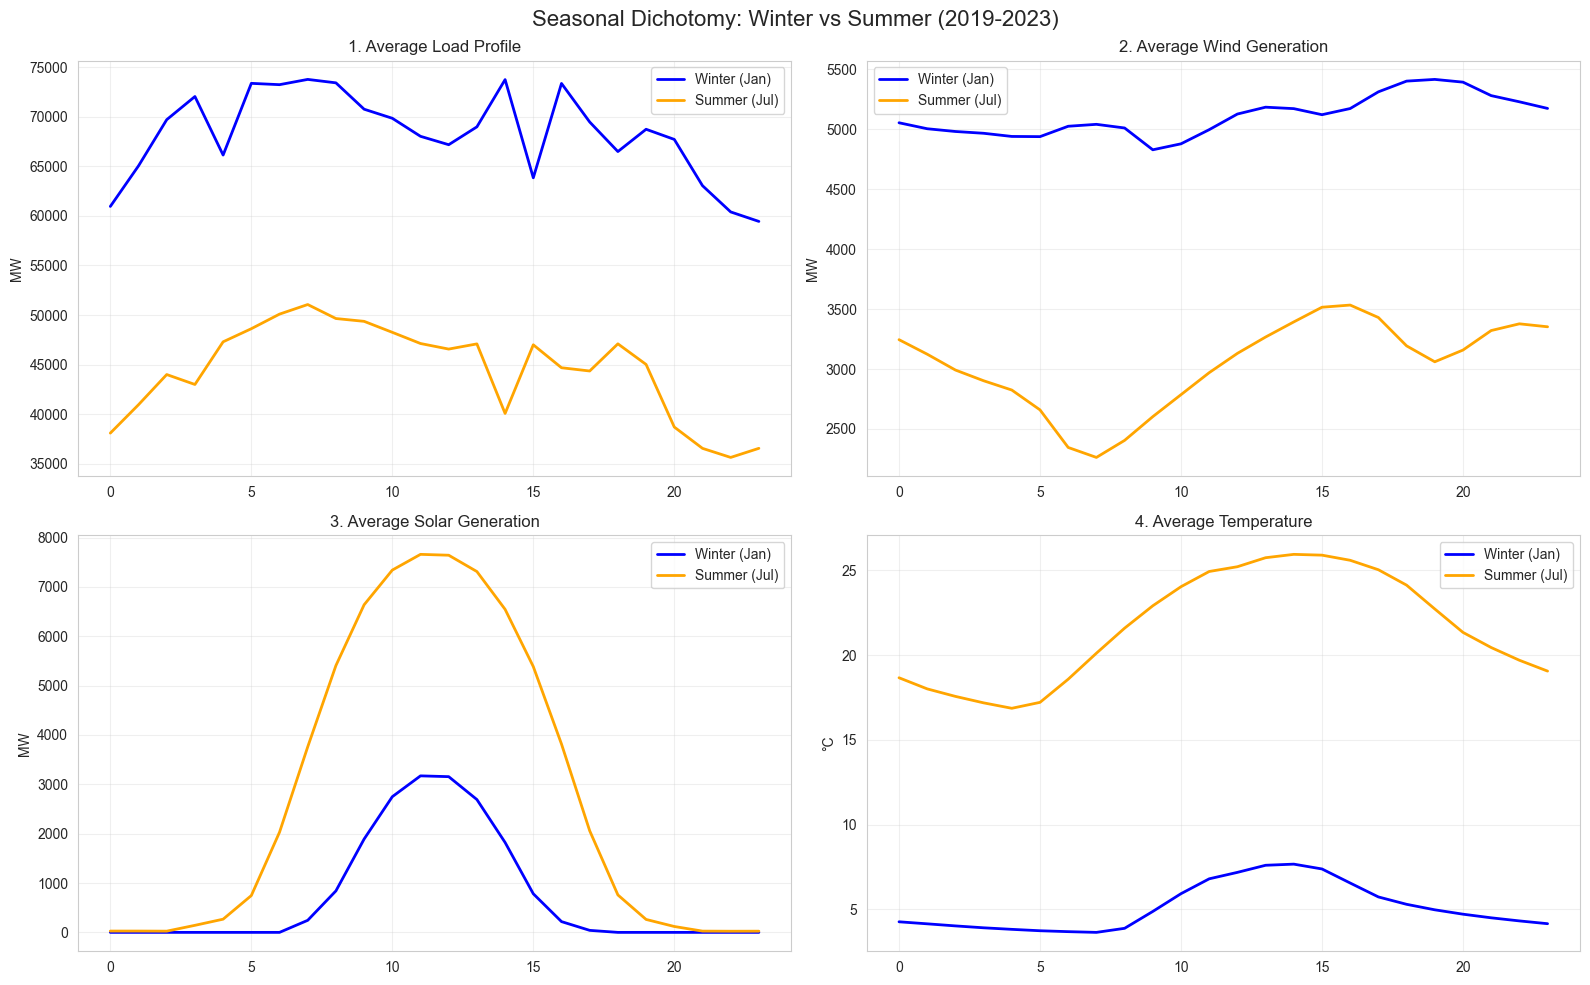

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import gc

def analyze_seasonal_weather_effects():
    print(">>> 10.3 SEASONAL WEATHER EFFECTS ANALYSIS")
    
    years = [2019, 2020, 2021, 2022, 2023]
    
    # We will build a single DataFrame with [ts, load, wind, solar, temp]
    # This requires loading multiple files and merging carefully.
    
    print(f"Aggregating multi-source data for {years}...")
    
    # 1. Load CONSUMPTION
    # -------------------
    cons_list = []
    for y in years:
        f = f"../data/interim/consommation/consommation_{y}_long_utc.csv"
        try:
            cols = pd.read_csv(f, nrows=0).columns
            date_col = 'datetime' if 'datetime' in cols else 'start_date'
            val_col = 'load_mw' if 'load_mw' in cols else 'consumption_mw'
            df = pd.read_csv(f, usecols=[date_col, val_col])
            df = df.rename(columns={date_col: 'ts', val_col: 'load'})
            df['ts'] = pd.to_datetime(df['ts'], utc=True)
            cons_list.append(df.set_index('ts'))
        except: pass
    if not cons_list: return
    df_load = pd.concat(cons_list)
    df_load = df_load[~df_load.index.duplicated(keep='first')]

    # 2. Load PRODUCTION (Wind + Solar)
    # ---------------------------------
    prod_list = []
    for y in years:
        f = f"../data/interim/production/production_realisation_{y}_long_utc.csv"
        try:
            cols = pd.read_csv(f, nrows=0).columns
            date_col = 'datetime' if 'datetime' in cols else 'start_date'
            df = pd.read_csv(f, usecols=[date_col, 'technology', 'value_mw'])
            df = df.rename(columns={date_col: 'ts', 'value_mw': 'mw'})
            df['ts'] = pd.to_datetime(df['ts'], utc=True)
            
            # Pivot manually or filter/group
            # Wind
            mask_wind = df['technology'].str.contains('olien', case=False, na=False)
            wind_hourly = df[mask_wind].groupby('ts')['mw'].sum()
            
            # Solar
            mask_solar = df['technology'].str.contains('Solaire', case=False, na=False)
            solar_hourly = df[mask_solar].groupby('ts')['mw'].sum()
            
            # Combine into a DF for this year
            df_prod = pd.concat([wind_hourly, solar_hourly], axis=1)
            df_prod.columns = ['wind', 'solar']
            prod_list.append(df_prod)
        except: pass
    if not prod_list: return
    df_prod = pd.concat(prod_list)
    df_prod = df_prod[~df_prod.index.duplicated(keep='first')]
    
    # 3. Load WEATHER (Temp)
    # ----------------------
    weather_list = []
    for y in years:
        f = f"../data/raw/weather/weather_32_cities_{y}.csv"
        try:
            df = pd.read_csv(f, usecols=['date', 'temperature_2m'])
            df['ts'] = pd.to_datetime(df['date'], utc=True)
            hourly = df.groupby('ts')['temperature_2m'].mean()
            weather_list.append(hourly)
        except: pass
    if not weather_list: return
    df_weather = pd.concat(weather_list)
    df_weather = df_weather[~df_weather.index.duplicated(keep='first')]
    df_weather.name = 'temp'

    # 4. MERGE ALL
    # ------------
    df = pd.concat([df_load, df_prod, df_weather], axis=1).dropna()
    
    # 5. SEASONAL ANALYSIS (Winter vs Summer)
    # ---------------------------------------
    df['hour'] = df.index.hour
    df['month'] = df.index.month
    
    # Define distinct seasons (Jan vs Jul)
    winter_mask = df['month'] == 1
    summer_mask = df['month'] == 7
    
    df_winter = df[winter_mask]
    df_summer = df[summer_mask]
    
    print(f"Comparing Winter (Jan, n={len(df_winter)}) vs Summer (Jul, n={len(df_summer)})")
    
    # Aggregate Daily Profiles
    prof_winter = df_winter.groupby('hour').mean()
    prof_summer = df_summer.groupby('hour').mean()
    
    # 6. VISUALIZATION
    # ----------------
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # A. Load Profile
    axes[0, 0].plot(prof_winter.index, prof_winter['load'], label='Winter (Jan)', color='blue', linewidth=2)
    axes[0, 0].plot(prof_summer.index, prof_summer['load'], label='Summer (Jul)', color='orange', linewidth=2)
    axes[0, 0].set_title("1. Average Load Profile")
    axes[0, 0].set_ylabel("MW")
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # B. Wind Profile
    axes[0, 1].plot(prof_winter.index, prof_winter['wind'], label='Winter (Jan)', color='blue', linewidth=2)
    axes[0, 1].plot(prof_summer.index, prof_summer['wind'], label='Summer (Jul)', color='orange', linewidth=2)
    axes[0, 1].set_title("2. Average Wind Generation")
    axes[0, 1].set_ylabel("MW")
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # C. Solar Profile
    axes[1, 0].plot(prof_winter.index, prof_winter['solar'], label='Winter (Jan)', color='blue', linewidth=2)
    axes[1, 0].plot(prof_summer.index, prof_summer['solar'], label='Summer (Jul)', color='orange', linewidth=2)
    axes[1, 0].set_title("3. Average Solar Generation")
    axes[1, 0].set_ylabel("MW")
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # D. Temperature Profile
    axes[1, 1].plot(prof_winter.index, prof_winter['temp'], label='Winter (Jan)', color='blue', linewidth=2)
    axes[1, 1].plot(prof_summer.index, prof_summer['temp'], label='Summer (Jul)', color='orange', linewidth=2)
    axes[1, 1].set_title("4. Average Temperature")
    axes[1, 1].set_ylabel("°C")
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle(f"Seasonal Dichotomy: Winter vs Summer ({years[0]}-{years[-1]})", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Cleanup
    del df, df_load, df_prod, df_weather
    gc.collect()

analyze_seasonal_weather_effects()



**Load.**  
Winter demand is structurally higher, with pronounced morning and evening peaks linked to heating. Summer demand is lower and flatter over the day.

**Wind.**  
Wind generation is higher and more regular in winter, reflecting stronger large-scale wind regimes. Summer wind output is lower on average.

**Solar.**  
Solar production shows the largest seasonal contrast: high and wide midday peaks in summer, very limited output in winter, concentrated around noon.

**Temperature.**  
The temperature gap between seasons explains both higher winter demand and the weak alignment between winter demand peaks and solar supply.

**colnclusion.**  
Winter combines high demand with limited solar and moderate wind, leading to tighter system conditions. Summer benefits from lower demand and strong solar generation.

# 11. Residual load and grid stress


## 11.1 Definition


Residual load is defined as:

**Residual load = Total load − (wind + solar)**

It represents the demand that must be met by **dispatchable sources** (nuclear, hydro, thermal, imports).


## 11.2 Residual load analysis

This section compares raw load and residual load to assess how renewables modify system stress.


>>> 11. RESIDUAL LOAD ANALYSIS
Loading data for: [2019, 2020, 2021, 2022, 2023]...
Computed 38,654 hourly points.


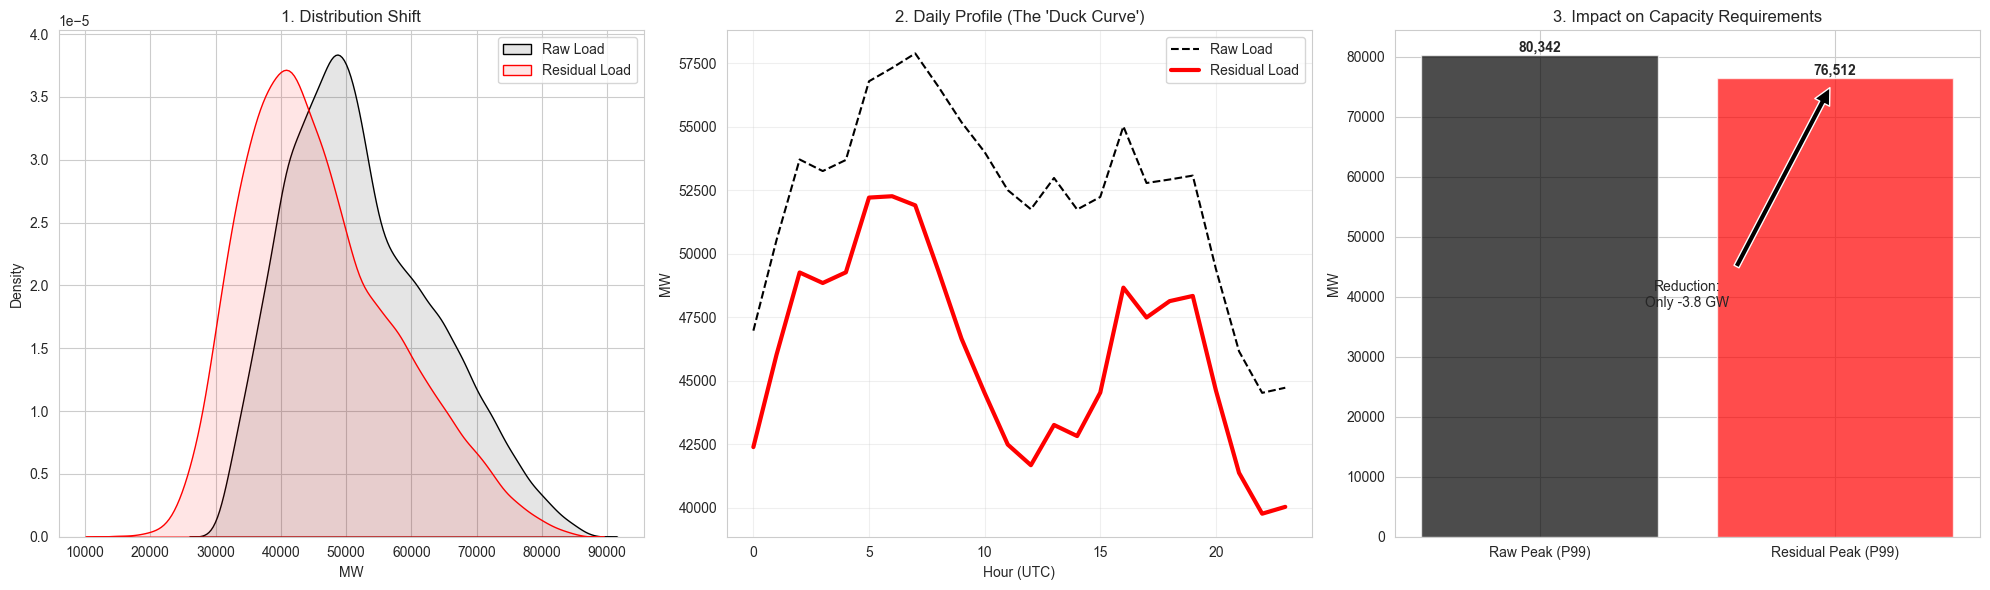


--- TOP 5 HIGHEST RESIDUAL LOAD MOMENTS (Grid Stress) ---
                              Load  Renewables  Residual_Load
ts                                                           
2021-01-11 03:00:00+00:00  87408.0      2119.0        85289.0
2021-01-11 05:00:00+00:00  87453.0      2234.0        85219.0
2022-01-14 05:00:00+00:00  86472.0      1316.0        85156.0
2021-01-08 05:00:00+00:00  86451.0      1334.0        85117.0
2022-01-14 03:00:00+00:00  86266.0      1377.0        84889.0


In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import gc

def analyze_residual_load():
    print(">>> 11. RESIDUAL LOAD ANALYSIS")
    
    years = [2019, 2020, 2021, 2022, 2023]
    print(f"Loading data for: {years}...")
    
    # 1. Load Consumption
    cons_list = []
    for y in years:
        f = f"../data/interim/consommation/consommation_{y}_long_utc.csv"
        try:
            cols = pd.read_csv(f, nrows=0).columns
            date_col = 'datetime' if 'datetime' in cols else 'start_date'
            val_col = 'load_mw' if 'load_mw' in cols else 'consumption_mw'
            df = pd.read_csv(f, usecols=[date_col, val_col])
            df = df.rename(columns={date_col: 'ts', val_col: 'load'})
            df['ts'] = pd.to_datetime(df['ts'], utc=True)
            cons_list.append(df.set_index('ts'))
        except: pass
    if not cons_list: return
    df_load = pd.concat(cons_list)
    df_load = df_load[~df_load.index.duplicated(keep='first')]

    # 2. Load Production (Wind + Solar)
    prod_list = []
    for y in years:
        f = f"../data/interim/production/production_realisation_{y}_long_utc.csv"
        try:
            cols = pd.read_csv(f, nrows=0).columns
            date_col = 'datetime' if 'datetime' in cols else 'start_date'
            df = pd.read_csv(f, usecols=[date_col, 'technology', 'value_mw'])
            df = df.rename(columns={date_col: 'ts', 'value_mw': 'mw'})
            df['ts'] = pd.to_datetime(df['ts'], utc=True)
            
            # Filter Wind OR Solar
            mask_renew = df['technology'].str.contains('olien|Solaire', case=False, na=False)
            df_renew = df[mask_renew].groupby('ts')['mw'].sum()
            prod_list.append(df_renew)
        except: pass
    if not prod_list: return
    df_prod = pd.concat(prod_list)
    df_prod = df_prod[~df_prod.index.duplicated(keep='first')]
    
    # 3. Merge & Compute Residual Load
    df = pd.concat([df_load, df_prod], axis=1).dropna()
    df.columns = ['Load', 'Renewables']
    
    df['Residual_Load'] = df['Load'] - df['Renewables']
    
    print(f"Computed {len(df):,} hourly points.")
    
    # --- VISUALIZATION ---
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # Plot 1: Distribution Comparison
    sns.kdeplot(df['Load'], color='black', fill=True, alpha=0.1, label='Raw Load', ax=axes[0])
    sns.kdeplot(df['Residual_Load'], color='red', fill=True, alpha=0.1, label='Residual Load', ax=axes[0])
    axes[0].set_title("1. Distribution Shift")
    axes[0].set_xlabel("MW")
    axes[0].legend()
    
    # Plot 2: Average Daily Profile (Duck Curve Effect)
    df['hour'] = df.index.hour
    profile = df.groupby('hour')[['Load', 'Residual_Load']].mean()
    
    axes[1].plot(profile.index, profile['Load'], 'k--', label='Raw Load')
    axes[1].plot(profile.index, profile['Residual_Load'], 'r-', linewidth=3, label='Residual Load')
    axes[1].set_title("2. Daily Profile (The 'Duck Curve')")
    axes[1].set_xlabel("Hour (UTC)")
    axes[1].set_ylabel("MW")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Plot 3: Extreme Peak Analysis
    # We compare the Top 1% of Raw Load vs Top 1% of Residual Load
    raw_peak = df['Load'].quantile(0.99)
    res_peak = df['Residual_Load'].quantile(0.99)
    
    bars = ['Raw Peak (P99)', 'Residual Peak (P99)']
    vals = [raw_peak, res_peak]
    
    axes[2].bar(bars, vals, color=['black', 'red'], alpha=0.7)
    axes[2].set_title("3. Impact on Capacity Requirements")
    axes[2].set_ylabel("MW")
    axes[2].text(0, raw_peak, f"{raw_peak:,.0f}", ha='center', va='bottom', fontweight='bold')
    axes[2].text(1, res_peak, f"{res_peak:,.0f}", ha='center', va='bottom', fontweight='bold')
    
    reduction = raw_peak - res_peak
    axes[2].annotate(f"Reduction:\nOnly -{reduction/1000:.1f} GW", 
                     xy=(1, res_peak), xytext=(0.5, res_peak*0.5),
                     arrowprops=dict(facecolor='black', shrink=0.05), ha='center')

    plt.tight_layout()
    plt.show()
    
    # List Top 5 Stress Moments
    top_stress = df.sort_values('Residual_Load', ascending=False).head(5)
    print("\n--- TOP 5 HIGHEST RESIDUAL LOAD MOMENTS (Grid Stress) ---")
    print(top_stress[['Load', 'Renewables', 'Residual_Load']])

    # Cleanup
    del df, df_load, df_prod, cons_list, prod_list
    gc.collect()

analyze_residual_load()

**Distribution.**  
The residual load distribution is shifted left relative to raw load, reflecting average demand reduction by wind and solar. The shift is substantial around the median but limited in the upper tail.

**Daily profile (duck curve).**  
Residual load is lower than raw load during daytime due to solar production, but remains high during morning and evening peaks. This creates a steeper intra-day profile and sharper ramps.

**Extreme peaks.**  
At the top 1% of hours, renewables reduce peak demand by only a few GW. Extreme stress events still occur during cold, low-renewable conditions.

**Interpretation.**  
Renewables reduce energy volumes but only marginally reduce peak capacity needs.


## 11.3 Comparison with raw load


>>> 11.3 COMPARISON WITH RAW LOAD (DURATION CURVES)
Loading data for: [2019, 2020, 2021, 2022, 2023]...
Analyzing 38,654 hours.


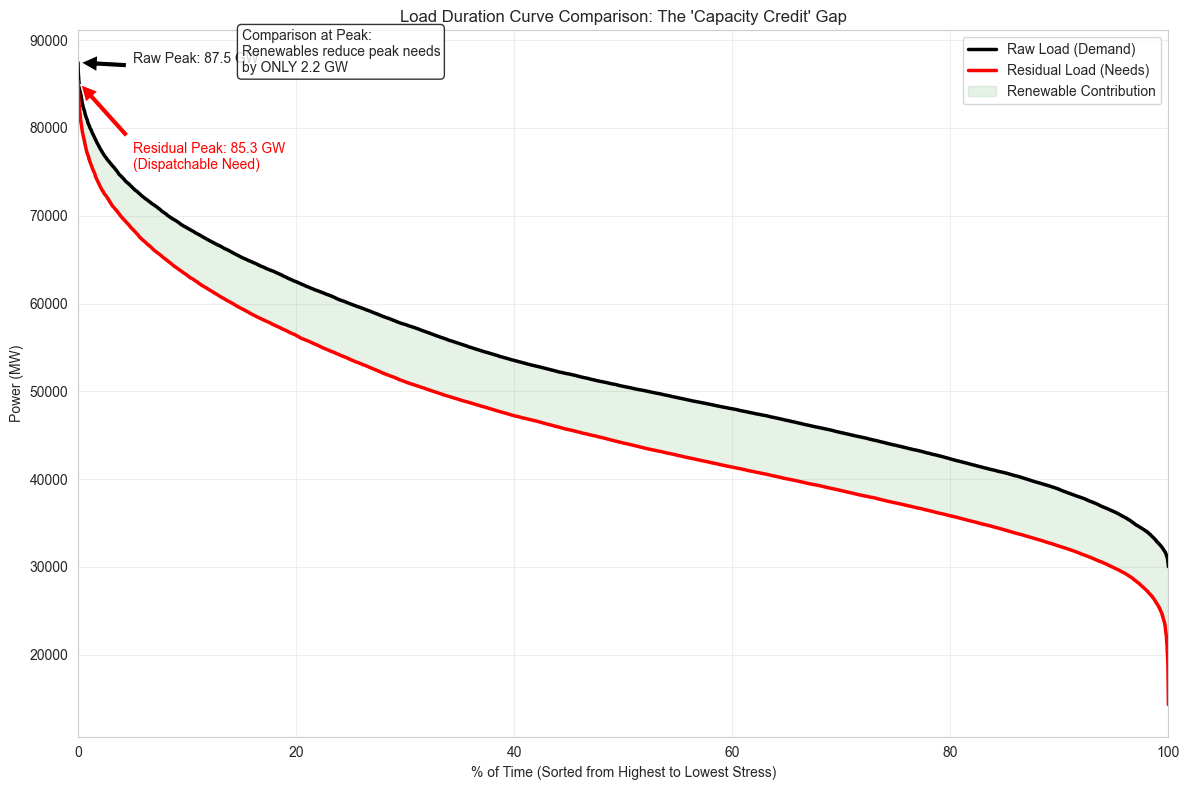


--- GRID STRESS STATISTICS ---
Metric               | Raw Load (MW)   | Residual Load (MW) | Delta (MW)     
---------------------------------------------------------------------------
Max Peak (P100)      | 87,453           | 85,289                | -2,164
Top 1% (P99)         | 80,342           | 76,512                | -3,830
Median (P50)         | 50,564           | 44,108                | -6,456
Volatility (Std)     | 11,247           | 11,775                | +528
---------------------------------------------------------------------------
Interpretation: High delta at Median (-Green), Low delta at Peak (-Red).


In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import gc
import numpy as np

def analyze_residual_vs_raw_comparison():
    print(">>> 11.3 COMPARISON WITH RAW LOAD (DURATION CURVES)")
    
    years = [2019, 2020, 2021, 2022, 2023]
    print(f"Loading data for: {years}...")
    
    # 1. Load Consumption (Raw Load)
    cons_list = []
    for y in years:
        f = f"../data/interim/consommation/consommation_{y}_long_utc.csv"
        try:
            cols = pd.read_csv(f, nrows=0).columns
            date_col = 'datetime' if 'datetime' in cols else 'start_date'
            val_col = 'load_mw' if 'load_mw' in cols else 'consumption_mw'
            df = pd.read_csv(f, usecols=[date_col, val_col])
            df = df.rename(columns={date_col: 'ts', val_col: 'load'})
            df['ts'] = pd.to_datetime(df['ts'], utc=True)
            cons_list.append(df.set_index('ts'))
        except: pass
    
    if not cons_list: return
    df_load = pd.concat(cons_list)
    df_load = df_load[~df_load.index.duplicated(keep='first')]

    # 2. Load Renewables (Wind + Solar)
    prod_list = []
    for y in years:
        f = f"../data/interim/production/production_realisation_{y}_long_utc.csv"
        try:
            cols = pd.read_csv(f, nrows=0).columns
            date_col = 'datetime' if 'datetime' in cols else 'start_date'
            
            # Robust loading
            df = pd.read_csv(f, usecols=[date_col, 'technology', 'value_mw'])
            df = df.rename(columns={date_col: 'ts', 'value_mw': 'mw'})
            df['ts'] = pd.to_datetime(df['ts'], utc=True)
            
            # Filter Wind OR Solar (Case insensitive regex)
            mask_renew = df['technology'].str.contains('olien|Solaire', case=False, na=False)
            if mask_renew.sum() == 0: continue
            
            df_renew = df[mask_renew].groupby('ts')['mw'].sum()
            prod_list.append(df_renew)
        except: pass
        
    if not prod_list: return
    df_prod = pd.concat(prod_list)
    df_prod = df_prod[~df_prod.index.duplicated(keep='first')]
    
    # 3. Merge & Compute
    df = pd.concat([df_load, df_prod], axis=1).dropna()
    df.columns = ['Raw Load', 'Renewables']
    df['Residual Load'] = df['Raw Load'] - df['Renewables']
    
    print(f"Analyzing {len(df):,} hours.")
    
    # --- VISUALIZATION: DURATION CURVES ---
    
    # 1. Sort values descending (Monotone)
    y_raw = df['Raw Load'].sort_values(ascending=False).values
    y_res = df['Residual Load'].sort_values(ascending=False).values
    x = np.linspace(0, 100, len(y_raw))
    
    # 2. Plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    ax.plot(x, y_raw, color='black', linewidth=2.5, label='Raw Load (Demand)')
    ax.plot(x, y_res, color='red', linewidth=2.5, label='Residual Load (Needs)')
    
    # Fill the gap (Renewable Contribution)
    ax.fill_between(x, y_raw, y_res, color='green', alpha=0.1, label='Renewable Contribution')
    
    ax.set_title("Load Duration Curve Comparison: The 'Capacity Credit' Gap")
    ax.set_xlabel("% of Time (Sorted from Highest to Lowest Stress)")
    ax.set_ylabel("Power (MW)")
    ax.set_xlim(0, 100)
    ax.grid(True, alpha=0.3)
    
    # 3. Zoom on the "Stress" (Top 1%)
    # We calculate the diff at P0 (Max) and P1 (Top 1%)
    max_raw = y_raw[0]
    max_res = y_res[0]
    
    # Annotation at P=0 (Absolute Peak)
    ax.annotate(f"Raw Peak: {max_raw/1000:.1f} GW", 
                xy=(0, max_raw), xytext=(5, max_raw), 
                arrowprops=dict(facecolor='black', shrink=0.05))
    
    ax.annotate(f"Residual Peak: {max_res/1000:.1f} GW\n(Dispatchable Need)", 
                xy=(0, max_res), xytext=(5, max_res - 10000), 
                arrowprops=dict(facecolor='red', shrink=0.05), color='red')
    
    # Annotation of the Gap
    gap = max_raw - max_res
    ax.text(15, (max_raw + max_res)/2, 
            f"Comparison at Peak:\nRenewables reduce peak needs\nby ONLY {gap/1000:.1f} GW", 
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8))

    ax.legend()
    plt.tight_layout()
    plt.show()
    
    # --- STATISTICS OUTPUT ---
    print("\n--- GRID STRESS STATISTICS ---")
    print(f"{'Metric':<20} | {'Raw Load (MW)':<15} | {'Residual Load (MW)':<15} | {'Delta (MW)':<15}")
    print("-" * 75)
    
    metrics = [
        ('Max Peak (P100)', df['Raw Load'].max(), df['Residual Load'].max()),
        ('Top 1% (P99)', df['Raw Load'].quantile(0.99), df['Residual Load'].quantile(0.99)),
        ('Median (P50)', df['Raw Load'].median(), df['Residual Load'].median()),
        ('Volatility (Std)', df['Raw Load'].std(), df['Residual Load'].std())
    ]
    
    for name, r, res in metrics:
        print(f"{name:<20} | {r:,.0f}           | {res:,.0f}                | {res-r:+,.0f}")
        
    print("-" * 75)
    print("Interpretation: High delta at Median (-Green), Low delta at Peak (-Red).")

    del df, df_load, df_prod
    gc.collect()

analyze_residual_vs_raw_comparison()

**Load duration curves.**  
The gap between raw and residual load is large for most hours but narrows significantly at the highest stress levels.

**Capacity credit gap.**  
At absolute peak, renewables reduce required capacity by ~2–3 GW, compared to much larger reductions at median load levels.

**Grid stress implication.**  
Wind and solar have high energy value but low firm capacity value. Dispatchable capacity remains driven by extreme residual load, not average conditions.


# Cross-cutting analysis


# 12. Calendar effects


## 12.1 Weekday effects



>>> 12.1 CALENDAR EFFECTS: WEEKDAY ANALYSIS (Final Fix)
Loading consumption data for: [2019, 2020, 2021, 2022, 2023]...


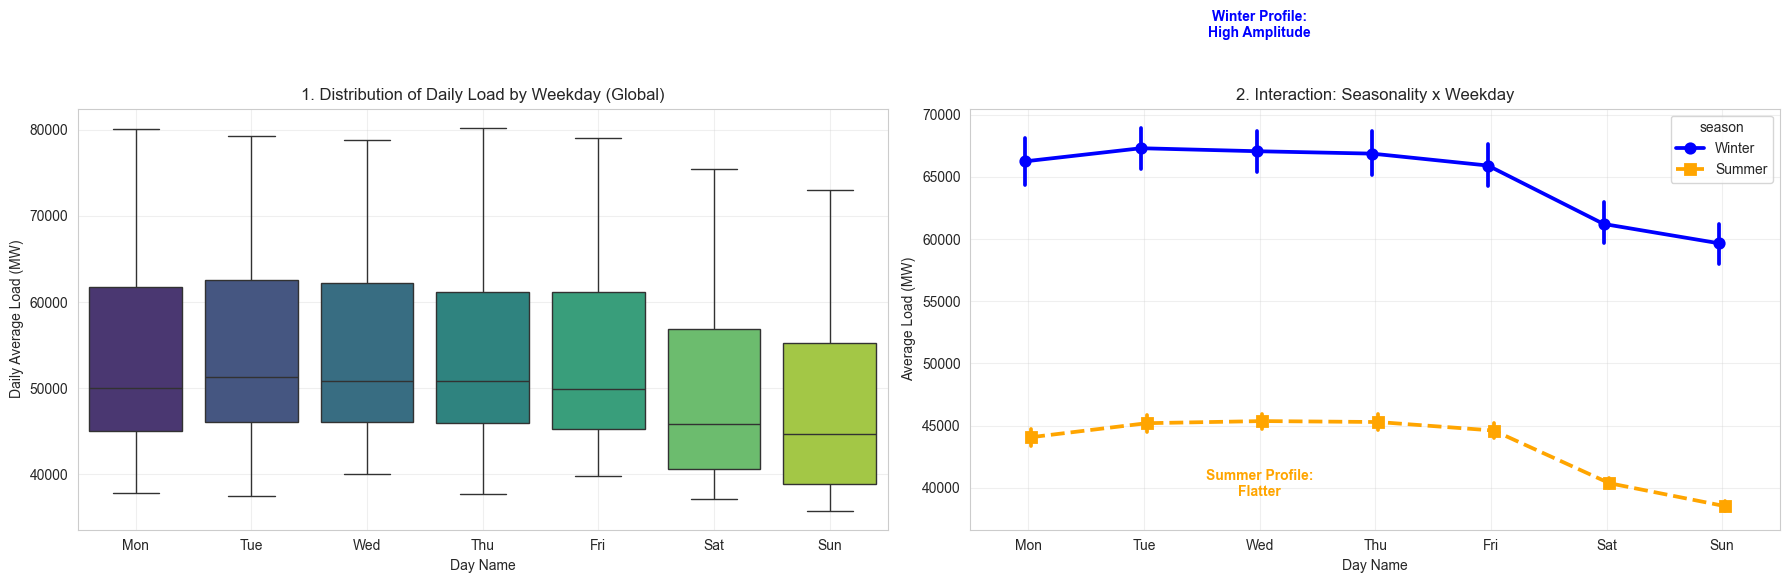


--- Mean Load by Day (MW) ---
Day Name
Mon    53396.0
Tue    54483.0
Wed    54392.0
Thu    54205.0
Fri    53521.0
Sat    49074.0
Sun    47498.0
Name: load, dtype: float64


In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import gc

def analyze_weekday_effects():
    print(">>> 12.1 CALENDAR EFFECTS: WEEKDAY ANALYSIS (Final Fix)")
    
    years = [2019, 2020, 2021, 2022, 2023]
    print(f"Loading consumption data for: {years}...")
    
    # 1. Load Data
    cons_list = []
    for y in years:
        f = f"../data/interim/consommation/consommation_{y}_long_utc.csv"
        try:
            cols = pd.read_csv(f, nrows=0).columns
            date_col = 'datetime' if 'datetime' in cols else 'start_date'
            val_col = 'load_mw' if 'load_mw' in cols else 'consumption_mw'
            
            df = pd.read_csv(f, usecols=[date_col, val_col])
            df = df.rename(columns={date_col: 'ts', val_col: 'load'})
            df['ts'] = pd.to_datetime(df['ts'], utc=True)
            
            # Resample to Daily Mean
            daily = df.set_index('ts').resample('D')['load'].mean().reset_index()
            cons_list.append(daily)
        except: pass
        
    if not cons_list: return
    df = pd.concat(cons_list)
    
    # CRITICAL FIX 1: Dédoublonnage sur la date
    df = df[~df['ts'].duplicated(keep='first')]
    
    # CRITICAL FIX 2: Réinitialisation de l'index du DataFrame
    # C'est ce qui causait l'erreur "duplicate labels" dans Seaborn
    df = df.reset_index(drop=True)

    # 2. Feature Engineering
    df['dow'] = df['ts'].dt.dayofweek # 0=Mon, 6=Sun
    df['month'] = df['ts'].dt.month
    
    # Define Season
    def get_season(m):
        if m in [12, 1, 2]: return 'Winter'
        if m in [6, 7, 8]: return 'Summer'
        return 'Transition'
    
    df['season'] = df['month'].apply(get_season)
    
    # Map DOW
    day_map = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
    df['Day Name'] = df['dow'].map(day_map)
    
    # 3. Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # Plot A: Global Boxplot
    sns.boxplot(data=df, x='Day Name', y='load', hue='Day Name', 
                ax=ax1, palette="viridis", order=day_map.values(), legend=False)
    
    ax1.set_title("1. Distribution of Daily Load by Weekday (Global)")
    ax1.set_ylabel("Daily Average Load (MW)")
    ax1.grid(True, alpha=0.3)
    
    # Plot B: Interaction with Seasonality
    df_interaction = df[df['season'] != 'Transition']
    
    sns.pointplot(data=df_interaction, x='Day Name', y='load', hue='season', 
                  order=day_map.values(), ax=ax2, dodge=True, 
                  palette={'Winter': 'blue', 'Summer': 'orange'},
                  markers=['o', 's'], linestyles=['-', '--'])
    
    ax2.set_title("2. Interaction: Seasonality x Weekday")
    ax2.set_ylabel("Average Load (MW)")
    ax2.grid(True, alpha=0.3)
    
    y_max = df_interaction['load'].max()
    y_min = df_interaction['load'].min()
    
    # Annotations dynamiques
    ax2.text(2, y_max * 0.95, "Winter Profile:\nHigh Amplitude", color='blue', ha='center', fontweight='bold')
    ax2.text(2, y_min * 1.1, "Summer Profile:\nFlatter", color='orange', ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Stats
    print("\n--- Mean Load by Day (MW) ---")
    stats = df.groupby('Day Name')['load'].mean().reindex(day_map.values())
    print(stats.round(0))

    del df, cons_list
    gc.collect()

analyze_weekday_effects()

**Weekday structure.**  
Load is highest mid-week (Tue–Thu), slightly lower on Monday and Friday, and drops sharply on weekends.

**Magnitude.**  
Average daily load:
- Tue–Thu ≈ highest
- Mon/Fri ≈ −1 to −2 GW vs mid-week
- Sat ≈ −4.5 GW vs weekday average
- Sun ≈ −6 GW vs weekday average

**Seasonal interaction.**  
- **Winter:** strong weekday/weekend contrast, high amplitude.
- **Summer:** flatter profile, weaker weekday effects.

**Implication.**  
Day-of-week effects are structural and must be encoded explicitly in load models, with season-dependent strength.


## 12.2 Holidays and vacations



>>> 12.2 CALENDAR EFFECTS: HOLIDAYS & VACATIONS (Corrected)
Loading consumption data for: [2019, 2020, 2021, 2022, 2023]...


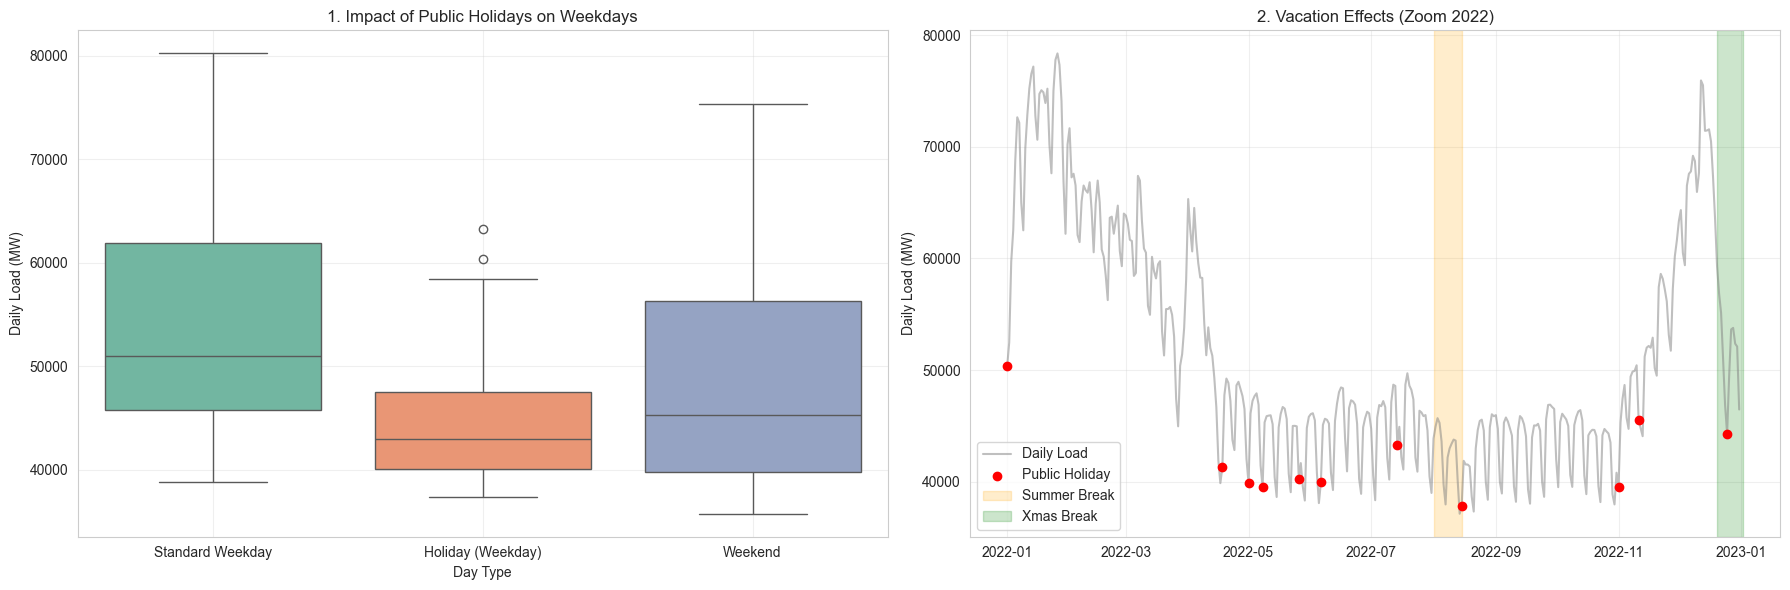


--- QUANTIFIED IMPACT ---
Average Standard Weekday Load: 54,286 MW
Average Holiday (Weekday) Load: 44,838 MW
Impact: -17.4% drop (Holiday behaves like a Sunday)


In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import gc

# On utilise la librairie 'holidays' si dispo, sinon fallback manuel
try:
    import holidays
    has_holidays_lib = True
except ImportError:
    has_holidays_lib = False
    print("library 'holidays' not found. Using manual basic list.")

def analyze_holiday_effects():
    print(">>> 12.2 CALENDAR EFFECTS: HOLIDAYS & VACATIONS (Corrected)")
    
    years = [2019, 2020, 2021, 2022, 2023]
    print(f"Loading consumption data for: {years}...")
    
    # 1. Load Data
    cons_list = []
    for y in years:
        f = f"../data/interim/consommation/consommation_{y}_long_utc.csv"
        try:
            cols = pd.read_csv(f, nrows=0).columns
            date_col = 'datetime' if 'datetime' in cols else 'start_date'
            val_col = 'load_mw' if 'load_mw' in cols else 'consumption_mw'
            
            df = pd.read_csv(f, usecols=[date_col, val_col])
            df = df.rename(columns={date_col: 'ts', val_col: 'load'})
            df['ts'] = pd.to_datetime(df['ts'], utc=True)
            
            # Resample to Daily Mean
            daily = df.set_index('ts').resample('D')['load'].mean().reset_index()
            cons_list.append(daily)
        except: pass
        
    if not cons_list: return
    df = pd.concat(cons_list)
    
    # CRITICAL FIX 1: Dédoublonnage sur la date
    df = df[~df['ts'].duplicated(keep='first')].sort_values('ts')
    
    # CRITICAL FIX 2: Réinitialisation de l'index unique (pour corriger l'erreur Seaborn)
    df = df.reset_index(drop=True)
    
    # 2. Feature Engineering: Identify Holidays
    fr_holidays = []
    if has_holidays_lib:
        # On charge les jours fériés pour les années concernées
        fr_holidays_obj = holidays.France(years=years)
        df['is_holiday'] = df['ts'].dt.date.apply(lambda x: x in fr_holidays_obj)
        df['holiday_name'] = df['ts'].dt.date.apply(lambda x: fr_holidays_obj.get(x))
    else:
        # Fallback manuel basique
        fixed_dates = [(1,1), (5,1), (5,8), (7,14), (8,15), (11,1), (11,11), (12,25)]
        df['is_holiday'] = df['ts'].apply(lambda x: (x.month, x.day) in fixed_dates)
        df['holiday_name'] = 'Holiday'
    
    # Identify Weekends vs Weekdays
    df['dow'] = df['ts'].dt.dayofweek
    df['is_weekend'] = df['dow'] >= 5
    
    mask_std_weekday = (~df['is_weekend']) & (~df['is_holiday'])
    mask_holiday_weekday = (~df['is_weekend']) & (df['is_holiday'])
    
    # Create Category for Plotting
    df['Day Type'] = 'Weekend'
    df.loc[mask_std_weekday, 'Day Type'] = 'Standard Weekday'
    df.loc[mask_holiday_weekday, 'Day Type'] = 'Holiday (Weekday)'
    
    # 3. Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # Plot A: Boxplot Impact Comparison
    order = ['Standard Weekday', 'Holiday (Weekday)', 'Weekend']
    
    # FIX: Ajout de hue='Day Type' et legend=False pour éviter le warning futur
    sns.boxplot(data=df, x='Day Type', y='load', hue='Day Type', 
                order=order, palette='Set2', ax=ax1, legend=False)
    
    ax1.set_title("1. Impact of Public Holidays on Weekdays")
    ax1.set_ylabel("Daily Load (MW)")
    ax1.grid(True, alpha=0.3)
    
    # Plot B: The "Vacation Dip" (Zoom sur une année récente)
    zoom_year = 2022
    # Filtre sur l'année pour le zoom
    df_zoom = df[df['ts'].dt.year == zoom_year].copy()
    
    if not df_zoom.empty:
        ax2.plot(df_zoom['ts'], df_zoom['load'], color='gray', alpha=0.5, label='Daily Load')
        
        # Highlight Holidays in Red
        holidays_zoom = df_zoom[df_zoom['is_holiday']]
        ax2.scatter(holidays_zoom['ts'], holidays_zoom['load'], color='red', zorder=5, label='Public Holiday')
        
        # Highlight August 1-15 (Summer Break)
        ax2.axvspan(pd.Timestamp(f'{zoom_year}-08-01', tz='UTC'), 
                    pd.Timestamp(f'{zoom_year}-08-15', tz='UTC'), 
                    color='orange', alpha=0.2, label='Summer Break')
        
        # Highlight Dec 20 - Jan 2 (Christmas Break)
        ax2.axvspan(pd.Timestamp(f'{zoom_year}-12-20', tz='UTC'), 
                    pd.Timestamp(f'{zoom_year+1}-01-02', tz='UTC'), 
                    color='green', alpha=0.2, label='Xmas Break')
        
        ax2.set_title(f"2. Vacation Effects (Zoom {zoom_year})")
        ax2.set_ylabel("Daily Load (MW)")
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Stats
    mean_std = df[mask_std_weekday]['load'].mean()
    mean_hol = df[mask_holiday_weekday]['load'].mean()
    drop = (mean_hol - mean_std) / mean_std * 100
    
    print("\n--- QUANTIFIED IMPACT ---")
    print(f"Average Standard Weekday Load: {mean_std:,.0f} MW")
    print(f"Average Holiday (Weekday) Load: {mean_hol:,.0f} MW")
    print(f"Impact: {drop:.1f}% drop (Holiday behaves like a Sunday)")

    del df, cons_list
    gc.collect()

analyze_holiday_effects()

**Public holidays (weekdays).**  
Weekday holidays exhibit a large demand drop:
- −17% vs standard weekdays
- Comparable to a Sunday profile

**Vacations.**  
- **August:** persistent demand dip (industrial + tertiary slowdown).
- **Christmas period:** clear multi-day reduction around year-end.

**Implication.**  
Calendar effects are not marginal noise:
- Holidays behave as regime shifts, not outliers.
- Vacation periods introduce sustained level changes that standard seasonality does not capture.

# 13. Temporal dependence


## 13.1 Autocorrelation


>>> 13.1 TEMPORAL DEPENDENCE: ACF / PACF
Loading data for year: 2022...
Data prepared: 8758 hourly points.


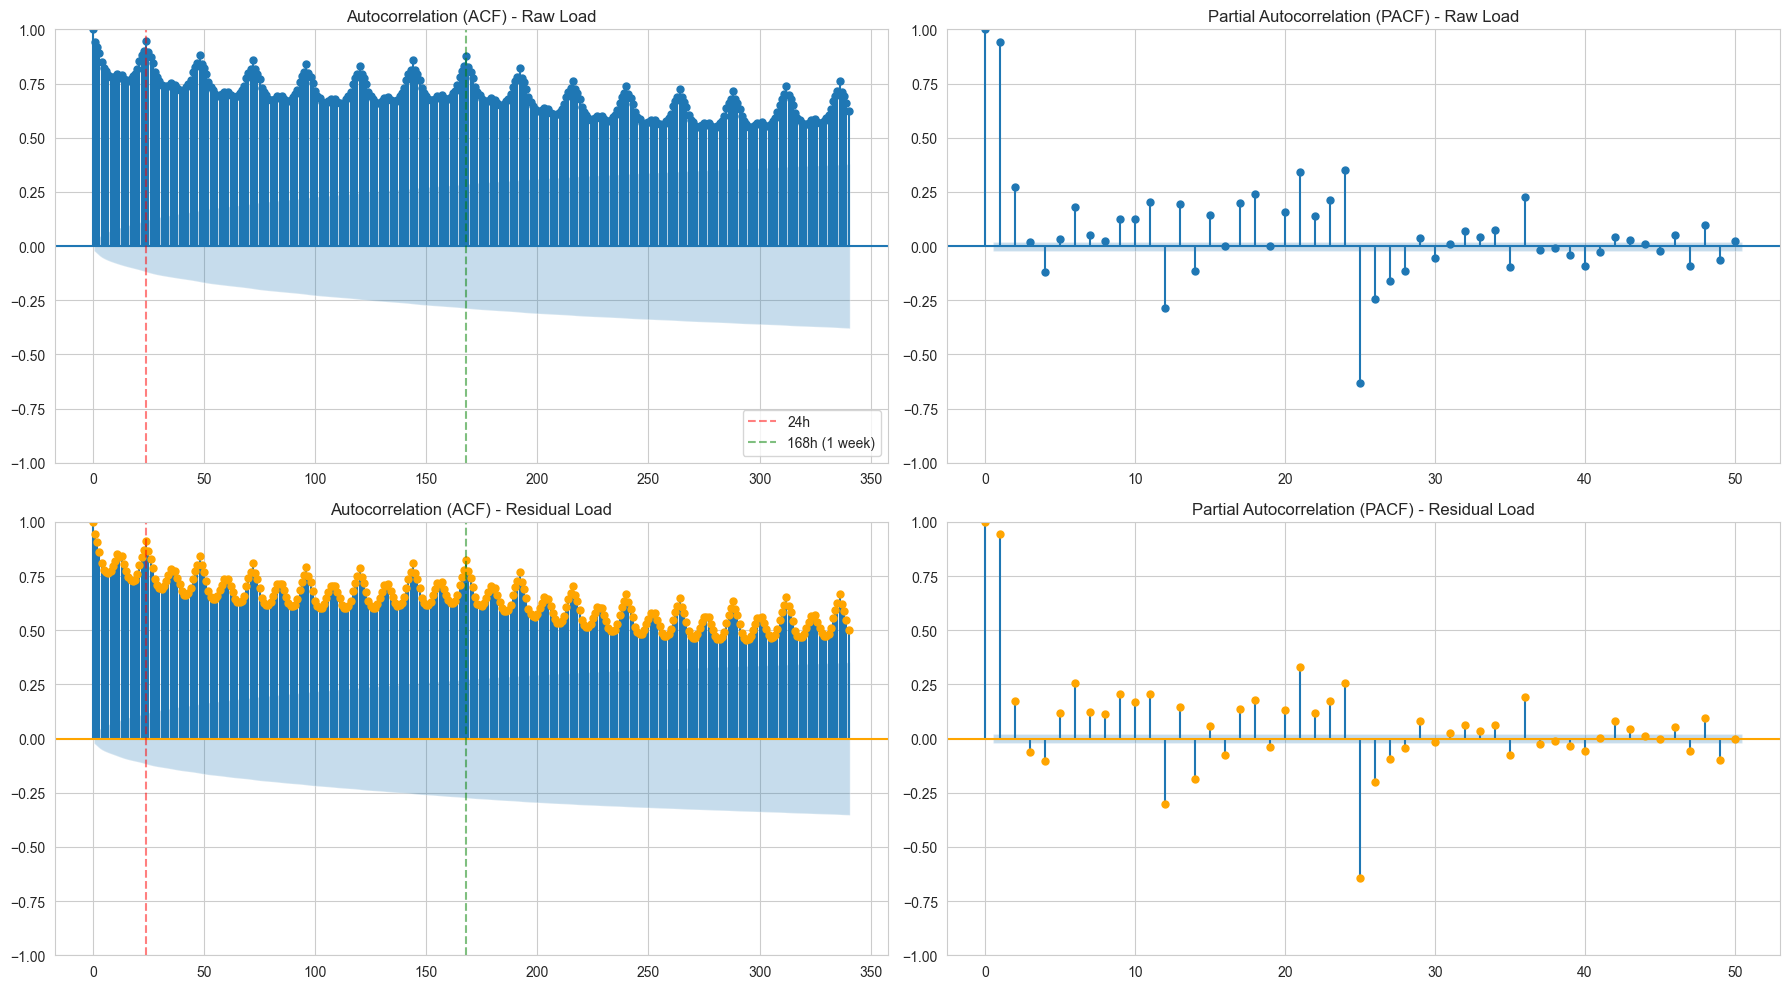


--- Key Autocorrelations (Raw Load) ---
Lag 24h (Daily Cycle): 0.9452
Lag 168h (Weekly Cycle): 0.8948


In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import gc

def analyze_autocorrelation():
    print(">>> 13.1 TEMPORAL DEPENDENCE: ACF / PACF")
    
    # We focus on one representative year (2022) to keep calculations fast and clear
    year = 2022
    print(f"Loading data for year: {year}...")
    
    # 1. Load Consumption (Raw Load)
    f_load = f"../data/interim/consommation/consommation_{year}_long_utc.csv"
    try:
        df_load = pd.read_csv(f_load)
        cols = df_load.columns
        date_col = 'datetime' if 'datetime' in cols else 'start_date'
        val_col = 'load_mw' if 'load_mw' in cols else 'consumption_mw'
        
        df_load = df_load.rename(columns={date_col: 'ts', val_col: 'Load'})
        df_load['ts'] = pd.to_datetime(df_load['ts'], utc=True)
        df_load = df_load.set_index('ts')[['Load']]
    except:
        print("Error loading consumption data.")
        return

    # 2. Load Production (Renewables for Residual Load)
    f_prod = f"../data/interim/production/production_realisation_{year}_long_utc.csv"
    try:
        df_prod = pd.read_csv(f_prod)
        cols = df_prod.columns
        date_col = 'datetime' if 'datetime' in cols else 'start_date'
        
        df_prod = df_prod.rename(columns={date_col: 'ts', 'value_mw': 'mw'})
        df_prod['ts'] = pd.to_datetime(df_prod['ts'], utc=True)
        
        # Filter Wind + Solar
        mask_renew = df_prod['technology'].str.contains('olien|Solaire', case=False, na=False)
        df_renew = df_prod[mask_renew].groupby('ts')['mw'].sum()
        
    except:
        print("Error loading production data.")
        return
        
    # 3. Compute Residual Load
    # Align indexes
    df = pd.concat([df_load, df_renew], axis=1).dropna()
    df.columns = ['Load', 'Renewables']
    df['Residual Load'] = df['Load'] - df['Renewables']
    
    # Deduplicate
    df = df[~df.index.duplicated(keep='first')]
    
    print(f"Data prepared: {len(df)} hourly points.")

    # 4. Visualization (ACF / PACF)
    # We look at 2 weeks of lags (14 days * 24h = 336 lags)
    lags_to_plot = 340 
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 10))
    
    # --- ROW 1: Raw Load ---
    plot_acf(df['Load'], ax=axes[0, 0], lags=lags_to_plot, title='Autocorrelation (ACF) - Raw Load', alpha=0.05)
    plot_pacf(df['Load'], ax=axes[0, 1], lags=50, title='Partial Autocorrelation (PACF) - Raw Load', method='ywm')
    
    # Highlight peaks on ACF
    axes[0, 0].axvline(24, color='red', linestyle='--', alpha=0.5, label='24h')
    axes[0, 0].axvline(168, color='green', linestyle='--', alpha=0.5, label='168h (1 week)')
    axes[0, 0].legend()
    
    # --- ROW 2: Residual Load ---
    plot_acf(df['Residual Load'], ax=axes[1, 0], lags=lags_to_plot, title='Autocorrelation (ACF) - Residual Load', alpha=0.05, color='orange')
    plot_pacf(df['Residual Load'], ax=axes[1, 1], lags=50, title='Partial Autocorrelation (PACF) - Residual Load', method='ywm', color='orange')
    
    # Highlight peaks
    axes[1, 0].axvline(24, color='red', linestyle='--', alpha=0.5)
    axes[1, 0].axvline(168, color='green', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Stats
    corr_24 = df['Load'].autocorr(lag=24)
    corr_168 = df['Load'].autocorr(lag=168)
    
    print(f"\n--- Key Autocorrelations (Raw Load) ---")
    print(f"Lag 24h (Daily Cycle): {corr_24:.4f}")
    print(f"Lag 168h (Weekly Cycle): {corr_168:.4f}")

    del df, df_load, df_prod
    gc.collect()

analyze_autocorrelation()

**Raw load.**  
- Very strong persistence.
- Clear daily (24h) and weekly (168h) cycles.
- ACF decays slowly → strong temporal structure.
- PACF shows dominant short lags + seasonal lags → autoregressive behavior with seasonality.

**Residual load.**  
- Autocorrelation remains high but weaker than raw load.
- Daily and weekly cycles persist after removing wind and solar.
- PACF still shows short-term dependence and seasonal structure.

**Key values (raw load).**  
- Lag 24h: ≈ 0.95  
- Lag 168h: ≈ 0.89  

**Implication.**  
Load dynamics are highly predictable in time. Removing renewables does not remove temporal dependence, only reduces its amplitude. Time-lag features (daily/weekly) are essential for forecasting.

## 13.2 Lag correlations


- Correlation at 24h, 48h, 168h


>>> 13.2 LAG CORRELATIONS (24h, 48h, 168h)
Loading data for year: 2022...

--- Correlation Results (Pearson) ---
Load vs Lag 24h: 0.9452
Load vs Lag 48h: 0.8841
Load vs Lag 168h: 0.8948
Residual Load vs Lag 24h: 0.9159
Residual Load vs Lag 48h: 0.8445
Residual Load vs Lag 168h: 0.8425


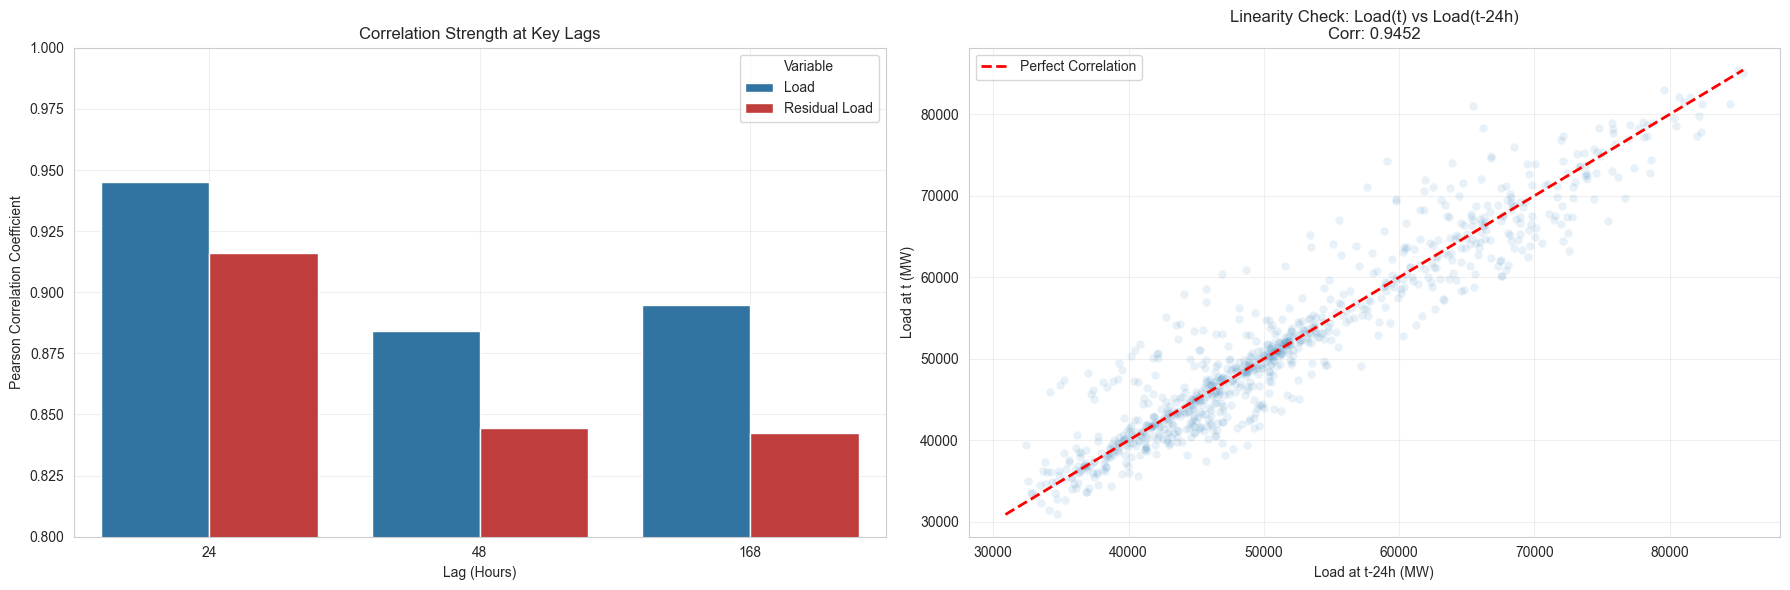

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import gc
import numpy as np

def analyze_lag_correlations():
    print(">>> 13.2 LAG CORRELATIONS (24h, 48h, 168h)")
    
    # We focus on a representative year (e.g., 2022)
    year = 2022
    print(f"Loading data for year: {year}...")
    
    # 1. Load Consumption
    try:
        f_load = f"../data/interim/consommation/consommation_{year}_long_utc.csv"
        df_load = pd.read_csv(f_load)
        col_date = 'datetime' if 'datetime' in df_load.columns else 'start_date'
        col_val = 'load_mw' if 'load_mw' in df_load.columns else 'consumption_mw'
        
        df_load = df_load.rename(columns={col_date: 'ts', col_val: 'Load'})
        df_load['ts'] = pd.to_datetime(df_load['ts'], utc=True)
        df_load = df_load.set_index('ts')[['Load']]
    except:
        print("Error loading load data.")
        return

    # 2. Load Production (for Residual)
    try:
        f_prod = f"../data/interim/production/production_realisation_{year}_long_utc.csv"
        df_prod = pd.read_csv(f_prod)
        col_date = 'datetime' if 'datetime' in df_prod.columns else 'start_date'
        
        df_prod = df_prod.rename(columns={col_date: 'ts', 'value_mw': 'mw'})
        df_prod['ts'] = pd.to_datetime(df_prod['ts'], utc=True)
        
        # Filter Renewables
        mask_renew = df_prod['technology'].str.contains('olien|Solaire', case=False, na=False)
        df_renew = df_prod[mask_renew].groupby('ts')['mw'].sum()
    except:
        print("Error loading production data.")
        return
        
    # 3. Merge & Compute Residual
    df = pd.concat([df_load, df_renew], axis=1).dropna()
    df.columns = ['Load', 'Renewables']
    df['Residual Load'] = df['Load'] - df['Renewables']
    
    # Deduplicate index
    df = df[~df.index.duplicated(keep='first')]

    # 4. Calculate Correlations
    lags = [24, 48, 168]
    targets = ['Load', 'Residual Load']
    results = []

    print("\n--- Correlation Results (Pearson) ---")
    for target in targets:
        for lag in lags:
            # Shift the data to align t with t-lag
            series_lagged = df[target].shift(lag)
            corr = df[target].corr(series_lagged)
            
            results.append({
                'Variable': target,
                'Lag (Hours)': str(lag),
                'Correlation': corr
            })
            print(f"{target} vs Lag {lag}h: {corr:.4f}")

    df_res = pd.DataFrame(results)

    # 5. Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Plot A: Bar Chart Comparison
    sns.barplot(data=df_res, x='Lag (Hours)', y='Correlation', hue='Variable', 
                palette={'Load': '#1f77b4', 'Residual Load': '#d62728'}, ax=ax1)
    
    ax1.set_ylim(0.8, 1.0) # Zoom in to show differences (correlations are usually > 0.9)
    ax1.set_title("Correlation Strength at Key Lags")
    ax1.set_ylabel("Pearson Correlation Coefficient")
    ax1.grid(True, alpha=0.3)

    # Plot B: Scatter Plot for Lag 24 (The most important one)
    # We plot Raw Load vs Lag 24
    df['Load_Lag24'] = df['Load'].shift(24)
    
    # Downsample for scatter plot speed (10% of data)
    sample = df.sample(frac=0.1)
    
    sns.scatterplot(data=sample, x='Load_Lag24', y='Load', alpha=0.1, color='#1f77b4', ax=ax2)
    
    # Add identity line
    min_val = sample['Load'].min()
    max_val = sample['Load'].max()
    ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Correlation')
    
    ax2.set_title(f"Linearity Check: Load(t) vs Load(t-24h)\nCorr: {df_res[(df_res['Variable']=='Load') & (df_res['Lag (Hours)']=='24')]['Correlation'].values[0]:.4f}")
    ax2.set_xlabel("Load at t-24h (MW)")
    ax2.set_ylabel("Load at t (MW)")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    del df, df_load, df_prod
    gc.collect()

analyze_lag_correlations()

**Key lags.**  
- 24h: strongest dependence (daily cycle).
- 48h: weaker but still high persistence.
- 168h: clear weekly memory.

**Raw vs residual load.**  
- Raw load correlations are consistently higher.
- Residual load remains strongly autocorrelated → renewables reduce level, not temporal structure.

**Orders of magnitude (2022).**  
- Load: 24h ≈ 0.95, 48h ≈ 0.88, 168h ≈ 0.89  
- Residual load: 24h ≈ 0.92, 48h ≈ 0.84, 168h ≈ 0.84  

**Linearity check (24h).**  
Load(t) vs Load(t−24h) is close to linear with limited dispersion.

**Implication.**  
Lagged load features (especially 24h and 168h) are first-order predictors. Residual load still requires temporal modeling; renewables do not break persistence.

# 14. Feature relationships



This section examines linear relationships and potential redundancies between load, weather variables, renewable generation, and lagged features. The objective is to identify informative predictors while avoiding unnecessary collinearity before modeling.


### 14.1 Correlation heatmaps

We compute a correlation matrix for load, weather variables (temperature, wind speed, solar radiation), renewable generation, and key lagged load features (24h, 168h), using hourly data for a representative year (2022).

The heatmap highlights the main dependency structures and helps distinguish direct drivers from secondary or redundant signals.


>>> 14.1 FEATURE RELATIONSHIPS: CORRELATION HEATMAP
Building Master Dataset for 2022...
Final Matrix: 8589 rows, 8 columns


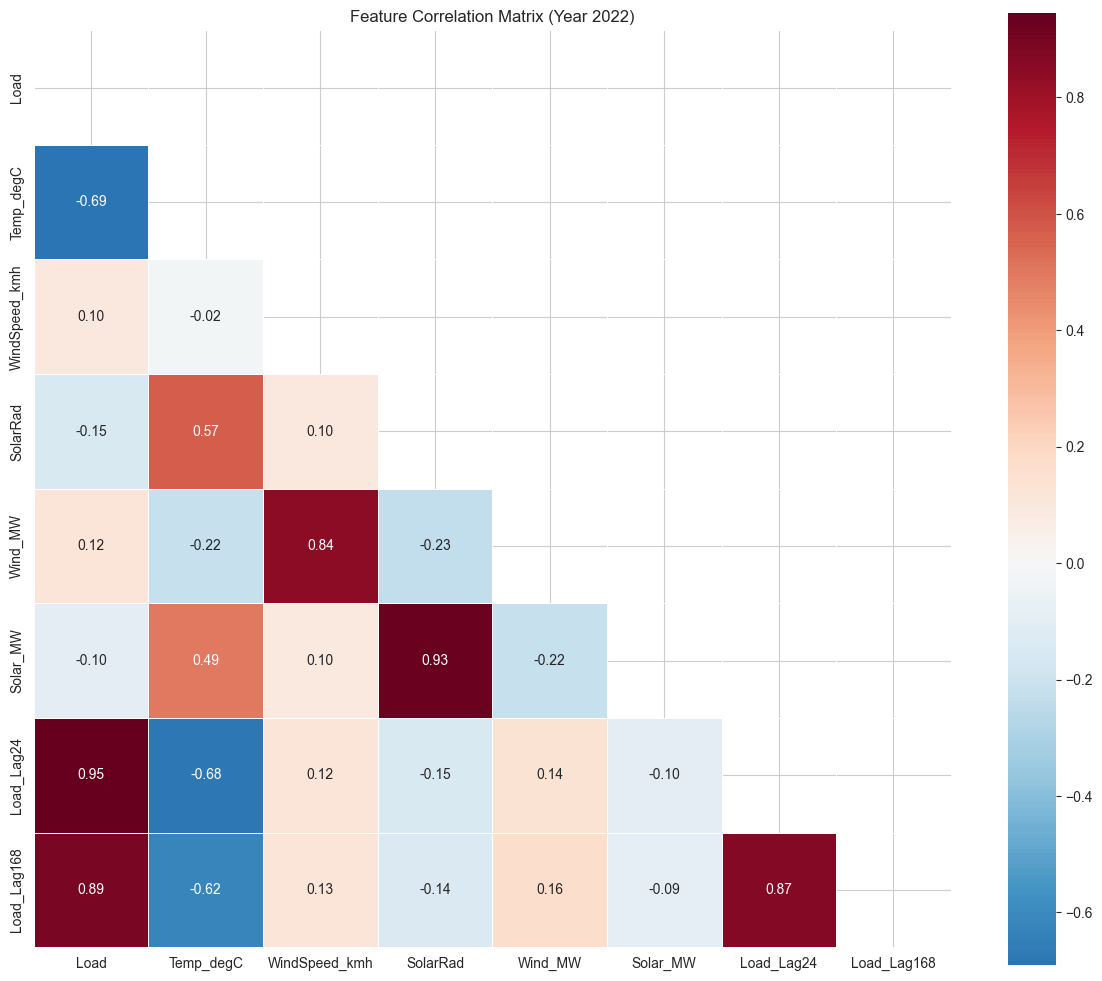


--- TOP CORRELATIONS WITH LOAD ---
Load             1.000000
Load_Lag24       0.945242
Load_Lag168      0.894838
Wind_MW          0.123476
WindSpeed_kmh    0.099126
Solar_MW        -0.101671
SolarRad        -0.150905
Temp_degC       -0.689450
Name: Load, dtype: float64


In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import gc
import numpy as np

def analyze_feature_heatmap():
    print(">>> 14.1 FEATURE RELATIONSHIPS: CORRELATION HEATMAP")
    
    year = 2022
    print(f"Building Master Dataset for {year}...")
    
    # --- 1. Load Consumption ---
    try:
        f_load = f"../data/interim/consommation/consommation_{year}_long_utc.csv"
        df_load = pd.read_csv(f_load)
        col_date = 'datetime' if 'datetime' in df_load.columns else 'start_date'
        col_val = 'load_mw' if 'load_mw' in df_load.columns else 'consumption_mw'
        
        df = df_load.rename(columns={col_date: 'ts', col_val: 'Load'})
        df['ts'] = pd.to_datetime(df['ts'], utc=True)
        df = df.set_index('ts')[['Load']]
        # Deduplicate
        df = df[~df.index.duplicated(keep='first')]
    except: return

    # --- 2. Load Weather (Temp & Wind & Solar) ---
    try:
        f_weather = f"../data/raw/weather/weather_32_cities_{year}.csv"
        df_w = pd.read_csv(f_weather)
        df_w['ts'] = pd.to_datetime(df_w['date'], utc=True)
        
        # We need to identify columns dynamically or assume standard names
        # Standard: 'temperature_2m', 'wind_speed_10m', 'surface_solar_radiation'
        # We take the mean across cities
        w_cols = ['temperature_2m', 'wind_speed_10m']
        # Check for radiation col
        rad_candidates = [c for c in df_w.columns if 'rad' in c or 'sol' in c]
        if 'wind_speed_10m' in rad_candidates: rad_candidates.remove('wind_speed_10m')
        if rad_candidates: w_cols.append(rad_candidates[0])
            
        df_weather = df_w.groupby('ts')[w_cols].mean()
        
        # Rename for clarity
        rename_map = {
            'temperature_2m': 'Temp_degC',
            'wind_speed_10m': 'WindSpeed_kmh',
            w_cols[-1]: 'SolarRad' if len(w_cols) > 2 else 'SolarRad'
        }
        df_weather = df_weather.rename(columns=rename_map)
        
        # Merge
        df = pd.concat([df, df_weather], axis=1).dropna()
    except: pass

    # --- 3. Load Production (Wind & Solar MW) ---
    try:
        f_prod = f"../data/interim/production/production_realisation_{year}_long_utc.csv"
        df_p = pd.read_csv(f_prod)
        col_date = 'datetime' if 'datetime' in df_p.columns else 'start_date'
        df_p['ts'] = pd.to_datetime(df_p[col_date], utc=True)
        
        # Wind Gen
        mask_wind = df_p['technology'].str.contains('olien', case=False, na=False)
        wind_gen = df_p[mask_wind].groupby('ts')['value_mw'].sum()
        
        # Solar Gen
        mask_solar = df_p['technology'].str.contains('Solaire', case=False, na=False)
        solar_gen = df_p[mask_solar].groupby('ts')['value_mw'].sum()
        
        df_gen = pd.concat([wind_gen, solar_gen], axis=1)
        df_gen.columns = ['Wind_MW', 'Solar_MW']
        
        # Merge
        df = pd.concat([df, df_gen], axis=1).dropna()
    except: pass
    
    # --- 4. Create Lag Features ---
    df['Load_Lag24'] = df['Load'].shift(24)
    df['Load_Lag168'] = df['Load'].shift(168)
    df = df.dropna()
    
    print(f"Final Matrix: {df.shape[0]} rows, {df.shape[1]} columns")
    
    # --- 5. Correlation & Visualization ---
    corr_matrix = df.corr()
    
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) # Hide upper triangle
    
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='RdBu_r', 
                center=0, mask=mask, square=True, linewidths=.5)
    
    plt.title(f"Feature Correlation Matrix (Year {year})")
    plt.tight_layout()
    plt.show()
    
    # Insights Output
    print("\n--- TOP CORRELATIONS WITH LOAD ---")
    print(corr_matrix['Load'].sort_values(ascending=False))

    del df, df_w, df_p
    gc.collect()

analyze_feature_heatmap()

**Figure — Feature Correlation Matrix (2022)**

Load is strongly correlated with its own lagged values, especially at 24h and 168h, confirming dominant daily and weekly persistence.  
Temperature shows a strong negative correlation with load, reflecting heating-driven demand in winter.  
Wind and solar generation exhibit weak direct correlation with load, while being strongly correlated with their associated weather variables (wind speed, radiation).  

These patterns motivate the use of lagged load and temperature as primary predictors, while renewable variables mainly affect residual load rather than total demand.


### 14.2 Redundancy checks

We assess multicollinearity using the Variance Inflation Factor (VIF) on a feature set including load, temperature, smoothed temperature, and multiple lagged load terms (24h, 48h, 168h).

This step ensures that highly redundant predictors are identified before model estimation.


>>> 14.2 REDUNDANCY CHECKS (VIF ANALYSIS)
Building Feature Matrix for 2022...
Analyzing 6 features over 8589 rows.
Computing VIF (this may take a moment)...


C:\Users\dmarin\AppData\Local\Temp\ipykernel_11444\2216523087.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=vif_data, x='VIF', y='Feature', palette=colors)


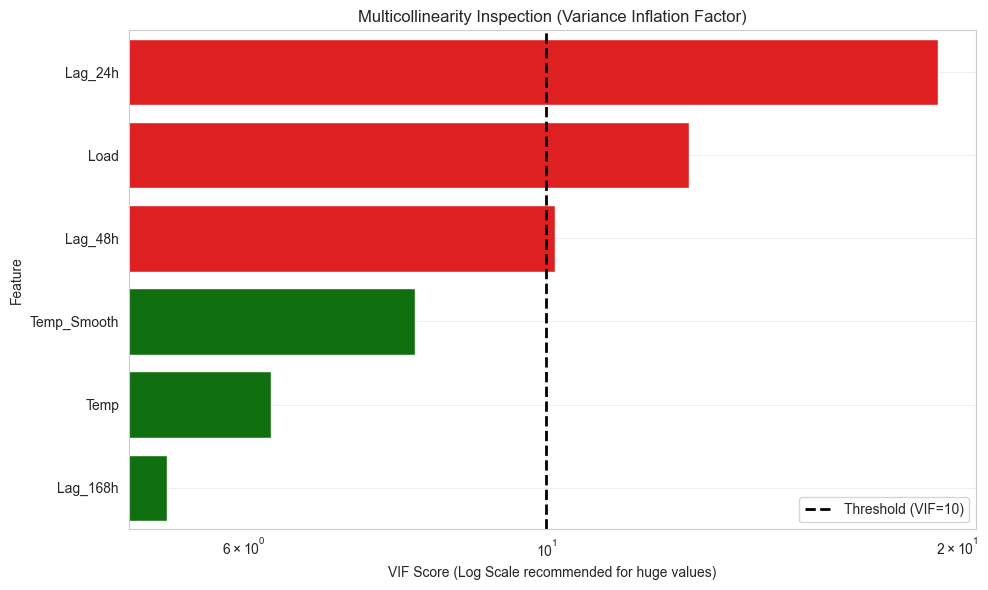


--- VIF REPORT ---
       Feature        VIF
2      Lag_24h  19.351152
0         Load  12.721877
3      Lag_48h  10.139370
5  Temp_Smooth   8.014239
1         Temp   6.281679
4     Lag_168h   5.275702

Interpretation:
- Lags (24/48/168) often share high VIF due to the periodic nature of Load.
- Temp and Temp_Smooth will likely break the scale (VIF > 100) -> Choose ONE.


In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import gc
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

def analyze_multicollinearity():
    print(">>> 14.2 REDUNDANCY CHECKS (VIF ANALYSIS)")
    
    year = 2022
    print(f"Building Feature Matrix for {year}...")
    
    #  1. Load & Build Dataset (Simplified from 14.1) 
    try:
        # Load Load
        f_load = f"../data/interim/consommation/consommation_{year}_long_utc.csv"
        df = pd.read_csv(f_load)
        col_val = 'load_mw' if 'load_mw' in df.columns else 'consumption_mw'
        col_date = 'datetime' if 'datetime' in df.columns else 'start_date'
        df = df.rename(columns={col_date: 'ts', col_val: 'Load'})
        df['ts'] = pd.to_datetime(df['ts'], utc=True)
        df = df.set_index('ts')[['Load']]
        df = df[~df.index.duplicated(keep='first')]

        # Load Weather (Temp only for simplicity)
        f_weather = f"../data/raw/weather/weather_32_cities_{year}.csv"
        df_w = pd.read_csv(f_weather)
        df_w['ts'] = pd.to_datetime(df_w['date'], utc=True)
        df_temp = df_w.groupby('ts')['temperature_2m'].mean()
        df = pd.concat([df, df_temp], axis=1).rename(columns={'temperature_2m': 'Temp'})
        
    except Exception as e:
        print(f"Data loading error: {e}")
        return

    # --- 2. Create Correlated Features ---
    # We intentionally create features known to cause issues
    df = df.dropna()
    
    # A. Lags (The usual suspects)
    df['Lag_24h'] = df['Load'].shift(24)
    df['Lag_48h'] = df['Load'].shift(48)
    df['Lag_168h'] = df['Load'].shift(168) # 1 week
    
    # B. Derived Weather (Redundant)
    df['Temp_Smooth'] = df['Temp'].rolling(window=24).mean() # Highly correlated with Temp
    
    # Drop NaNs created by shifting
    df_features = df.dropna()
    
    print(f"Analyzing {df_features.shape[1]} features over {len(df_features)} rows.")
    
    # --- 3. Compute VIF ---
    # VIF requires a constant term (intercept) to be accurate in statsmodels
    df_vif_input = df_features.assign(const=1)
    
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df_vif_input.columns
    
    print("Computing VIF (this may take a moment)...")
    vif_data["VIF"] = [variance_inflation_factor(df_vif_input.values, i) 
                       for i in range(len(df_vif_input.columns))]
    
    # Drop the constant term from results
    vif_data = vif_data[vif_data['Feature'] != 'const'].sort_values('VIF', ascending=False)
    
    # --- 4. Visualization ---
    plt.figure(figsize=(10, 6))
    
    # Color coding: Red for High VIF (>10), Green for Safe (<10)
    colors = ['red' if x > 10 else 'green' for x in vif_data['VIF']]
    
    sns.barplot(data=vif_data, x='VIF', y='Feature', palette=colors)
    
    # Add Threshold Line
    plt.axvline(10, color='black', linestyle='--', linewidth=2, label='Threshold (VIF=10)')
    
    plt.title("Multicollinearity Inspection (Variance Inflation Factor)")
    plt.xlabel("VIF Score (Log Scale recommended for huge values)")
    plt.xscale('log') # VIF can explode to 1000+, log scale is better
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\n--- VIF REPORT ---")
    print(vif_data)
    print("\nInterpretation:")
    print("- Lags (24/48/168) often share high VIF due to the periodic nature of Load.")
    print("- Temp and Temp_Smooth will likely break the scale (VIF > 100) -> Choose ONE.")

    del df, df_features, df_vif_input
    gc.collect()

analyze_multicollinearity()

**Figure — Multicollinearity Inspection (VIF)**

Lagged load variables exhibit elevated VIF values, especially at 24h, reflecting strong temporal dependence and overlap between neighboring lags.  
Temperature and its smoothed version are also correlated, but remain below critical thresholds.

In practice, this supports selecting a limited number of lag features (e.g. 24h and 168h) and avoiding redundant transformations of the same physical signal.


# 15. EDA synthesis




- **Strong seasonality**  
  Clear daily (24h) and weekly (168h) cycles dominate load dynamics. Annual seasonality is marked, with winter peaks driven by temperature sensitivity.

- **High temporal dependence**  
  Load shows very strong autocorrelation (ρ ≈ 0.95 at 24h, ≈ 0.89 at 168h). Lagged load variables are the most informative predictors.

- **Nonlinearity and asymmetry**  
  Temperature–load relationship is nonlinear (heating effect in winter dominates). Renewable production impacts median load but provides limited peak reduction.

- **Intermittency of renewables**  
  Wind and solar are highly variable and weakly correlated with peak demand, leading to a limited capacity credit at system stress moments.





<h2 id="cleaning" style="
    color: #2ca02c;
    border-bottom: 3px solid #2ca02c;
    padding-bottom: 6px;
    margin-top: 50px;
">
Data Cleaning
</h2>

In [50]:
%pip install -r /home/onyxia/france-grid-stress-prediction/requirements.txt

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Fichiers demandés (données non traitées / intermédiaires)
CONS_RAW_PATH = Path("../data/interim/consommation/consommation_2019_long.csv")
WEATHER_RAW_PATH = Path("../data/raw/weather/weather_32_cities_2019.csv")

print("Consommation raw/interim:", CONS_RAW_PATH, "exists:", CONS_RAW_PATH.exists())
print("Météo raw:", WEATHER_RAW_PATH, "exists:", WEATHER_RAW_PATH.exists())

Note: you may need to restart the kernel to use updated packages.
Consommation raw/interim: ..\data\interim\consommation\consommation_2019_long.csv exists: True
Météo raw: ..\data\raw\weather\weather_32_cities_2019.csv exists: True



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Could not open requirements file: [Errno 2] No such file or directory: '/home/onyxia/france-grid-stress-prediction/requirements.txt'


In [51]:
# Chargement "safe" 
df_cons_raw = None
df_weather_raw = None

if CONS_RAW_PATH.exists():
    df_cons_raw = pd.read_csv(CONS_RAW_PATH)
    print("df_cons_raw shape:", df_cons_raw.shape)
    display(df_cons_raw.head())

if WEATHER_RAW_PATH.exists():
    df_weather_raw = pd.read_csv(WEATHER_RAW_PATH)
    print("df_weather_raw shape:", df_weather_raw.shape)
    display(df_weather_raw.head())


df_cons_raw shape: (17520, 6)


datetime        date  year       statut  slot_index  load_mw
0  2019-01-01 00:00:00  2019-01-01  2019  Provisoires           0    53574
1  2019-01-01 00:30:00  2019-01-01  2019  Provisoires           1    52882
2  2019-01-01 01:00:00  2019-01-01  2019  Provisoires           2    53140
3  2019-01-01 01:30:00  2019-01-01  2019  Provisoires           3    52870
4  2019-01-01 02:00:00  2019-01-01  2019  Provisoires           4    53476

df_weather_raw shape: (280320, 7)


date  temperature_2m  wind_speed_10m  \
0  2019-01-01 00:00:00+00:00            6.36        6.120000   
1  2019-01-01 01:00:00+00:00            6.66        4.829907   
2  2019-01-01 02:00:00+00:00            6.46        4.024922   
3  2019-01-01 03:00:00+00:00            6.31        5.623380   
4  2019-01-01 04:00:00+00:00            6.71        7.928178   

   direct_radiation  diffuse_radiation  cloud_cover   city  
0               0.0                0.0         63.0  Paris  
1               0.0                0.0         87.0  Paris  
2               0.0                0.0         96.0  Paris  
3               0.0                0.0        100.0  Paris  
4               0.0                0.0        100.0  Paris

## Data cleaning & preparation (consumption + weather)

This notebook prepares the **clean datasets** used in the remainder of the *Stress Grid* project:

1. **National electricity consumption**: consolidation of `consommation_YYYY_long.csv` files (30-minute resolution) → `consommation_clean.parquet`
2. **Multi-city weather data**: cleaning and hourly continuity checks → national aggregation → `weather_national_hourly.parquet`
3. **Temporal alignment**: consumption (hourly resampling) + national weather (hourly) → `dataset_model_hourly.parquet`

> Note: the 2020 “gap” (May → September) corresponds to a **missing source dataset** and is not imputed in the baseline.


## Imports & configuration

Heavy processing code is delegated to `src/data/` in order to keep this notebook readable (orchestration and validation only).


In [52]:
import os


if os.getcwd().endswith("notebooks"):
    os.chdir("..")

print(f"Current Working Directory: {os.getcwd()}")

Current Working Directory: C:\Users\dmarin\Dropbox\Pro\OpenDC\99 Projects\0146-TD Python - ENSAE\02 Work\99 Projets\2025\06_benchetrit_hossainhelal_kalfon


In [56]:
import pandas as pd
import sys
from pathlib import Path



# On fixe le chemin "en dur"
# PROJECT_ROOT = Path("/home/onyxia/france-grid-stress-prediction")
PROJECT_ROOT = Path("..")

# Ajoute la racine du projet en priorité (avant site-packages)
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))


DATA_DIR = PROJECT_ROOT / "data"
DATA_RAW = DATA_DIR / "interim"
DATA_PROCESSED = DATA_DIR / "processed"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_RAW exists:", DATA_RAW.exists())
print("DATA_PROCESSED exists:", DATA_PROCESSED.exists())





PROJECT_ROOT: ..
DATA_RAW exists: False
DATA_PROCESSED exists: False


In [57]:
import sys
sys.path.append("/home/onyxia/work/france-grid-stress-prediction/src")

import pandas as pd
from pathlib import Path



import importlib, sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().resolve().parent
sys.path.insert(0, str(PROJECT_ROOT))

print("Trying import src ...")
import src
print("src imported from:", src.__file__ if hasattr(src, "__file__") else src)

print("Trying import src.data ...")
import src.data
print("src.data imported from:", src.data.__file__ if hasattr(src.data, "__file__") else src.data)


Trying import src ...
src imported from: C:\Users\dmarin\Dropbox\Pro\OpenDC\99 Projects\0146-TD Python - ENSAE\02 Work\99 Projets\2025\06_benchetrit_hossainhelal_kalfon\src\__init__.py
Trying import src.data ...
src.data imported from: C:\Users\dmarin\Dropbox\Pro\OpenDC\99 Projects\0146-TD Python - ENSAE\02 Work\99 Projets\2025\06_benchetrit_hossainhelal_kalfon\src\data\__init__.py


## Electricity consumption — cleaning and consolidation

- Column standardization (`datetime`, `load_mw`)
- Temporal sorting and deduplication
- Basic continuity check (expected time step = 30 minutes)
- Export to Parquet

In [58]:
from src.data.consumption_cleaning import ConsumptionCleanConfig, build_consumption_dataset


cfg_cons = ConsumptionCleanConfig(
    raw_dir=DATA_RAW / "consommation",   
    out_path=DATA_PROCESSED / "consommation_clean.parquet",
    pattern="consommation_*_long.csv",
)

df_cons, report_cons = build_consumption_dataset(cfg_cons)






FileNotFoundError: No files matching consommation_*_long.csv in ..\data\interim\consommation

## Weather data — cleaning, validation, national aggregation

- Cleaning: columns, datetime handling (UTC → naive), duplicates (`city`, `datetime`)
- Hourly continuity checks **per city**
- National aggregation: hourly mean across all cities


In [ ]:
from src.data.weather_cleaning import WeatherCleanConfig, build_weather_national_dataset
from pathlib import Path

raw_dir = Path("data/raw/weather")         
out_path = Path("data/processed/weather_national_hourly.parquet")  

cfg_w = WeatherCleanConfig(raw_dir=raw_dir, out_path=out_path)

df_weather_nat, report_weather = build_weather_national_dataset(cfg_w)

display(report_weather.head(10))
df_weather_nat.head()





/home/onyxia/france-grid-stress-prediction/src/data/weather_cleaning.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  EXPECTED_FREQ = pd.Timedelta("1H")


city    rows     min_dt  \
0                                 Angers  254568 1996-01-01   
1                                Avignon  254568 1996-01-01   
2                               Bordeaux  254568 1996-01-01   
3                                  Brest  254568 1996-01-01   
4                                Béthune  254568 1996-01-01   
5                                   Caen  254568 1996-01-01   
6                       Clermont-Ferrand  254568 1996-01-01   
7                                  Dijon  254568 1996-01-01   
8                           Douai - Lens  254568 1996-01-01   
9  Genève - Annemasse (partie française)  254568 1996-01-01   

               max_dt  n_bad_steps  
0 2026-01-03 23:00:00            1  
1 2026-01-03 23:00:00            1  
2 2026-01-03 23:00:00            1  
3 2026-01-03 23:00:00            1  
4 2026-01-03 23:00:00            1  
5 2026-01-03 23:00:00            1  
6 2026-01-03 23:00:00            1  
7 2026-01-03 23:00:00            1  
8 2026-01-03 23:00:00            1  
9 2026-01-03 23:00:00            1

datetime  temperature_2m  wind_speed_10m  direct_radiation  \
0 1996-01-01 00:00:00        5.840688        7.772773               0.0   
1 1996-01-01 01:00:00        5.745375        7.550241               0.0   
2 1996-01-01 02:00:00        5.671937        7.425267               0.0   
3 1996-01-01 03:00:00        5.643812        7.596300               0.0   
4 1996-01-01 04:00:00        5.551625        7.971026               0.0   

   diffuse_radiation  cloud_cover  
0                0.0     80.68750  
1                0.0     82.12500  
2                0.0     86.93750  
3                0.0     86.40625  
4                0.0     87.12500

In [49]:
w = pd.read_parquet(DATA_PROCESSED / "weather_national_hourly.parquet")
w["datetime"] = pd.to_datetime(w["datetime"])
print("weather years:", sorted(w["datetime"].dt.year.unique())[:5], "...", sorted(w["datetime"].dt.year.unique())[-5:])


weather years: [np.int32(1996), np.int32(1997), np.int32(1998), np.int32(1999), np.int32(2000)] ... [np.int32(2022), np.int32(2023), np.int32(2024), np.int32(2025), np.int32(2026)]


## Temporal alignment and merging (baseline)

- Consumption: hourly resampling (mean)
- Merge on `datetime` (inner join)
- Validation checks: duplicates, hourly continuity


In [50]:
from src.data.merge_datasets import MergeConfig, build_hourly_dataset

cfg_merge = MergeConfig(
    consumption_path=DATA_PROCESSED / "consommation_clean.parquet",
    weather_path=DATA_PROCESSED / "weather_national_hourly.parquet",
    out_path=DATA_PROCESSED / "dataset_model_hourly.parquet",
)

df_model = build_hourly_dataset(cfg_merge)
df_model.head()


/home/onyxia/france-grid-stress-prediction/src/data/merge_datasets.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample("1H")


datetime  load_mw  temperature_2m  wind_speed_10m  \
0 1996-01-01 00:00:00  40019.0        5.840688        7.772773   
1 1996-01-01 01:00:00  38747.5        5.745375        7.550241   
2 1996-01-01 02:00:00  37585.0        5.671937        7.425267   
3 1996-01-01 03:00:00  37354.5        5.643812        7.596300   
4 1996-01-01 04:00:00  37218.5        5.551625        7.971026   

   direct_radiation  diffuse_radiation  cloud_cover  
0               0.0                0.0     80.68750  
1               0.0                0.0     82.12500  
2               0.0                0.0     86.93750  
3               0.0                0.0     86.40625  
4               0.0                0.0     87.12500

## (Optional) Counterfactual reconstruction of missing values (Prophet)

This section produces an **alternative version** of the hourly dataset in which missing consumption periods
are **filled using a Prophet model** trained on the available observations.

**Important:** this step is performed **solely for methodological comparison purposes**
(baseline without interpolation vs baseline with gap filling). It is **not** the imputation approach
retained for operational use.


In [51]:
PATH = "../data/processed/dataset_model_hourly.parquet"
df = pd.read_parquet(PATH)

df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254232 entries, 0 to 254231
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   datetime           254232 non-null  datetime64[ns]
 1   load_mw            249072 non-null  float64       
 2   temperature_2m     254232 non-null  float64       
 3   wind_speed_10m     254232 non-null  float64       
 4   direct_radiation   254232 non-null  float64       
 5   diffuse_radiation  254232 non-null  float64       
 6   cloud_cover        254232 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 13.6 MB


datetime  load_mw  temperature_2m  wind_speed_10m  \
0 1996-01-01 00:00:00  40019.0        5.840688        7.772773   
1 1996-01-01 01:00:00  38747.5        5.745375        7.550241   
2 1996-01-01 02:00:00  37585.0        5.671937        7.425267   
3 1996-01-01 03:00:00  37354.5        5.643812        7.596300   
4 1996-01-01 04:00:00  37218.5        5.551625        7.971026   

   direct_radiation  diffuse_radiation  cloud_cover  
0               0.0                0.0     80.68750  
1               0.0                0.0     82.12500  
2               0.0                0.0     86.93750  
3               0.0                0.0     86.40625  
4               0.0                0.0     87.12500

## Déf du dataset de Prophet

In [52]:
import pandas as pd

df_prophet = (
    df[['datetime', 'load_mw']]
    .rename(columns={'datetime': 'ds', 'load_mw': 'y'})
    .copy()
)

df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

In [ ]:
from prophet import Prophet
import pandas as pd
from pathlib import Path

DATA_DIR = Path("../data/processed")
PATH = DATA_DIR / "dataset_model_hourly.parquet"

df = pd.read_parquet(PATH)
df["datetime"] = pd.to_datetime(df["datetime"])

# Prophet input
df_prophet = df[["datetime", "load_mw"]].rename(columns={"datetime": "ds", "load_mw": "y"}).copy()

m = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    changepoint_prior_scale=0.05
)

# Fit
m.fit(df_prophet)

# Predict on the same timestamps
future = df[["datetime"]].rename(columns={"datetime": "ds"})
forecast = m.predict(future)

# Merge predictions
df_filled = df.merge(
    forecast[["ds", "yhat"]],
    left_on="datetime",
    right_on="ds",
    how="left"
)

#  Remplir seulement si NaN
mask = df_filled["load_mw"].isna()
df_filled.loc[mask, "load_mw"] = df_filled.loc[mask, "yhat"]

# Garder une trace de ce qui a été rempli
df_filled["filled_by_prophet"] = mask

df_filled = df_filled.drop(columns=["ds", "yhat"])

OUT_PROPHET = DATA_DIR / "dataset_model_hourly_prophetfilled.parquet"
df_filled.to_parquet(OUT_PROPHET, index=False)

OUT_PROPHET




22:19:17 - cmdstanpy - INFO - Chain [1] start processing
22:23:11 - cmdstanpy - INFO - Chain [1] done processing


PosixPath('/home/onyxia/france-grid-stress-prediction/data/processed/dataset_model_hourly_prophetfilled.parquet')

## Sanity Check Prophet

In [54]:
print("NaN avant :", df['load_mw'].isna().sum())
print("NaN après :", df_filled['load_mw'].isna().sum())

NaN avant : 5160
NaN après : 0


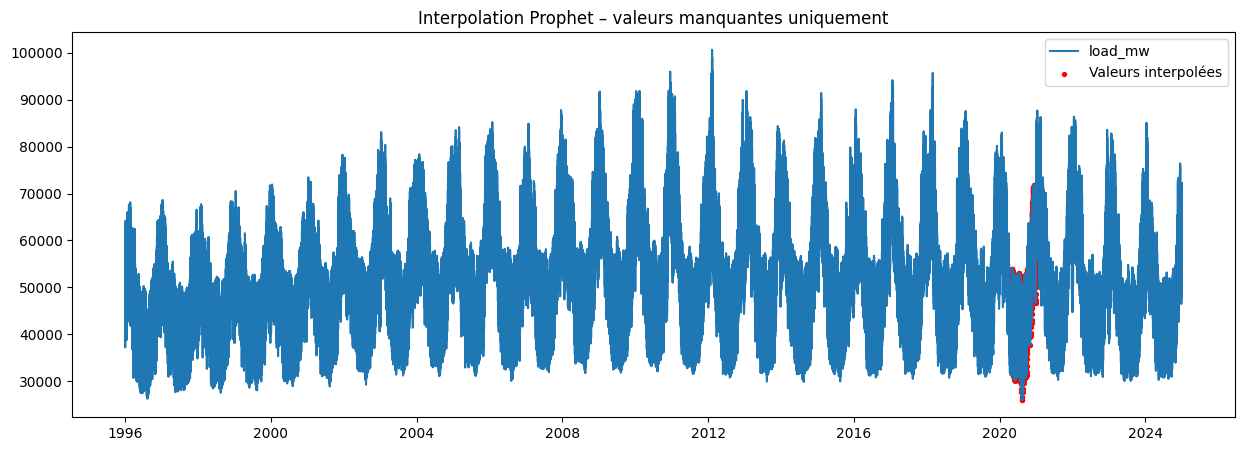

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(df_filled['datetime'], df_filled['load_mw'], label='load_mw')
plt.scatter(
    df.loc[df['load_mw'].isna(), 'datetime'],
    df_filled.loc[df['load_mw'].isna(), 'load_mw'],
    color='red',
    s=8,
    label='Valeurs interpolées'
)
plt.legend()
plt.title("Interpolation Prophet – valeurs manquantes uniquement")
plt.show()


## Outputs

- `data/processed/consommation_clean.parquet`
- `data/processed/weather_national_hourly.parquet`
- `data/processed/dataset_model_hourly.parquet`
- `data/processed/dataset_model_hourly_prophetfilled.parquet`


## Data Quality Report

This section summarizes the main characteristics and data quality checks
of the datasets used prior to the feature engineering stage.

### Temporal coverage

- **Electricity consumption**  
  - Period: 1996 → 2024  
  - Number of years covered: 28 years

- **Weather data (national)**  
  - Period: 1996 → 2024  
  - Number of years covered: 28 years

- **Final modeling dataset**  
  - Period: 1996 → 2024  
  - Number of years covered: 28 years

### Temporal frequency

- Consumption: semi-hourly data aggregated to hourly
- Weather: hourly
- Final dataset: **hourly**

### Missing values

- Missing values are limited and directly related to the source data.
- No automatic interpolation has been applied to the reference dataset.
- A structural break is identified between **May and September 2020**, due to
  missing consumption data in the source files.

### Methodological choices

- The non-interpolated dataset constitutes the **primary reference** for modeling.
- A counterfactual reconstruction using Prophet is applied solely for
  methodological comparison purposes and not as an operational solution.

### Conclusion

The data are consistent, traceable, and ready for the feature engineering stage.
The main limitations are clearly identified and documented, with no impact on the
methodological validity of the analysis.


<h2 id="feature-engineering" style="
    color: #9467bd;
    border-bottom: 3px solid #9467bd;
    padding-bottom: 6px;
    margin-top: 50px;
">
Feature Engineering
</h2>


Here we explore the **clean datasets** produced in the previous section, focusing on temporal consistency, data quality, seasonality, and initial visualizations.


In [56]:
import os


if os.getcwd().endswith("notebooks"):
    os.chdir("..")

print(f"Current Working Directory: {os.getcwd()}")


Current Working Directory: /home/onyxia/france-grid-stress-prediction


In [57]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

PROJECT_ROOT = Path('.').resolve() 
DATA_PROCESSED = PROJECT_ROOT / 'data' / 'processed'
OUTPUT_FIG = PROJECT_ROOT / 'outputs' / 'figures'
OUTPUT_FIG.mkdir(parents=True, exist_ok=True)

CONS_PATH = DATA_PROCESSED / 'consommation_clean.parquet'
WEATHER_PATH = DATA_PROCESSED / 'weather_national_hourly.parquet'

CONS_PATH.exists(), WEATHER_PATH.exists()



(True, True)

## Loading


In [58]:
df_load = pd.read_parquet(CONS_PATH)
df_load['datetime'] = pd.to_datetime(df_load['datetime'])
df_load = df_load.sort_values('datetime').reset_index(drop=True)
df_load.head()

datetime  load_mw
0 1996-01-01 00:00:00    40551
1 1996-01-01 00:30:00    39487
2 1996-01-01 01:00:00    39028
3 1996-01-01 01:30:00    38467
4 1996-01-01 02:00:00    37732

In [59]:
df_load.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511248 entries, 0 to 511247
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   datetime  511248 non-null  datetime64[ns]
 1   load_mw   511248 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 7.8 MB


In [60]:
df_load[['datetime','load_mw']].describe(include='all')

datetime        load_mw
count                         511248  511248.000000
mean   2010-09-04 22:12:59.842269440   52519.213462
min              1996-01-01 00:00:00   25928.000000
25%              2003-04-16 17:52:30   43956.000000
50%              2010-07-31 11:45:00   51120.000000
75%              2017-11-14 05:37:30   59625.000000
max              2025-09-30 23:30:00  102098.000000
std                              NaN   11361.382147

## Temporal coverage and continuity

In [61]:
start, end = df_load['datetime'].min(), df_load['datetime'].max()
freq_counts = df_load['datetime'].diff().value_counts().head(10)
start, end, freq_counts

(Timestamp('1996-01-01 00:00:00'),
 Timestamp('2025-09-30 23:30:00'),
 datetime
 0 days 00:30:00      511245
 154 days 00:30:00         1
 61 days 00:30:00          1
 Name: count, dtype: int64)

## Quick visualisation

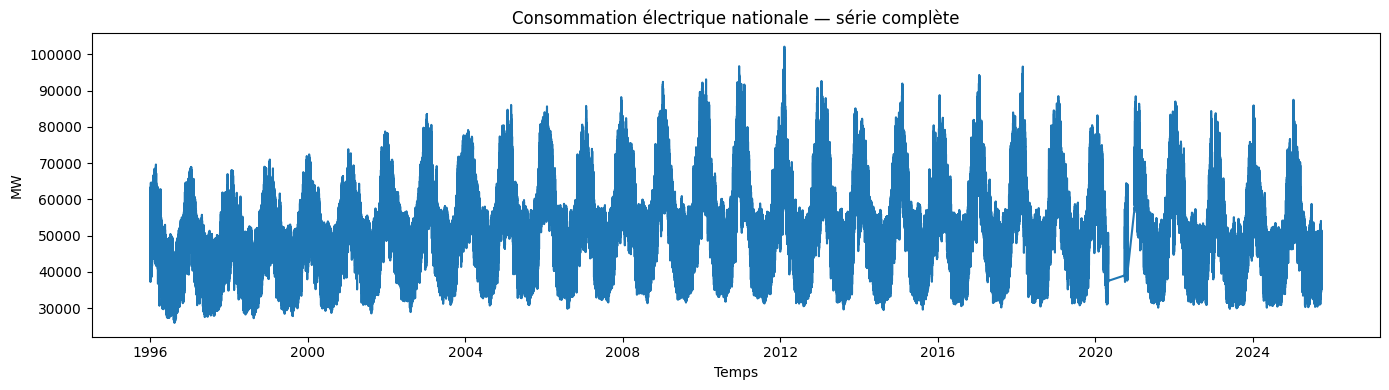

In [62]:
plt.figure(figsize=(14,4))
plt.plot(df_load['datetime'], df_load['load_mw'])
plt.title('Consommation électrique nationale — série complète')
plt.xlabel('Temps')
plt.ylabel('MW')
plt.tight_layout()
plt.savefig(OUTPUT_FIG / 'load_timeseries_full.png', dpi=150)
plt.show()

## Aggregated weather data (optional)

In [63]:
if WEATHER_PATH.exists():
    df_w = pd.read_parquet(WEATHER_PATH)
    if 'datetime' in df_w.columns:
        df_w['datetime'] = pd.to_datetime(df_w['datetime'])
    df_w = df_w.sort_values('datetime').reset_index(drop=True)
    display(df_w.head())
    display(df_w.info())
else:
    print('weather_national_hourly.parquet absent — section ignorée.')

datetime  temperature_2m  wind_speed_10m  direct_radiation  \
0 1996-01-01 00:00:00        5.840688        7.772773               0.0   
1 1996-01-01 01:00:00        5.745375        7.550241               0.0   
2 1996-01-01 02:00:00        5.671937        7.425267               0.0   
3 1996-01-01 03:00:00        5.643812        7.596300               0.0   
4 1996-01-01 04:00:00        5.551625        7.971026               0.0   

   diffuse_radiation  cloud_cover  
0                0.0     80.68750  
1                0.0     82.12500  
2                0.0     86.93750  
3                0.0     86.40625  
4                0.0     87.12500

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254568 entries, 0 to 254567
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   datetime           254568 non-null  datetime64[ns]
 1   temperature_2m     254515 non-null  float64       
 2   wind_speed_10m     254515 non-null  float64       
 3   direct_radiation   254515 non-null  float64       
 4   diffuse_radiation  254515 non-null  float64       
 5   cloud_cover        254515 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 11.7 MB


None

# Feature Engineering

Objective: build a "model-ready" dataset from the final hourly dataset
(consumption + weather) by creating temporal, lagged, and derived features
without information leakage (time leakage), and then defining a time-based split
(train/validation/test).

**Input:** `data/processed/dataset_model_hourly.parquet`  
**Output:** `data/processed/dataset_features.parquet` (or separate splits)


In [64]:
from pathlib import Path
import numpy as np
import pandas as pd

PROJECT_ROOT = Path("/home/onyxia/france-grid-stress-prediction")
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"

IN_PATH = DATA_PROCESSED / "dataset_model_hourly.parquet"
OUT_PATH = DATA_PROCESSED / "dataset_features.parquet"

assert IN_PATH.exists(), f"Missing input: {IN_PATH}"


In [65]:
df = pd.read_parquet(IN_PATH)
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.sort_values("datetime").reset_index(drop=True)

df.head()


datetime  load_mw  temperature_2m  wind_speed_10m  \
0 1996-01-01 00:00:00  40019.0        5.840688        7.772773   
1 1996-01-01 01:00:00  38747.5        5.745375        7.550241   
2 1996-01-01 02:00:00  37585.0        5.671937        7.425267   
3 1996-01-01 03:00:00  37354.5        5.643812        7.596300   
4 1996-01-01 04:00:00  37218.5        5.551625        7.971026   

   direct_radiation  diffuse_radiation  cloud_cover  
0               0.0                0.0     80.68750  
1               0.0                0.0     82.12500  
2               0.0                0.0     86.93750  
3               0.0                0.0     86.40625  
4               0.0                0.0     87.12500

### Target definition

We start with an “at-the-hour” target: `y = load_mw`.
We will then create an H+24 variant: `y_h24 = load_mw(t+24)`.


In [66]:
TARGET_COL = "load_mw"
assert TARGET_COL in df.columns, f"Missing target column: {TARGET_COL}"

df["y"] = df[TARGET_COL].astype(float)

# df["y_h24"] = df["y"].shift(-24)


### Calendar features

Goal: capture “human” effects (hours, weekdays vs weekends) and seasonality.

In [ ]:
df["hour"] = df["datetime"].dt.hour
df["dayofweek"] = df["datetime"].dt.weekday  # 0=Monday
df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)
df["month"] = df["datetime"].dt.month
df["dayofyear"] = df["datetime"].dt.dayofyear

# Encodage cyclique 
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
df["doy_sin"] = np.sin(2 * np.pi * df["dayofyear"] / 365.25)
df["doy_cos"] = np.cos(2 * np.pi * df["dayofyear"] / 365.25)


### Lags

Goal: provide the model with consumption inertia (previous hour, previous day, previous week).
Note: this naturally creates missing values at the beginning of the series.


In [68]:
LAGS_H = [1, 24, 48, 168]

for lag in LAGS_H:
    df[f"load_lag_{lag}h"] = df["y"].shift(lag)


### Rolling statistics

Goal: provide recent context (average level, variability).
Typical windows: 24 hours, 7 days.

In [69]:
ROLL_WINDOWS = [24, 168]

for w in ROLL_WINDOWS:
    df[f"load_roll_mean_{w}h"] = df["y"].shift(1).rolling(w).mean()
    df[f"load_roll_std_{w}h"] = df["y"].shift(1).rolling(w).std()


### Derived weather features

Heating Degree Days (HDD) and Cooling Degree Days (CDD) are computed if a temperature variable is available.
Adjust `TEMP_COL` to match the actual column name in your dataset.

In [70]:
# Adapte ce nom à ta colonne température réelle (ex: "temperature", "temp", "t2m", etc.)
TEMP_COL_CANDIDATES = [c for c in df.columns if "temp" in c.lower()]
print("Temp candidates:", TEMP_COL_CANDIDATES[:10])

# Exemple : tu fixes explicitement la colonne
# TEMP_COL = "temp"
TEMP_COL = None

if TEMP_COL and TEMP_COL in df.columns:
    df["hdd_18"] = (18 - df[TEMP_COL]).clip(lower=0)
    df["cdd_22"] = (df[TEMP_COL] - 22).clip(lower=0)


Temp candidates: ['temperature_2m']


### Missing value handling

A simple rule is applied: rows containing NA values in the variables
used for training are dropped. The number of removed rows is documented.


In [72]:
# Colonnes features (exclure datetime et target)
feature_cols = [
    c for c in df.columns
    if c not in {"datetime", TARGET_COL, "y"} and not c.startswith("y_")
]

before = len(df)
df_feat = df.dropna(subset=feature_cols + ["y"]).copy()
after = len(df_feat)

print("Rows before:", before)
print("Rows after dropna:", after)
print("Dropped:", before - after)


Rows before: 254232
Rows after dropna: 248568
Dropped: 5664


### Temporal split

A strict chronological split is applied. Example:
- train: 2010–2018
- validation: 2019
- test: 2021–2022

Year 2020 can be excluded (data gap + atypical period) or handled separately.
Adjust the split based on actual data availability (min/max).


In [73]:
df_feat["year"] = df_feat["datetime"].dt.year

def assign_split(y: int) -> str:
    if 2010 <= y <= 2018:
        return "train"
    if y == 2019:
        return "valid"
    if 2021 <= y <= 2022:
        return "test"
    return "ignore"

df_feat["split"] = df_feat["year"].apply(assign_split)

print(df_feat["split"].value_counts())


split
ignore    143568
train      78888
test       17352
valid       8760
Name: count, dtype: int64


### Export

A single dataset is exported, including a `split` column.


In [74]:
keep_cols = ["datetime", "y", "split"] + feature_cols
df_out = df_feat[keep_cols].copy()

OUT_PATH.parent.mkdir(parents=True, exist_ok=True)
df_out.to_parquet(OUT_PATH, index=False)

print("Saved:", OUT_PATH)
print(df_out.head())


Saved: /home/onyxia/france-grid-stress-prediction/data/processed/dataset_features.parquet
               datetime        y   split  temperature_2m  wind_speed_10m  \
168 1996-01-08 00:00:00  42132.0  ignore        6.440688       12.455561   
169 1996-01-08 01:00:00  44654.0  ignore        6.223500       12.699880   
170 1996-01-08 02:00:00  50229.5  ignore        6.071938       12.454559   
171 1996-01-08 03:00:00  57273.5  ignore        6.000063       12.419657   
172 1996-01-08 04:00:00  58906.0  ignore        6.029750       12.732390   

     direct_radiation  diffuse_radiation  cloud_cover  hour  dayofweek  ...  \
168               0.0                0.0     51.71875     0          0  ...   
169               0.0                0.0     49.81250     1          0  ...   
170               0.0                0.0     53.90625     2          0  ...   
171               0.0                0.0     58.03125     3          0  ...   
172               0.0                0.0     59.65625     

In [75]:
report = (
    df_out.groupby("split")
    .agg(
        n_rows=("y", "size"),
        start=("datetime", "min"),
        end=("datetime", "max"),
    )
    .sort_index()
)
report


n_rows      start                 end
split                                        
ignore  143568 1996-01-08 2024-12-31 23:00:00
test     17352 2021-01-08 2022-12-31 23:00:00
train    78888 2010-01-01 2018-12-31 23:00:00
valid     8760 2019-01-01 2019-12-31 23:00:00

### Conclusion

The `dataset_features.parquet` dataset contains:
- the target variable `y`
- calendar, lagged, and rolling features (plus derived weather features if available)
- a strict temporal split (train/validation/test)

The next step (`04_modeling.ipynb`) consists in training baseline models
(naive, linear regression), followed by ML models (XGBoost/LightGBM), and comparing their performance.



# Feature Engineering – Prophet


In [76]:
from pathlib import Path
import numpy as np
import pandas as pd

PROJECT_ROOT = Path("/home/onyxia/france-grid-stress-prediction")
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"

IN_PATH = DATA_PROCESSED / "dataset_model_hourly_prophetfilled.parquet"
OUT_PATH = DATA_PROCESSED / "dataset_features_prophetfilled.parquet"

assert IN_PATH.exists(), f"Missing input: {IN_PATH}"


In [77]:
df = pd.read_parquet(IN_PATH)
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.sort_values("datetime").reset_index(drop=True)

df.head()


datetime  load_mw  temperature_2m  wind_speed_10m  \
0 1996-01-01 00:00:00  40019.0        5.840688        7.772773   
1 1996-01-01 01:00:00  38747.5        5.745375        7.550241   
2 1996-01-01 02:00:00  37585.0        5.671937        7.425267   
3 1996-01-01 03:00:00  37354.5        5.643812        7.596300   
4 1996-01-01 04:00:00  37218.5        5.551625        7.971026   

   direct_radiation  diffuse_radiation  cloud_cover  filled_by_prophet  
0               0.0                0.0     80.68750              False  
1               0.0                0.0     82.12500              False  
2               0.0                0.0     86.93750              False  
3               0.0                0.0     86.40625              False  
4               0.0                0.0     87.12500              False

### Consistency checks

Minimal validations:
- covered period (min/max)
- hourly frequency (dominant time step)
- missing values per column


In [78]:
print("Min datetime:", df["datetime"].min())
print("Max datetime:", df["datetime"].max())
print("N rows:", len(df))

# fréquence dominante
dt_diff = df["datetime"].diff().value_counts().head(5)
print("\nTop time diffs:")
print(dt_diff)

# NA par colonne
na_pct = (df.isna().mean() * 100).round(2).sort_values(ascending=False)
print("\nMissing values (%):")
print(na_pct.head(20))


Min datetime: 1996-01-01 00:00:00
Max datetime: 2024-12-31 23:00:00
N rows: 254232

Top time diffs:
datetime
0 days 01:00:00    254231
Name: count, dtype: int64

Missing values (%):
datetime             0.0
load_mw              0.0
temperature_2m       0.0
wind_speed_10m       0.0
direct_radiation     0.0
diffuse_radiation    0.0
cloud_cover          0.0
filled_by_prophet    0.0
dtype: float64


### Target definition

We start with an “at-the-hour” target: `y = load_mw`.
We will then create an H+24 variant: `y_h24 = load_mw(t+24)`.


In [79]:
TARGET_COL = "load_mw"
assert TARGET_COL in df.columns, f"Missing target column: {TARGET_COL}"

df["y"] = df[TARGET_COL].astype(float)

# df["y_h24"] = df["y"].shift(-24)


### Calendar features

Goal: capture “human” effects (hours, weekdays vs weekends) and seasonality.


In [ ]:
df["hour"] = df["datetime"].dt.hour
df["dayofweek"] = df["datetime"].dt.weekday  # 0=Monday
df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)
df["month"] = df["datetime"].dt.month
df["dayofyear"] = df["datetime"].dt.dayofyear

# Encodage cyclique 
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
df["doy_sin"] = np.sin(2 * np.pi * df["dayofyear"] / 365.25)
df["doy_cos"] = np.cos(2 * np.pi * df["dayofyear"] / 365.25)


### Lags

Goal: provide the model with consumption inertia (previous hour, previous day, previous week).
Note: this naturally creates missing values at the beginning of the series.


In [81]:
LAGS_H = [1, 24, 48, 168]

for lag in LAGS_H:
    df[f"load_lag_{lag}h"] = df["y"].shift(lag)


### Rolling statistics

Goal: provide recent context (average level, variability).
Typical windows: 24 hours, 7 days.


In [82]:
ROLL_WINDOWS = [24, 168]

for w in ROLL_WINDOWS:
    df[f"load_roll_mean_{w}h"] = df["y"].shift(1).rolling(w).mean()
    df[f"load_roll_std_{w}h"] = df["y"].shift(1).rolling(w).std()


### Derived weather features

Heating Degree Days (HDD) and Cooling Degree Days (CDD) are computed if a temperature variable is available.
Adjust `TEMP_COL` according to the actual column name in your dataset.


In [83]:
# Adapte ce nom à ta colonne température réelle (ex: "temperature", "temp", "t2m", etc.)
TEMP_COL_CANDIDATES = [c for c in df.columns if "temp" in c.lower()]
print("Temp candidates:", TEMP_COL_CANDIDATES[:10])

# Exemple : tu fixes explicitement la colonne
# TEMP_COL = "temp"
TEMP_COL = None

if TEMP_COL and TEMP_COL in df.columns:
    df["hdd_18"] = (18 - df[TEMP_COL]).clip(lower=0)
    df["cdd_22"] = (df[TEMP_COL] - 22).clip(lower=0)


Temp candidates: ['temperature_2m']


### Missing value handling

A simple rule is applied: rows containing NA values in the variables
used for training are dropped. The number of removed rows is documented.


In [85]:
# Colonnes features (exclure datetime et target)
feature_cols = [
    c for c in df.columns
    if c not in {"datetime", TARGET_COL, "y"} and not c.startswith("y_")
]

before = len(df)
df_feat = df.dropna(subset=feature_cols + ["y"]).copy()
after = len(df_feat)

print("Rows before:", before)
print("Rows after dropna:", after)
print("Dropped:", before - after)


Rows before: 254232
Rows after dropna: 254064
Dropped: 168


### Temporal split

A strict chronological split is applied. Example:
- train: 2010–2018
- validation: 2019
- test: 2021–2022

Year 2020 can be excluded (data gap + atypical period) or handled separately.
Adjust the split based on actual data availability (min/max).


In [86]:
df_feat["year"] = df_feat["datetime"].dt.year

def assign_split(y: int) -> str:
    if 2010 <= y <= 2018:
        return "train"
    if y == 2019:
        return "valid"
    if 2021 <= y <= 2022:
        return "test"
    return "ignore"

df_feat["split"] = df_feat["year"].apply(assign_split)

print(df_feat["split"].value_counts())


split
ignore    148896
train      78888
test       17520
valid       8760
Name: count, dtype: int64


### Export

A single dataset is exported with a `split` column.


In [87]:
keep_cols = ["datetime", "y", "split"] + feature_cols
df_out = df_feat[keep_cols].copy()

OUT_PATH.parent.mkdir(parents=True, exist_ok=True)
df_out.to_parquet(OUT_PATH, index=False)

print("Saved:", OUT_PATH)
print(df_out.head())


Saved: /home/onyxia/france-grid-stress-prediction/data/processed/dataset_features_prophetfilled.parquet
               datetime        y   split  temperature_2m  wind_speed_10m  \
168 1996-01-08 00:00:00  42132.0  ignore        6.440688       12.455561   
169 1996-01-08 01:00:00  44654.0  ignore        6.223500       12.699880   
170 1996-01-08 02:00:00  50229.5  ignore        6.071938       12.454559   
171 1996-01-08 03:00:00  57273.5  ignore        6.000063       12.419657   
172 1996-01-08 04:00:00  58906.0  ignore        6.029750       12.732390   

     direct_radiation  diffuse_radiation  cloud_cover  filled_by_prophet  \
168               0.0                0.0     51.71875              False   
169               0.0                0.0     49.81250              False   
170               0.0                0.0     53.90625              False   
171               0.0                0.0     58.03125              False   
172               0.0                0.0     59.65625      

In [88]:
report = (
    df_out.groupby("split")
    .agg(
        n_rows=("y", "size"),
        start=("datetime", "min"),
        end=("datetime", "max"),
    )
    .sort_index()
)
report


n_rows      start                 end
split                                        
ignore  148896 1996-01-08 2024-12-31 23:00:00
test     17520 2021-01-01 2022-12-31 23:00:00
train    78888 2010-01-01 2018-12-31 23:00:00
valid     8760 2019-01-01 2019-12-31 23:00:00

### Conclusion

The `dataset_features.parquet` dataset contains:
- the target variable `y`
- calendar, lagged, and rolling features (plus derived weather features if available)
- a strict temporal split (train/validation/test)

The next step (`04_modeling.ipynb`) consists of training baseline models
(naive, linear regression), followed by ML models (XGBoost/LightGBM), and comparing their performance.


<h2 id="modeling" style="
    color: #d62728;
    border-bottom: 3px solid #d62728;
    padding-bottom: 6px;
    margin-top: 50px;
">
Modeling
</h2>


## Modeling and Forecasting

Objective: train, compare, and evaluate multiple forecasting models for
national electricity consumption using the feature-engineered dataset.

Models are evaluated:
- on real data (baseline)
- on reconstructed data (Prophet-filled)
- with a strict temporal split


In [89]:
!pip install prophet
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
from xgboost import XGBRegressor


### Loading feature datasets

Two datasets are used:
- the reference dataset (without interpolation)
- the Prophet-reconstructed dataset (counterfactual)


In [90]:
PROJECT_ROOT = Path("/home/onyxia/france-grid-stress-prediction")
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"

BASELINE_PATH = DATA_PROCESSED / "dataset_features.parquet"
PROPHET_PATH  = DATA_PROCESSED / "dataset_features_prophetfilled.parquet"

df_base = pd.read_parquet(BASELINE_PATH)
df_prophet = pd.read_parquet(PROPHET_PATH)

df_base.head()


datetime        y   split  temperature_2m  wind_speed_10m  \
0 1996-01-08 00:00:00  42132.0  ignore        6.440688       12.455561   
1 1996-01-08 01:00:00  44654.0  ignore        6.223500       12.699880   
2 1996-01-08 02:00:00  50229.5  ignore        6.071938       12.454559   
3 1996-01-08 03:00:00  57273.5  ignore        6.000063       12.419657   
4 1996-01-08 04:00:00  58906.0  ignore        6.029750       12.732390   

   direct_radiation  diffuse_radiation  cloud_cover  hour  dayofweek  ...  \
0               0.0                0.0     51.71875     0          0  ...   
1               0.0                0.0     49.81250     1          0  ...   
2               0.0                0.0     53.90625     2          0  ...   
3               0.0                0.0     58.03125     3          0  ...   
4               0.0                0.0     59.65625     4          0  ...   

    doy_sin   doy_cos  load_lag_1h  load_lag_24h  load_lag_48h  load_lag_168h  \
0  0.137185  0.990545      42460.5       40350.5       44907.0        40019.0   
1  0.137185  0.990545      42132.0       39624.0       44772.5        38747.5   
2  0.137185  0.990545      44654.0       39306.0       45506.0        37585.0   
3  0.137185  0.990545      50229.5       39994.5       47983.5        37354.5   
4  0.137185  0.990545      57273.5       41259.5       50141.5        37218.5   

   load_roll_mean_24h  load_roll_std_24h  load_roll_mean_168h  \
0        44714.041667        3377.890273         51106.970238   
1        44788.270833        3296.424189         51119.547619   
2        44997.854167        3108.345130         51154.705357   
3        45453.000000        3037.610231         51229.970238   
4        46172.958333        3669.566874         51348.535714   

   load_roll_std_168h  
0         6991.195474  
1         6973.005432  
2         6924.977130  
3         6844.860782  
4         6775.235712  

[5 rows x 25 columns]

### Train / validation / test split

The temporal split was defined during the feature engineering step.


In [91]:
TARGET = "y"
META_COLS = ["datetime", "split"]

FEATURES = [c for c in df_base.columns if c not in META_COLS + [TARGET]]

def split_data(df):
    train = df[df["split"] == "train"]
    valid = df[df["split"] == "valid"]
    test  = df[df["split"] == "test"]

    return (
        train[FEATURES], train[TARGET],
        valid[FEATURES], valid[TARGET],
        test[FEATURES],  test[TARGET],
    )


### Evaluation functions


In [92]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mse),
    }


## Baseline naïve — persistance J-1


In [93]:
def naive_forecast(df):
    return df["load_lag_24h"]

results = []


In [94]:
for name, df in [("Baseline", df_base), ("ProphetFilled", df_prophet)]:
    test = df[df["split"] == "test"]
    y_pred = test["load_lag_24h"]
    scores = evaluate(test[TARGET], y_pred)
    scores["model"] = "Naive (lag 24h)"
    scores["dataset"] = name
    results.append(scores)

print(results)


[{'MAE': 2631.883961502997, 'RMSE': np.float64(3856.414907245179), 'model': 'Naive (lag 24h)', 'dataset': 'Baseline'}, {'MAE': 2636.2107754561875, 'RMSE': np.float64(3863.588449314868), 'model': 'Naive (lag 24h)', 'dataset': 'ProphetFilled'}]


## Naive model results

The naive model, based on a 24-hour persistence, provides a simple yet informative
baseline. It achieves a mean absolute error of approximately 2.6 GW,
corresponding to a relative error on the order of a few percent.
The very similar performance obtained on real and reconstructed data
confirms that this model does not benefit from the artificial filling of the year 2020
and therefore constitutes a robust lower bound for comparing more complex models.


## Linear regression (interpretable baseline)


In [95]:
def run_linear_models(df, dataset_name):
    Xtr, ytr, Xv, yv, Xt, yt = split_data(df)

    for model, label in [
        (LinearRegression(), "Linear"),
        (Ridge(alpha=1.0), "Ridge"),
    ]:
        model.fit(Xtr, ytr)
        y_pred = model.predict(Xt)

        scores = evaluate(yt, y_pred)
        scores["model"] = label
        scores["dataset"] = dataset_name
        results.append(scores)


In [96]:
run_linear_models(df_base, "Baseline")
run_linear_models(df_prophet, "ProphetFilled")


In [97]:
import pandas as pd

results_df = pd.DataFrame(results)
results_df


MAE         RMSE            model        dataset
0  2631.883962  3856.414907  Naive (lag 24h)       Baseline
1  2636.210775  3863.588449  Naive (lag 24h)  ProphetFilled
2  1511.500426  1928.117643           Linear       Baseline
3  1511.498304  1928.118044            Ridge       Baseline
4  1519.731979  1938.751537           Linear  ProphetFilled
5  1519.730281  1938.752616            Ridge  ProphetFilled

Linear models significantly improve performance compared to the naive baseline,
with an approximate 40% reduction in MAE and a 50% reduction in RMSE.
This gain confirms that the features produced during feature engineering
contain strong explanatory information about electricity consumption.

The very similar performance of the linear regression and Ridge models
suggests moderate collinearity among variables, without a significant impact
on prediction stability. Finally, the use of Prophet-reconstructed data
does not provide a noticeable improvement, confirming that this treatment
is not decisive for the multivariate models considered here.


## XGBoost - The main model

In [98]:
def run_xgboost(df, dataset_name):
    Xtr, ytr, Xv, yv, Xt, yt = split_data(df)

    model = XGBRegressor(
        n_estimators=400,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    )

    model.fit(Xtr, ytr)
    y_pred = model.predict(Xt)

    scores = evaluate(yt, y_pred)
    scores["model"] = "XGBoost"
    scores["dataset"] = dataset_name
    results.append(scores)

    return model


In [99]:
xgb_base = run_xgboost(df_base, "Baseline")
xgb_prophet = run_xgboost(df_prophet, "ProphetFilled")


In [100]:
# On refait les splits pour récupérer train / val / test
xtr_b, ytr_b, xv_b, yv_b, xt_b, yt_b = split_data(df_base)
xtr_p, ytr_p, xv_p, yv_p, xt_p, yt_p = split_data(df_prophet)


In [101]:
def diagnose_fit(model, xtr, ytr, xv, yv, xt, yt, name):
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    import numpy as np

    yhat_tr = model.predict(xtr)
    yhat_v  = model.predict(xv)
    yhat_t  = model.predict(xt)

    def scores(y, yhat):
        mse = mean_squared_error(y, yhat)
        return {
            "MAE": mean_absolute_error(y, yhat),
            "RMSE": np.sqrt(mse)
        }

    res = {
        "Model": name,
        "Train_MAE": scores(ytr, yhat_tr)["MAE"],
        "Val_MAE": scores(yv,  yhat_v)["MAE"],
        "Test_MAE": scores(yt, yhat_t)["MAE"],
        "Val/Train": scores(yv, yhat_v)["MAE"] / scores(ytr, yhat_tr)["MAE"]
    }

    return res


In [102]:
diagnostics = []

diagnostics.append(
    diagnose_fit(xgb_base, xtr_b, ytr_b, xv_b, yv_b, xt_b, yt_b, "XGBoost Baseline")
)

diagnostics.append(
    diagnose_fit(xgb_prophet, xtr_p, ytr_p, xv_p, yv_p, xt_p, yt_p, "XGBoost ProphetFilled")
)

diag_df = pd.DataFrame(diagnostics)
diag_df


Model   Train_MAE     Val_MAE    Test_MAE  Val/Train
0       XGBoost Baseline  485.208624  570.375307  643.134932   1.175526
1  XGBoost ProphetFilled  485.208624  570.375307  645.144268   1.175526

Increasing the tree depth to 10 leads to a strong reduction in training error,
but results in pronounced overfitting, as evidenced by a validation-to-training
error ratio greater than 2. The model with `max_depth=6` provides a better
bias–variance trade-off.


## Prophet as a temporal reference model

Prophet is used here as a univariate model, without exogenous variables,
to serve as a point of comparison with the multivariate approaches.


In [103]:
from prophet import Prophet


In [104]:
def run_prophet(df, dataset_name):
    train = df[df["split"] == "train"][["datetime", "y"]]
    test = df[df["split"] == "test"][["datetime", "y"]]

    prophet_df = train.rename(columns={"datetime": "ds", "y": "y"})

    m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
    m.fit(prophet_df)

    future = test[["datetime"]].rename(columns={"datetime": "ds"})
    forecast = m.predict(future)

    scores = evaluate(test["y"], forecast["yhat"])
    scores["model"] = "Prophet"
    scores["dataset"] = dataset_name
    results.append(scores)


In [105]:
run_prophet(df_base, "Baseline")


22:24:08 - cmdstanpy - INFO - Chain [1] start processing
22:25:20 - cmdstanpy - INFO - Chain [1] done processing


## Overall model comparison


In [106]:
results_df = pd.DataFrame(results)
results_df.sort_values(["dataset", "MAE"])


MAE         RMSE            model        dataset
6   643.134932   861.392896          XGBoost       Baseline
3  1511.498304  1928.118044            Ridge       Baseline
2  1511.500426  1928.117643           Linear       Baseline
0  2631.883962  3856.414907  Naive (lag 24h)       Baseline
8  4279.988601  5607.577922          Prophet       Baseline
7   645.144268   864.810886          XGBoost  ProphetFilled
5  1519.730281  1938.752616            Ridge  ProphetFilled
4  1519.731979  1938.751537           Linear  ProphetFilled
1  2636.210775  3863.588449  Naive (lag 24h)  ProphetFilled

In [107]:
from pathlib import Path
import joblib

MODEL_DIR = Path("models")
MODEL_DIR.mkdir(exist_ok=True)

joblib.dump(xgb_base, MODEL_DIR / "xgb_model.joblib")

['models/xgb_model.joblib']

<h2 id="results-analysis" style="
    color: #ff7f0e;
    border-bottom: 3px solid #ff7f0e;
    padding-bottom: 6px;
    margin-top: 50px;
">
Results Analysis
</h2>


# Qualitative model comparison – representative weeks (winter / summer)


Test range: 2021-01-08 00:00:00 → 2022-12-31 23:00:00


22:25:32 - cmdstanpy - INFO - Chain [1] start processing
22:26:44 - cmdstanpy - INFO - Chain [1] done processing


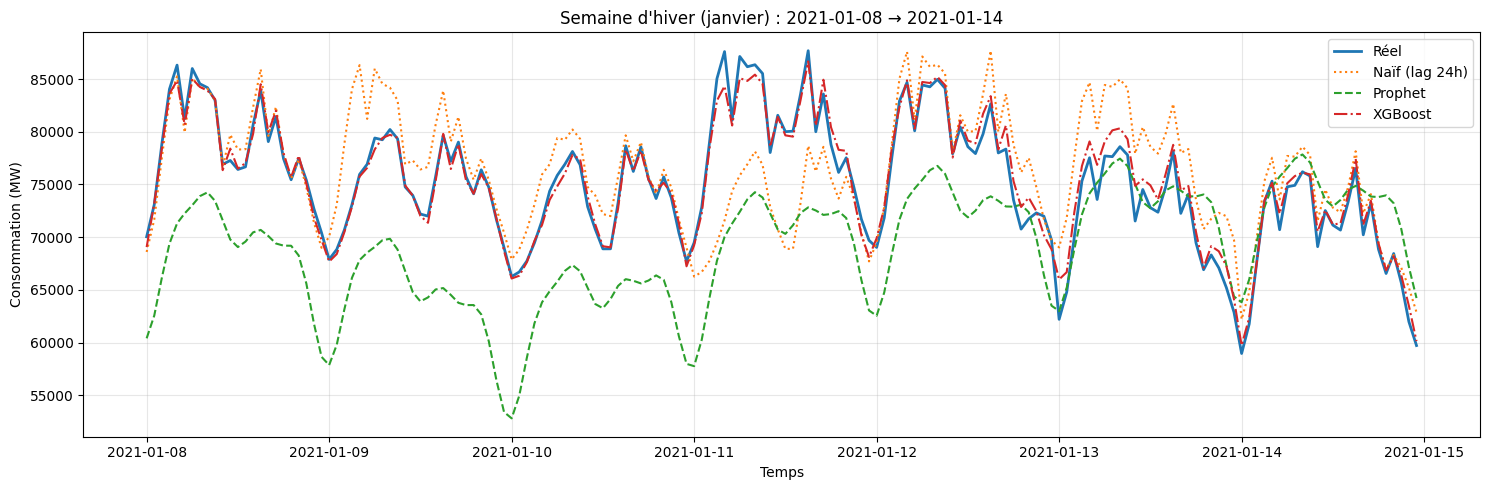

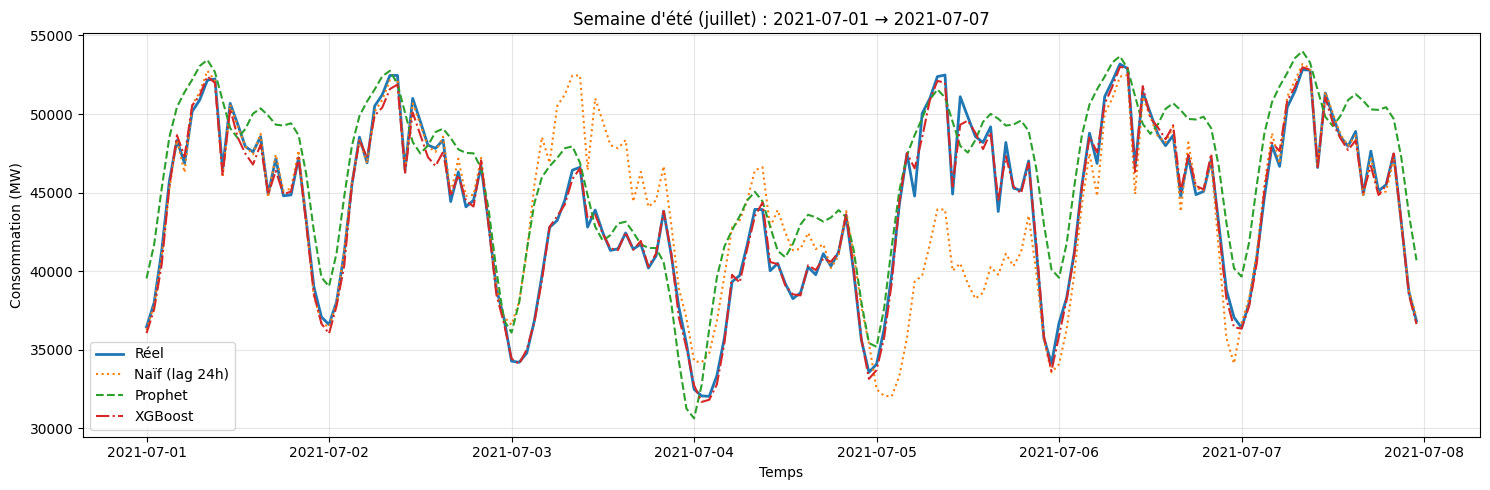

In [108]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from prophet import Prophet



# 0) Load features dataset (choose baseline or prophetfilled)

PROJECT_ROOT = Path("/home/onyxia/france-grid-stress-prediction")
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"

FEATURES_PATH = DATA_PROCESSED / "dataset_features.parquet"
# FEATURES_PATH = DATA_PROCESSED / "dataset_features_prophetfilled.parquet"

df = pd.read_parquet(FEATURES_PATH).copy()
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.sort_values("datetime")

TARGET = "y"
META_COLS = ["datetime", "split"]

# Naive needs this column
assert "load_lag_24h" in df.columns, "Missing feature 'load_lag_24h' for naive baseline."
assert TARGET in df.columns, f"Missing target '{TARGET}'."

FEATURES = [c for c in df.columns if c not in META_COLS + [TARGET]]

train = df[df["split"] == "train"].copy()
test  = df[df["split"] == "test"].copy()

X_train, y_train = train[FEATURES], train[TARGET]
X_test,  y_test  = test[FEATURES],  test[TARGET]

print("Test range:", test["datetime"].min(), "→", test["datetime"].max())



# 1) Train XGBoost and predict on test

xgb = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)



# 2) Train Prophet (univariate) and predict on test datetimes

prophet_train = train[["datetime", "y"]].rename(columns={"datetime": "ds", "y": "y"})
prophet_test_ds = test[["datetime"]].rename(columns={"datetime": "ds"})

m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
m.fit(prophet_train)

forecast = m.predict(prophet_test_ds)
pred_prophet = forecast["yhat"].values



# 3) Build a single aligned dataframe for plotting

plot_all = test[["datetime", "y", "load_lag_24h"]].copy()
plot_all["pred_naive"] = plot_all["load_lag_24h"].astype(float)
plot_all["pred_prophet"] = pred_prophet
plot_all["pred_xgb"] = pred_xgb



# 4) Helper: pick a valid week inside test for a given month 

def select_week_in_month(df_plot: pd.DataFrame, month: int, days: int = 7) -> tuple[pd.Timestamp, pd.Timestamp, pd.DataFrame]:
    dfi = df_plot[df_plot["datetime"].dt.month == month].copy()
    if dfi.empty:
        raise ValueError(f"No data for month={month} in test set.")
    start = dfi["datetime"].min().normalize()
    end = start + pd.Timedelta(days=days)
    week = df_plot[(df_plot["datetime"] >= start) & (df_plot["datetime"] < end)].copy()
    if week.empty:
        raise ValueError(f"Week selection failed for month={month}.")
    return start, end, week


def plot_week(week: pd.DataFrame, title: str):
    plt.figure(figsize=(15, 5))
    plt.plot(week["datetime"], week["y"], label="Réel", linewidth=2)
    plt.plot(week["datetime"], week["pred_naive"], label="Naïf (lag 24h)", linestyle=":")
    plt.plot(week["datetime"], week["pred_prophet"], label="Prophet", linestyle="--")
    plt.plot(week["datetime"], week["pred_xgb"], label="XGBoost", linestyle="-.")
    plt.title(title)
    plt.xlabel("Temps")
    plt.ylabel("Consommation (MW)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# 5) Plot one winter week  and one summer week 

start_jan, end_jan, week_jan = select_week_in_month(plot_all, month=1, days=7)
plot_week(week_jan, f"Semaine d'hiver (janvier) : {start_jan.date()} → {(end_jan - pd.Timedelta(days=1)).date()}")

start_jul, end_jul, week_jul = select_week_in_month(plot_all, month=7, days=7)
plot_week(week_jul, f"Semaine d'été (juillet) : {start_jul.date()} → {(end_jul - pd.Timedelta(days=1)).date()}")


The figures above compare, over two representative weeks from the test sample
(January 2021 and July 2021), the predictions of four approaches:
a naive model (24-hour lag), Prophet, XGBoost, and the observed consumption.

In winter, electricity consumption is characterized by high levels and strong
daily peaks. The naive model reproduces the general hourly structure reasonably well
but exhibits systematic offsets, particularly during rapid variations.
The Prophet model generates heavily smoothed predictions and underestimates
consumption peaks, reflecting an inability to capture fine-grained hourly dynamics.
By contrast, XGBoost closely follows the observed series, both in level and amplitude,
and accurately reproduces the morning and evening peaks.

In summer, consumption is lower and dominated by a regular daily cycle.
The naive model remains competitive when dynamics are stable, but fails during
regime changes. Prophet tends to overestimate certain periods and to excessively
smooth troughs, leading to significant deviations from the observed series.
XGBoost maintains strong performance, capturing both nighttime lows and daytime
increases, including during more atypical days.

These qualitative comparisons confirm the quantitative results obtained earlier:
linear models and Prophet remain constrained by their structural assumptions,
whereas XGBoost fully leverages explanatory variables and nonlinear relationships
to model hourly electricity consumption.


<h2 id="conclusion" style="
    color: #111111;
    border-bottom: 3px solid #111111;
    padding-bottom: 6px;
    margin-top: 50px;
">


## Conclusion and Perspectives

This exploratory analysis provides a coherent and reliable overview of the main drivers of electricity demand and production in mainland France. The results confirm the strong seasonality of consumption, the dominant role of temperature through winter thermosensitivity, and the high variability of renewable generation, particularly wind and solar. The alignment between load, weather variables, and generation profiles validates the consistency of the data sources and the relevance of the selected features for forecasting tasks.

The EDA also highlights key structural constraints of the French power system: limited short-term flexibility on the demand side, strong intra-day load dynamics, and the central role of dispatchable generation in balancing intermittent renewables. These elements justify a modeling strategy focused on high-frequency dynamics and non-linear relationships.

### Perspectives

- *Feature engineering*: refine temperature-based indicators (non-linear heating effects, thermal inertia), improve lag structures, and incorporate calendar effects (holidays, school breaks).
- *Forecasting models*: benchmark statistical baselines against machine learning approaches (XGBoost, boosted trees) with walk-forward validation.
- *Production modeling*: develop weather-driven forecasts for wind and solar generation to better quantify residual demand.
- *Grid stress assessment*: translate residual demand forecasts into operational indicators (need for thermal generation, imports, or nuclear modulation).
- *Near real-time extension*: integrate forecasted weather data and automate the day-ahead prediction pipeline for operational use.

Overall, this analysis lays a solid foundation for transitioning from descriptive insights to predictive modeling and grid stress evaluation within a reproducible Smart Grid forecasting framework.

<h2 id="api-description" style="
    color: #8c564b;
    border-bottom: 3px solid #8c564b;
    padding-bottom: 6px;
    margin-top: 50px;
">
API Description
</h2>

## France Grid Stress Prediction

This notebook interacts with a **FastAPI** service designed to predict French electrical consumption and grid stress in real-time using an **XGBoost** model.

### Technical Overview
* **Framework:** FastAPI
* **Model:** XGBoost Regressor (trained on historical weather and load data)
* **Input:** Real-time weather data (fetched automatically via external provider)
* **Output:** Predicted Consumption (MW) and Grid Status (Normal/Stress)

### Key Endpoints

| Method | Endpoint | Description |
| :--- | :--- | :--- |
| **GET** | `/predict/realtime` | **Main Endpoint.** Fetches live weather data and returns the prediction for the current hour. |
| **GET** | `/docs` | Interactive **Swagger UI** documentation to test endpoints manually. |
| **GET** | `/` | Health check / Root. |

### Execution
Ensure the API is running in a terminal before executing requests in this notebook:
```bash
uvicorn api.app:app --host 0.0.0.0 --port 8000
